In [1]:
! pip install numpy==1.22.4 -q
! pip install phik==0.12.4 -q
! pip install shap==0.44.0 -q
! pip install scikit-learn==1.5.0 -q

import math
import  pandas as pd 
import  numpy as np
import  matplotlib.pyplot as plt
import  seaborn as sns


from  sklearn.model_selection import   (train_test_split,
                                        RandomizedSearchCV)
from  sklearn.preprocessing   import   (OneHotEncoder,
                                        OrdinalEncoder,
                                        StandardScaler,
                                        MinMaxScaler,
                                        LabelEncoder,
                                        PolynomialFeatures)
from  sklearn.metrics         import    (roc_auc_score,
                                        RocCurveDisplay)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

from phik import phik_matrix
import shap
import warnings
warnings.filterwarnings("ignore") # игнорирование предупреждений

pd.set_option('display.max_colwidth', None) #для полного отображения строки в датафрейме
pd.set_option('display.max_columns',  None) # для отображения макс.количества столбцов
RANDOM_STATE = 42 # переменная для фиксирования случайности
TEST_SIZE = 0.25 # доля тестовой выборки

*Примечание: работа выполнена в JupyterLab со встроенным toc, которая входит в виртуальное окружение для всех проектов Яндекс-Практикума. Слева в нем есть вкладка Table of Content. В ней автоматически формируется структура документа в зависимости от Markdown-заголовков.*

# Исследование данных интернет-магазина и формирование персонализированных предложений

## Описание данных и цели проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов.                            
**Сделать это можно с помощью персонализированных предложений.**    

Продумывать **подход к решению задачи** вам не придётся — руководитель отдела его уже сформировал:           
1.	Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».             
2.	Нужно собрать данные по клиентам по следующим группам:          
* Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
* Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
* Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
* Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.          

**Требования заказчика:**     
1.	Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.          
2.	В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.   
3.	Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.          


Данные для работы находятся в нескольких таблицах.     
**market_file.csv**         
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.            
* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.            

**market_money.csv**       
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.          
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.           

**market_time.csv**               
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.              
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
* минут — значение времени, проведённого на сайте, в минутах.                

**money.csv**                 
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.              
* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.                  

## Знакомство с данными

### Считывание данных из файлов

**Считываем данные из csv-файлов в датафреймы и сохраним в переменные market_file, market_money, market_time, money.   
Пути к файлам:**   
- /datasets/market_file.csv - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.     
- /datasets/market_money.csv - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.       
- /datasets/market_time.csv - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.          
- /datasets/money.csv - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.      

In [2]:
# считываем csv-файлы
try:
    market_file = pd.read_csv('market_file.csv')
    market_money = pd.read_csv('market_money.csv')
    market_time = pd.read_csv('market_time.csv')
    money = pd.read_csv('money.csv', sep=';')
except:
    try:
        market_file = pd.read_csv('/datasets/market_file.csv')
        market_money = pd.read_csv('/datasets/market_money.csv')
        market_time = pd.read_csv('/datasets/market_time.csv')
        money = pd.read_csv('/datasets/money.csv', sep=';')
    except:
        market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
        market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
        market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
        money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')

### Общая информация

#### Датафрейм "market_file"

**Выведем первые 5 строчек датафрейма `market_file` и общую информацию о нем.**

In [3]:
market_file.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [4]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

**Вывод:**
- **В датафрейме `market_file` нет пропущенных значений.**
- **В таблице содержится 1300 строк (от 0 до 1299) - данные о поведении покупателей на сайте, о коммуникациях с покупателем и его продуктовом поведении.**
- **В таблице содержится 13 столбцов. Наименования столбцов содержат латинские (столбец "id") и кириллические символы, а также специальные символы в виде пробела.**
- **Так как идентификаторы принято обозначать "id", оставим как есть, а другие столбы оставим с кириллическими символами.**
- **Наименования столбцов не соответствует общепринятым стандартам оформления данных, названия столбцов не соответствуют "змеиному" стилю, изменим на змеиный стиль.**
- **Вес датафрейма небольшой: 132.2 kb.**
- **Типы данных в целочисленных колонках не оптимальны. Ввиду небольшого размера датафрейма оставим как есть.**
- **Также необходимо проверить данные на дубликаты. Видим, что в столбце с типом сервиса, вероятно, присутствуют неявные дубликаты.**

#### Датафрейм "market_money"

**Выведем первые 5 строчек датафрейма `market_money` и общую информацию о нем.**

In [5]:
market_money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [6]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**Вывод:**
- **В датафрейме `market_money` нет пропущенных значений.**
- **В таблице содержится 3900 строк (от 0 до 3899) - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.**
- **В таблице содержится 3 столбца. Наименования столбцов содержат латинские (столбец "id") и кириллические символы (другие столбцы).**
- **Так как идентификаторы принято обозначать "id", оставим как есть, а другие столбы оставим с кириллическими символами.**
- **Вес датафрейма небольшой: 91.5 kb.**
- **Далее данные будут проверены на явные и неявные дубликаты.**

#### Датафрейм "market_time"

**Выведем первые 5 строчек датафрейма `market_time` и общую информацию о нем.**

In [7]:
market_time.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [8]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**Вывод:**
- **В датафрейме `market_time` нет пропущенных значений.**
- **В таблице содержится 2600 строк (от 0 до 2599) - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.**
- **В таблице содержится 3 столбца. Наименования столбцов содержат латинские (столбец "id") и кириллические символы (остальные столбцы).**
- **Так как идентификаторы принято обозначать "id", оставим как есть, а другие столбы оставим с кириллическими символами.**
- **Наименования столбцов не соответствует общепринятым стандартам оформления данных, названия столбцов в разном стиле: есть с заглавной, есть со строчной буквы.**
- **Вес датафрейма небольшой: 61.1 kb.**
- **Типы данных в целочисленных колонках не оптимальны. Ввиду небольшого размера датафрейма оставим как есть.**
- **Также необходимо проверить данные на явные и неявные дубликаты. Видим, что в столбце с периодом либо опечатки, либо неявные дубликаты. Этот столбец надо привести в соответствие со столбцом "Период" в датафрейме "market_money".**

#### Датафрейм "money"

**Выведем первые 5 строчек датафрейма `money` и общую информацию о нем.**

In [9]:
money.head()

id Прибыль
0  215348    0,98
1  215349    4,16
2  215350    3,13
3  215351    4,87
4  215352    4,21

In [10]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


**Вывод:**
- **В датафрейме `money` нет пропущенных значений.**
- **В таблице содержится 1300 строк (от 0 до 1299) - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.**
- **В таблице содержится 2 столбца. Наименования столбцов содержат латинские (столбец "id") и кириллические символы (столбец "Прибыль").**
- **Так как идентификаторы принято обозначать "id", оставим как есть, а другой столбец ("Прибыль") оставим с кириллическими символами.**
- **Типы данных в колонке с прибылью необходимо привести к числовому типу.**
- **Вес датафрейма небольшой: 20.4 kb.**

### Промежуточный вывод по общей информации о датафреймах

**Датафрейм `market_file`:**
- В датафрейме `market_file` нет пропущенных значений.
- В таблице содержится 1300 строк (от 0 до 1299) - данные о поведении покупателей на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- В таблице содержится 13 столбцов. Наименования столбцов содержат латинские (столбец "id") и кириллические символы, а также специальные символы в виде пробела.
- Так как идентификаторы принято обозначать "id", оставим как есть, а другие столбы оставим с кириллическими символами.
- Наименования столбцов не соответствует общепринятым стандартам оформления данных, названия столбцов не соответствуют "змеиному" стилю, изменим на змеиный стиль.
- Вес датафрейма небольшой: 132.2 kb.
- Типы данных в целочисленных колонках не оптимальны. Ввиду небольшого размера датафрейма оставим как есть.
- Также необходимо проверить данные на дубликаты. Видим, что в столбце с типом сервиса, вероятно, присутствуют неявные дубликаты.

**Датафрейм `market_money`:**
- В датафрейме `market_money` нет пропущенных значений.
- В таблице содержится 3900 строк (от 0 до 3899) - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- В таблице содержится 3 столбца. Наименования столбцов содержат латинские (столбец "id") и кириллические символы (другие столбцы).
- Так как идентификаторы принято обозначать "id", оставим как есть, а другие столбы оставим с кириллическими символами.
- Вес датафрейма небольшой: 91.5 kb.
- Далее данные будут проверены на явные и неявные дубликаты.

**Датафрейм `market_time`:**
- В датафрейме `market_time` нет пропущенных значений.
- В таблице содержится 2600 строк (от 0 до 2599) - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- В таблице содержится 3 столбца. Наименования столбцов содержат латинские (столбец "id") и кириллические символы (остальные столбцы).
- Так как идентификаторы принято обозначать "id", оставим как есть, а другие столбы оставим с кириллическими символами.
- Наименования столбцов не соответствует общепринятым стандартам оформления данных, названия столбцов в разном стиле: есть с заглавной, есть со строчной буквы.
- Вес датафрейма небольшой: 61.1 kb.
- Типы данных в целочисленных колонках не оптимальны. Ввиду небольшого размера датафрейма оставим как есть.
- Также необходимо проверить данные на явные и неявные дубликаты. Видим, что в столбце с периодом либо опечатки, либо неявные дубликаты. Этот столбец надо привести в соответствие со столбцом "Период" в датафрейме "market_money".

**Датафрейм `money`:**
- В датафрейме `money` нет пропущенных значений.
- В таблице содержится 1300 строк (от 0 до 1299) - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- В таблице содержится 2 столбца. Наименования столбцов содержат латинские (столбец "id") и кириллические символы (столбец "Прибыль").
- Так как идентификаторы принято обозначать "id", оставим как есть, а другой столбец ("Прибыль") оставим с кириллическими символами.
- Типы данных в колонке с прибылью необходимо привести к числовому типу.
- Вес датафрейма небольшой: 20.4 kb.

## Предобработка данных

### Переименование столбцов

В датафрейме "market_file" названия не соответствуют змеиному стилю, исправим это. Также сделаем все названия столбцов со строчной буквы для всех датафреймов. Создадим для этого функцию.

In [11]:
"""
На вход функции поступает датафрейм, в котором будут обрабатываться названия столбцов.
В функции применяется list comprehension.
Метод strip() - для удаления пробелов слева и справа,
lower() -  для нижнего регистра, метод strip() - для получения списка из строки,
'_'.join() - для объединения элементов списка в строку
Функция возвращает новые названия столбцов
"""
def columns_names_func(df):
    columns_names = [col.strip().lower().split() for col in df.columns]
    columns_names = ['_'.join(col) for col in columns_names]
    return columns_names

In [12]:
# переименование столбцов в датафрейме market_file
market_file.columns = columns_names_func(market_file)
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [13]:
# переименование столбцов в датафрейме market_money
market_money.columns = columns_names_func(market_money)
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [14]:
# переименование столбцов в датафрейме market_time
market_time.columns = columns_names_func(market_time)
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

In [15]:
# переименование столбцов в датафрейме money
money.columns = columns_names_func(money)
money.columns

Index(['id', 'прибыль'], dtype='object')

### Обработка неправильных разделитей десятичных значений

In [16]:
money.head(3)

id прибыль
0  215348    0,98
1  215349    4,16
2  215350    3,13

Ранее было обнаружено, что в датафрейме "money" в столбце "прибыль" в качестве разделителя десятичных значений используется запятая вместо точки. Исправим это.

In [17]:
# заменим запятые на точки в столбце "прибыль" датафрейма money
money["прибыль"] = money["прибыль"].str.replace(',','.').astype('float')
money.head(3)

id  прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13

### Обработка дубликатов и опечаток

Проверим наличие явных и неявных дубликатов в датафреймах.

In [18]:
"""
На вход функции подается датафрейм.
Функция выводит результат в виде таблицы: для всех категориальных столбцов их уникальные значения.
"""
def unique_column(df):
    rez = []
    #добавляем в список кортеж из названий всех категориальных столбцов и их уникальных значений
    for col in df.select_dtypes(exclude='number').columns.tolist():
        rez.append((col, df[col].unique()))
    if rez==[]:
        return 'В датафрейме нет категориальных столбцов'
    else:
        display(pd.DataFrame(rez, columns=['Категориальные столбцы', 'Уникальные значения']).set_index('Категориальные столбцы'))

In [19]:
# отобразить уникальные значения категориальных столбцов датафрейма market_file
unique_column(market_file)

Уникальные значения
Категориальные столбцы                                                                                                                                                        
покупательская_активность                                                                                                                         [Снизилась, Прежний уровень]
тип_сервиса                                                                                                                                     [премиум, стандартт, стандарт]
разрешить_сообщать                                                                                                                                                   [да, нет]
популярная_категория       [Товары для детей, Домашний текстиль, Косметика и аксесуары, Техника для красоты и здоровья, Кухонная посуда, Мелкая бытовая техника и электроника]

In [20]:
# отобразить уникальные значения категориальных столбцов датафрейма market_money
unique_column(market_money)

Уникальные значения
Категориальные столбцы                                                        
период                  [препредыдущий_месяц, текущий_месяц, предыдущий_месяц]

In [21]:
# отобразить уникальные значения категориальных столбцов датафрейма market_time
unique_column(market_time)

Уникальные значения
Категориальные столбцы                                   
период                  [текущий_месяц, предыдцщий_месяц]

In [22]:
# отобразить уникальные значения категориальных столбцов датафрейма money
unique_column(money)

'В датафрейме нет категориальных столбцов'

**Обнаружены следующие проблемы:** 
* Заменим неявный дубликат "стандартт" на "стандарт" в столбце "тип_сервиса" датафрейма "market_file".
* Исправим опечатку в слове аксессуары в  столбце "популярная_категория" датафрейма "market_file".
* Исправим опечатку в слове "предыдцщий_месяц" в столбце "период" датафрейма market_time.

In [23]:
# делаем замену 'стандартт' на 'стандарт'
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт', 'стандарт')
# выводим уникальные значения
display(market_file['тип_сервиса'].unique())
# исправим опечатку в слове аксессуары
market_file['популярная_категория'] = market_file['популярная_категория'].str.replace('Косметика и аксесуары', 'Косметика и аксессуары')
# выводим уникальные значения
display(market_file['популярная_категория'].unique())  
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
# выводим уникальные значения
market_time['период'].unique()  

array(['премиум', 'стандарт'], dtype=object)

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

**Неяные дубликаты и опечатки устранены. Проверим явные дубликаты.**

In [24]:
 # подсчёт явных дубликатов
(market_file.duplicated().sum(),
market_money.duplicated().sum(),
market_time.duplicated().sum(),
money.duplicated().sum())

(0, 0, 0, 0)

**Вывод":**         
* В датафрейме "market_file" неявные дубликаты в столбце "тип_сервиса" обработаны.
* В датафрейме "market_file" опечатки в столбце "популярная_категория" исправлены.
* В датафрейме "market_time" опечатки в столбце "период" исправлены.
* Явные дубликаты во всех датафреймах не обнаружены.

### Поиск и устранение явных аномалий

**Для поиска явных аномалий построим диаграммы, на которых отчетливо видно, в каком числовом диапазоне находятся числовые колонки.**

#### Датафрейм "market_file"

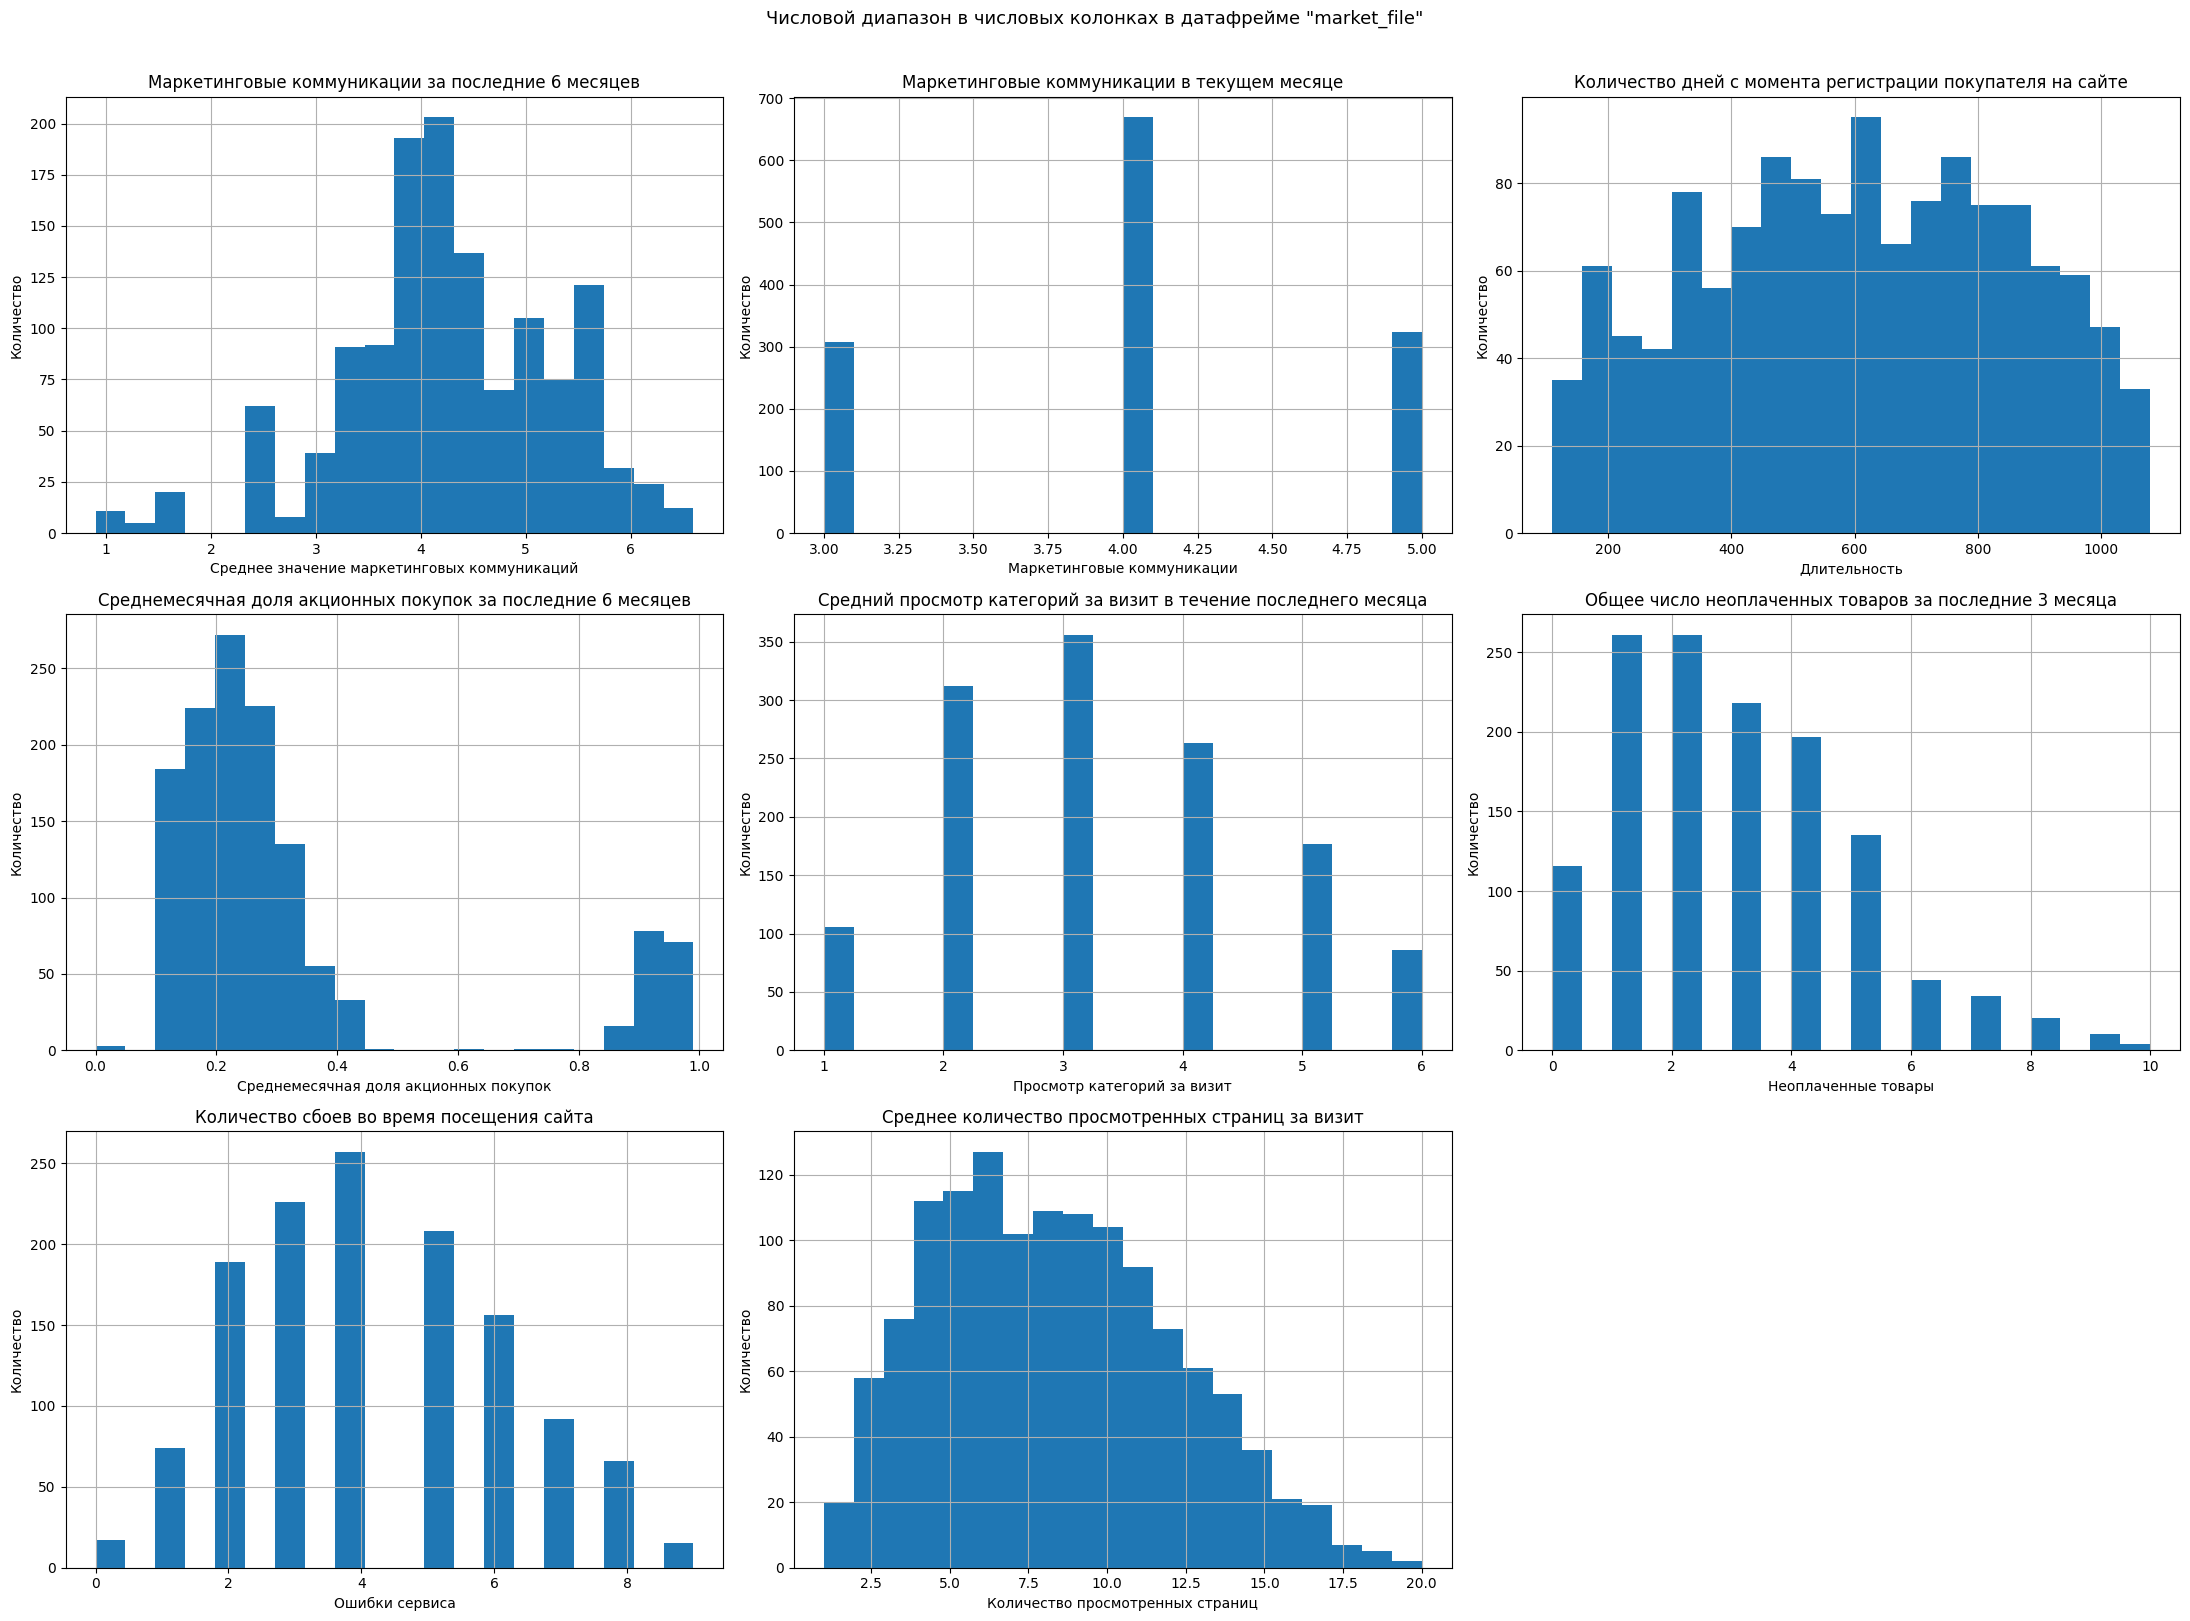

In [25]:
# строим гистограммы в числовых колонках
axes = market_file.drop(columns='id').hist(figsize=(22,16), bins=20);

# Общий заголовок для всех колонок
plt.suptitle('Числовой диапазон в числовых колонках в датафрейме "market_file"', fontsize=13, y=1.01);
# списки для заголовков и подписей осей
titles = [
    'Маркетинговые коммуникации за последние 6 месяцев', 
    'Маркетинговые коммуникации в текущем месяце',
    'Количество дней с момента регистрации покупателя на сайте', 
    'Среднемесячная доля акционных покупок за последние 6 месяцев', 
    'Средний просмотр категорий за визит в течение последнего месяца',
    'Общее число неоплаченных товаров за последние 3 месяца',
    'Количество сбоев во время посещения сайта',
    'Среднее количество просмотренных страниц за визит',
    ''
]
xlabel = [
    'Среднее значение маркетинговых коммуникаций',
    'Маркетинговые коммуникации',
    'Длительность',
    'Среднемесячная доля акционных покупок',
    'Просмотр категорий за визит',
    'Неоплаченные товары',
    'Ошибки сервиса',
    'Количество просмотренных страниц',
    '']
ylabel = ['Количество']*9
"""
axes - массив numpy.ndarray размером (3,2)
axes.flat - это аттрибут numpy.ndarray,  одномерный итератор по массиву,
используется для перебора всех осей из массива осей (в нашем случае осей (3,2))
Это позволяет использовать 1 цикл.
Альтернатива - axes.flatten(), где flatten() - метод массива numpy. Вместо
итератора возвращает уменьшенную версию массива. Снаружи между ними нет никакой разницы.
Однако итератор фактически не создает новый массив и может быть немного быстрее.
"""
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i]);
    ax.set_xlabel(xlabel[i]);
    ax.set_ylabel(ylabel[i]);

# чтобы оси не пересекались с соседними графиками
plt.tight_layout();

**Датафрейм "market_file":**          
**По масштабам шкал гистограмм (ось абсцисс) видно, есть ли аномалии либо выбросы в данных.** 
* Аномальных данных не обнаружено.
* Признаки "маркетинговые коммуникации в течение месяца", "средний просмотр категорий за визит", "число неоплаченных товаров за последние 3 месяца", "количество сбоев во время посещения сайта" имеют ярко выраженные дискретные значения, для них подойдет столбиковая диаграмма. 

#### Датафрейм "market_time"

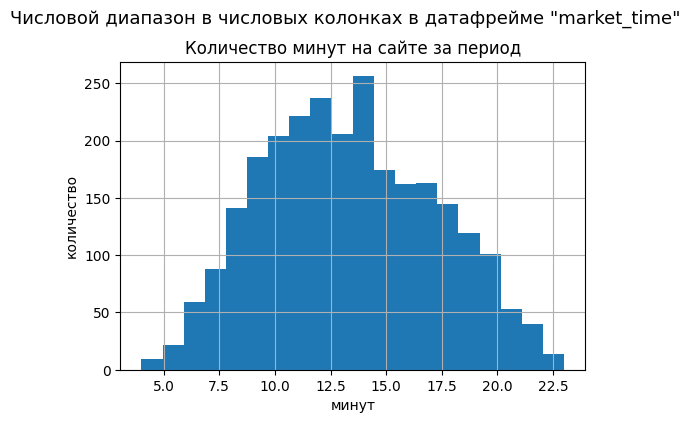

In [26]:
market_time.drop(columns='id').hist(figsize=(6,4), bins=20);
plt.suptitle('Числовой диапазон в числовых колонках в датафрейме "market_time"', fontsize=13, y=1.01);
plt.title('Количество минут на сайте за период');
plt.xlabel('минут')
plt.ylabel('количество');

**Датафрейм "market_time":**          
**По масштабам шкал гистограмм (ось абсцисс) видно, есть ли аномалии либо выбросы в данных.** 
* Аномальных данных не обнаружено.
* Исследовательский анализ признаков будет проведен далее. 

#### Датафрейм "market_money"

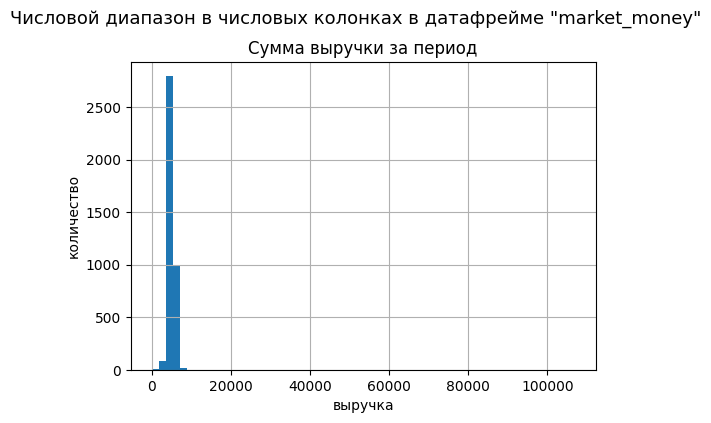

In [27]:
# построение гистограмм для всех числовых колонок в поиске аномалий
market_money.drop(columns='id').hist(figsize=(6,4), bins=60);
plt.suptitle('Числовой диапазон в числовых колонках в датафрейме "market_money"', fontsize=13, y=1.01);
plt.title('Сумма выручки за период');
plt.xlabel('выручка')
plt.ylabel('количество');

**Датафрейм "market_money":**          
**По масштабам шкал гистограмм (ось абсцисс) видно, есть ли аномалии либо выбросы в данных.** 
* По шкале абсцисс видно, что **есть аномальные данные, превышающие общемассовые значения.**
* Исследовательский анализ признаков будет проведен далее. 

**Посмотрим на аномальные данные и их количество.**

In [28]:
# выводим аномальные данные с помощью логической индексации
market_money[market_money['выручка']>=20_000]

id         период   выручка
98  215380  текущий_месяц  106862.2

**Запомним id в строке с аномальными данными для того, чтобы удалить этого покупателя из других таблиц.**

In [29]:
# id_del - это id покупателя с аномальной выручкой
id_del = market_money[market_money['выручка']>=20_000].loc[98,'id']
id_del

215380

**Посмотрим, сколько строк в датафрейме market_money с данным покупателем.**

In [30]:
market_money['id'].isin([id_del]).sum()

3

**Посмотрим, содержат ли остальные таблицы клиента с данным номером id (id_del).**

In [31]:
money['id'].isin([id_del]).sum()

1

In [32]:
market_time['id'].isin([id_del]).sum()

2

In [33]:
market_file['id'].isin([id_del]).sum()

1

**Удалим покупателя с аномально большой выручкой из всех таблиц (так как это будет мешать нам строить модели машинного обучения).**

In [34]:
# удаляем аномальные данные с помощью логической индексации
market_money = market_money[~market_money['id'].isin([id_del])].reset_index(drop=True)
money = money[~money['id'].isin([id_del])].reset_index(drop=True)
market_time = market_time[~market_time['id'].isin([id_del])].reset_index(drop=True)
market_file = market_file[~market_file['id'].isin([id_del])].reset_index(drop=True)
(
    market_money['id'].isin([id_del]).sum(),
    money['id'].isin([id_del]).sum(), 
    market_time['id'].isin([id_del]).sum(), 
    market_file['id'].isin([id_del]).sum()
)

(0, 0, 0, 0)

**Покупатель с аномально большой выручкой удален из всех таблиц.**

**Посмотрим на изменившуюся размерность датафреймов.**

In [35]:
market_file.shape

(1299, 13)

In [36]:
market_time.shape

(2598, 3)

In [37]:
market_money.shape

(3897, 3)

In [38]:
money.shape

(1299, 2)

#### Датафрейм "money"

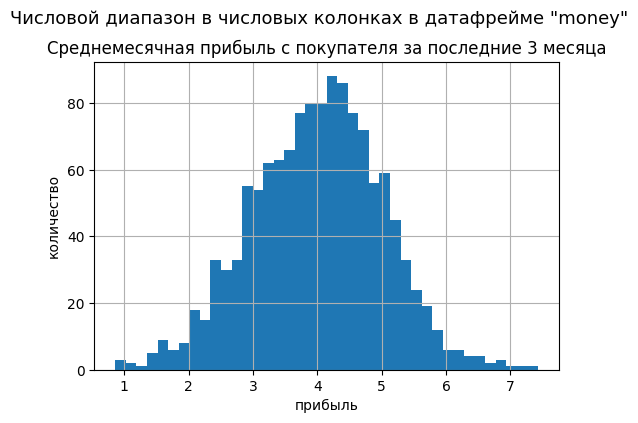

In [39]:
# построение гистограмм для всех числовых колонок в поиске аномалий
money.drop(columns='id').hist(figsize=(6,4), bins=40);
plt.suptitle('Числовой диапазон в числовых колонках в датафрейме "money"', fontsize=13, y=1.01);
plt.title('Среднемесячная прибыль с покупателя за последние 3 месяца');
plt.xlabel('прибыль')
plt.ylabel('количество');

**Датафрейм "money":**          
**По масштабам шкал гистограмм (ось абсцисс) видно, есть ли аномалии либо выбросы в данных.** 
* Аномальных данных не обнаружено.
* Исследовательский анализ признаков будет проведен далее. 

### Промежуточный вывод по предобработке данных

**В ходе предобработки данных были устранены следующие проблемы:**
* В датафрейме "market_file" названия приведены к змеиному стилю.
* Для всех датафреймов все названия столбцов приведены к нижнему регистру.
* В датафрейме "money" в столбце "прибыль" в качестве разделителя десятичных значений исправлена ошибка: поставлена точка вместо запятой. Соответсвенно тип данных изменен на float.
* В датафрейме "market_file" неявные дубликаты в столбце "тип_сервиса" обработаны.
* В датафрейме "market_file" опечатки в столбце "популярная_категория" исправлены.
* В датафрейме "market_time" опечатки в столбце "период" исправлены.
* В датафрейме  "market_money" найден покупатель с аномально большой выручкой. Данный покупатель был удален из вех таблиц. В результате этой операции таблицы "market_file" и "money" уменьшились на одну строку, таблица "market_time" - на 2 строки, таблица "market_money" - на 3 строки.    
Явные дубликаты во всех датафреймах не обнаружены.

## Отбор клиентов с покупательской активностью не менее трёх месяцев

**По техническому заданию требуется разработать модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.** 

**Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.** 

In [40]:
# выведем покупателей, которые не были активны в течение всех трех месяцев
market_money.loc[market_money['выручка'] == 0]

id               период  выручка
0   215348  препредыдущий_месяц      0.0
2   215348     предыдущий_месяц      0.0
28  215357  препредыдущий_месяц      0.0
29  215357     предыдущий_месяц      0.0
34  215359     предыдущий_месяц      0.0
35  215359  препредыдущий_месяц      0.0

In [41]:
# id неактивных покупателей
id_not_active = market_money.loc[market_money['выручка'] == 0]['id'].unique()
id_not_active

array([215348, 215357, 215359], dtype=int64)

**У нас в базе 3 покупателя, которые не имеют покупок в какой-либо из 3 месяцев. Удалим их по id из всех датафреймов.**

In [42]:
# удаляем неактивных покупателей с помощью логической индексации из всех датафреймов по 'id'
market_file = market_file[~market_file['id'].isin(id_not_active)].reset_index(drop=True)
market_money = market_money[~market_money['id'].isin(id_not_active)].reset_index(drop=True)
market_time = market_time[~market_time['id'].isin(id_not_active)].reset_index(drop=True)
money = money[~money['id'].isin(id_not_active)].reset_index(drop=True)

**Посмотрим на изменившуюся размерность датафреймов.**

In [43]:
market_file.shape

(1296, 13)

In [44]:
market_time.shape

(2592, 3)

In [45]:
market_money.shape

(3888, 3)

In [46]:
money.shape

(1296, 2)

**Отбор клиентов с покупательской активностью не менее трёх месяцев:**          
**По техническому заданию требуется разработать модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.**   
Были отобраны клиенты с покупательской активностью не менее трёх месяцев, то есть такие, которые что-либо покупали в этот период.       
В базе обнаружены 3 покупателя, которые не имеют покупок в каждый из 3 месяцев. Даанные с ними были удалены по id из всех датафреймов.      
В результате размерность таблиц изменилась:  
* market_file - 1296 строк, 13 столбцов  
* money - 1296 строк, 2 столбца     
* market_time - 2592 строки, 3 столбца   
* market_money - 3888 строк, 3 столбца   

## Исследовательский анализ данных

 **Рассмотрим сначала признаки, относящиеся к датафрейму "market_file".**

### Исследование маркетинговых коммуникаций за последние 6 месяцев

**Представим распределение маркетинговых коммуникаций за последние 6 месяцев в виде гистограммы.**

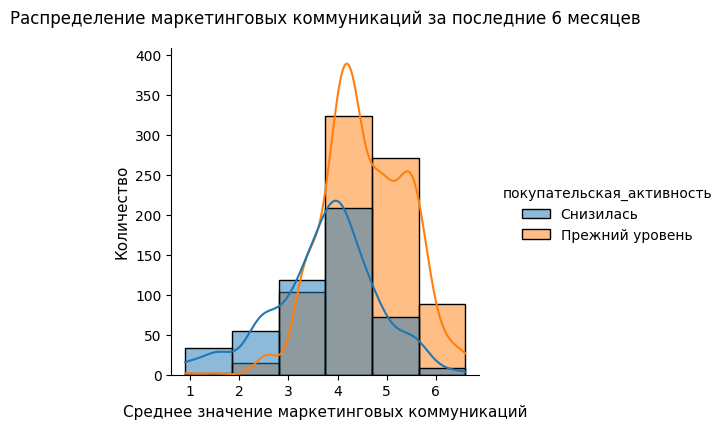

In [47]:
sns.displot(data=market_file, x='маркет_актив_6_мес', hue='покупательская_активность', kde=True, bins=6, height=4, aspect=1);
# Подписи осей
plt.xlabel('Среднее значение маркетинговых коммуникаций', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение маркетинговых коммуникаций за последние 6 месяцев', y=1.05);

- **В среднем у покупателей со сниженной покупательской активностью меньшее значение маркетинговых коммуникаций, чем у покупателей с прежней поупательской активностью.**

**Вычислим статистические характеристики для колонки с маркетинговыми коммуникациями за последние 6 месяцев.**

**Напишем функцию, определяющую границы усов для boxplot, чтобы охарактеризовать наши данные.**

In [48]:
def whisker_border(data=None, column=None):
    """
    Функция возвращает границы усов
    На вход принимает датафрейм и наименование столбца в виде строки. 
    Пример вызова: whisker_border(market_file,'маркет_актив_6_мес')
    """
   # df = pd.DataFrame(data[column].describe().round(2))
    df = pd.DataFrame(data[column].describe())

    #  75-й и 25-й процентили
    q75, q25 = df.loc['75%', column], df.loc['25%', column]
    # вычисляем интерквартильный размах iqr
    iqr = q75 - q25
    # нижняя граница усов
    low = q25 - 1.5 * iqr
    # если минимальная цена в выборке не выходит за границы усов,
    # то нижнюю границу задаем равной минимальной цене, как на графике boxplot
    if low < 0 or low < df.loc['min', column]:
        low = df.loc['min', column]
    # верхняя граница усов
    up = q75 + 1.5 * iqr
    # верхняя граница усов не превышает максимального значения выборки
    if up > df.loc['max', column]:
        up = df.loc['max', column]

    return (low, up)
    #return (round(low,3), round(up,3))

**Напишем функцию, которая будет выводить статистические характеристики, нижнюю и верхнюю границы усов, точки за них выходящие, датафрейм со статистическими характеристиками.**

In [49]:
def whiskers_points_behind(data=None, column=None):
    """
    Функция  выводит статистические характеристики,  нижнюю и верхнюю границы усов, 
    точки за них выходящие, датафрейм со статистическими характеристиками.
    На вход принимает датафрейм и наименование столбца в виде строки. 
    Пример вызова: whiskers_points_behind(market_file,'маркет_актив_6_мес')
    """
    print('-------------------------------------------------------------------------------')
    print(f'Статистические характеристики столбца {pd.DataFrame(data[column]).columns[0]}:')
    # вызов функции whisker_border()
    whiskers = whisker_border(data, column)
    print(f'Диапазон между нижней и верхней границей усов - {whiskers}.')
    
    # количество точек правее верхней границы
    count1 = len(data[data[column] > whiskers[1]])
    print(f'Количество точек правее верхней границы усов - {count1} ({round(100*count1/data.shape[0], 2)}%).')
    # количество точек левее нижней границы
    count2 = len(data[data[column] < whiskers[0]])
    print(f'Количество точек левее нижней границы усов - {count2} ({round(100*count2/data.shape[0], 2)}%).')
    # количество точек между нижней и верхней границей
    count3 = len(data[data[column].notna()]) - count1 - count2
    print(f'Количество точек между нижней и верхней границей усов - {count3} ({round(100*count3/data.shape[0], 2)}%).')
    print('-------------------------------------------------------------------------------')
    return pd.DataFrame(data[column].describe()) # возвращает датафрейм со стат.характеристиками

**Напишем функцию, которая выводит статистические характеристики для заданного признака в разрезе классов "Снизилась" и "Прежний уровень".**

In [50]:
def compare_func(data=None, column=None):
    """
    Функция  выводит статистические характеристики,  нижнюю и верхнюю границы усов, 
    точки за них выходящие, датафрейм со статистическими характеристиками
    для заданного признака (столбца column) в разрезе классов Снизилась и 
    Прежний уровень.
    На вход принимает датафрейм и наименование столбца в виде строки. 
    Пример вызова: whiskers_points_behind(market_file,'маркет_актив_6_мес')
    """
    print('Класс Снизилась')
    df1 = whiskers_points_behind(
        data[data['покупательская_активность']=='Снизилась'],column).rename(columns={column:'Снизилась'})
    print('Класс Прежний уровень')
    df2 = whiskers_points_behind(
        data[data['покупательская_активность']=='Прежний уровень'],column).rename(columns={column:'Прежний уровень'})
    
    return df1.join(df2)

**Представим визульно основные статистические характеристики распределения маркетинговых коммуникаций за последние 6 месяцев.**

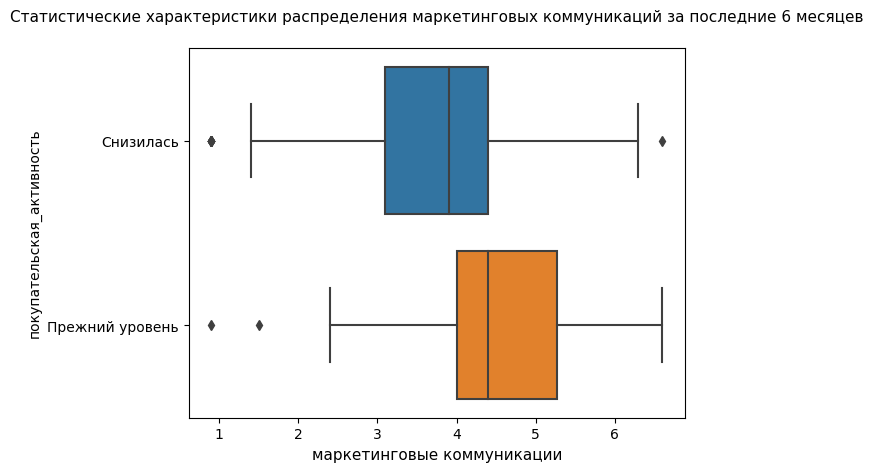

In [51]:
sns.boxplot(x='маркет_актив_6_мес', y='покупательская_активность', data=market_file, showfliers=True); # ящик с усами
# заголовок
plt.title(
    'Статистические характеристики распределения маркетинговых коммуникаций за последние 6 месяцев', 
    y=1.05, fontsize=11);
# подпись оси
plt.xlabel('маркетинговые коммуникации', fontsize=11);

* В классе Снизилась более широкий диапазон значений маркетинговых коммуникаций.
* В классе Прежний уровень более сжатое распределение маркетинговых коммуникаций.
* В классе Прежний уровень более высокое медианное значение маркетинговых коммуникаций.

In [52]:
compare_func(market_file, 'маркет_актив_6_мес')

Класс Снизилась
-------------------------------------------------------------------------------
Статистические характеристики столбца маркет_актив_6_мес:
Диапазон между нижней и верхней границей усов - (1.1499999999999997, 6.3500000000000005).
Количество точек правее верхней границы усов - 1 (0.2%).
Количество точек левее нижней границы усов - 10 (2.02%).
Количество точек между нижней и верхней границей усов - 483 (97.77%).
-------------------------------------------------------------------------------
Класс Прежний уровень
-------------------------------------------------------------------------------
Статистические характеристики столбца маркет_актив_6_мес:
Диапазон между нижней и верхней границей усов - (2.0874999999999995, 6.6).
Количество точек правее верхней границы усов - 0 (0.0%).
Количество точек левее нижней границы усов - 2 (0.25%).
Количество точек между нижней и верхней границей усов - 800 (99.75%).
--------------------------------------------------------------------------

Снизилась  Прежний уровень
count  494.000000       802.000000
mean     3.747166         4.570075
std      1.052777         0.848618
min      0.900000         0.900000
25%      3.100000         4.000000
50%      3.900000         4.400000
75%      4.400000         5.275000
max      6.600000         6.600000

**Исследование маркетинговых коммуникаций за последние 6 месяцев в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение маркетинговых коммуникаций в классе "Снизилась" - 3.9 меньше, чем в классе "Прежний уровень" (4.4).
- 25% покупателей с наименьшим средним числом маркетинговых коммуникаций в классе "Снизилась" - от 1.1 до 3.1, в классе "Прежний уровень" - от 2.1 до 4.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют среднее число маркетинговых коммуникаций - от 3.1 до 4.4, в классе "Прежний уровень" - от 4 до 5.3.
- 25% покупателей с наибольшим средним числом маркетинговых коммуникаций в классе "Снизилась" - от 4.4 до 6.35, в классе "Прежний уровень" - от 5.3 до 6.6.           
**В классе "Снизилась" более широкий диапазон значений маркетинговых коммуникаций. В классе "Прежний уровень" более сжатое распределение маркетинговых коммуникаций.**   

### Исследование количества дней с момента регистрации покупателя на сайте

**Представим распределение количества дней с момента регистрации покупателя на сайте в виде гистограммы.**

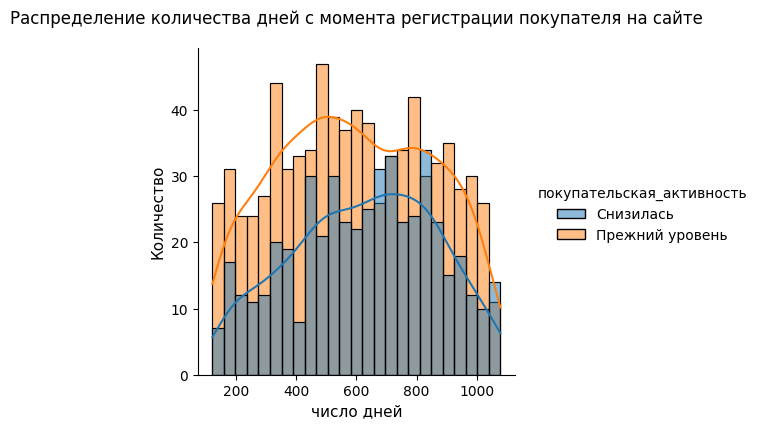

In [53]:
sns.displot(data=market_file, x='длительность', hue='покупательская_активность', kde=True, bins=25, height=4, aspect=1);
# Подписи осей
plt.xlabel('число дней', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение количества дней с момента регистрации покупателя на сайте', y=1.05);

**Представим визульно основные статистические характеристики распределения количества дней с момента регистрации покупателя на сайте.**

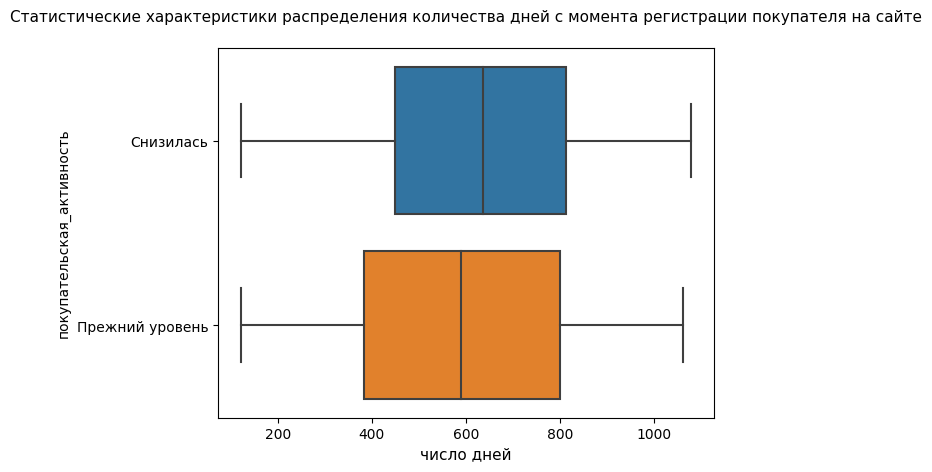

In [54]:
sns.boxplot(x='длительность', data=market_file, y='покупательская_активность', showfliers=True); # ящик с усами
# заголовок
plt.title(
    'Статистические характеристики распределения количества дней с момента регистрации покупателя на сайте',\
    y=1.05, fontsize=11);
# подпись оси
plt.xlabel('число дней', fontsize=11);

**Таким образом, в среднем в классе "Снизилась" более давние клиенты по сравнению с классом "Прежний уровень".**

**Вычислим статистические характеристики распределения количества дней с момента регистрации покупателя на сайте.**

In [55]:
compare_func(market_file, 'длительность')

Класс Снизилась
-------------------------------------------------------------------------------
Статистические характеристики столбца длительность:
Диапазон между нижней и верхней границей усов - (121.0, 1079.0).
Количество точек правее верхней границы усов - 0 (0.0%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 494 (100.0%).
-------------------------------------------------------------------------------
Класс Прежний уровень
-------------------------------------------------------------------------------
Статистические характеристики столбца длительность:
Диапазон между нижней и верхней границей усов - (121.0, 1061.0).
Количество точек правее верхней границы усов - 0 (0.0%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 802 (100.0%).
-------------------------------------------------------------------------------


Снизилась  Прежний уровень
count   494.000000       802.000000
mean    622.834008       590.730673
std     237.817052       255.330179
min     121.000000       121.000000
25%     449.000000       382.500000
50%     636.500000       590.000000
75%     812.500000       798.750000
max    1079.000000      1061.000000

**Исследование количества дней с момента регистрации покупателя на сайте в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение количества дней с момента регистрации покупателя на сайте в классе "Снизилась" - 637 больше, чем в классе "Прежний уровень" (590).
- 25% покупателей с наименьшим количеством дней с момента регистрации в классе "Снизилась" - от 121 до 449, в классе "Прежний уровень" - от 121 до 383.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют количество дней с момента регистрации - от 449 до 813, в классе "Прежний уровень" - от 383 до 799.
- 25% покупателей с наибольшим количеством дней с момента регистрации  в классе "Снизилась" - от 813 до 1079, в классе "Прежний уровень" - от 799 до 1061.         

### Исследование cреднемесячной доли акционных покупок за последние 6 месяцев

**Представим распределение cреднемесячной доли акционных покупок за последние 6 месяцев в виде гистограммы.**

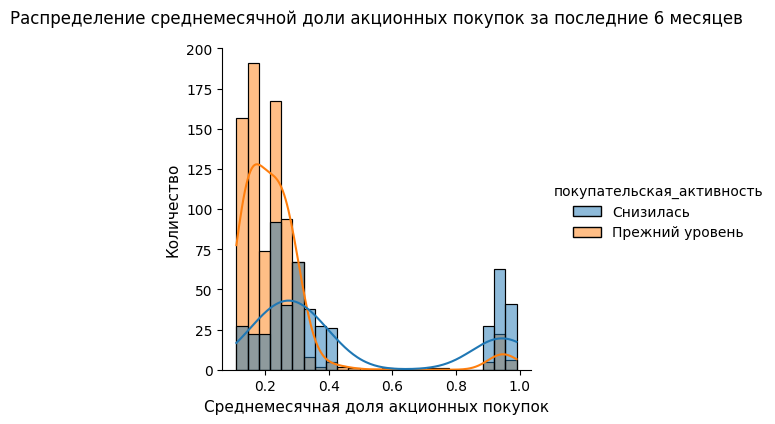

In [56]:
sns.displot(data=market_file, x='акционные_покупки', kde=True, hue='покупательская_активность',\
            bins=25, height=4, aspect=1);
# Подписи осей
plt.xlabel('Среднемесячная доля акционных покупок', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение cреднемесячной доли акционных покупок за последние 6 месяцев', y=1.05);

**На гистограмме видны 2 сегмента: с высокой и низкой долей акционных покупок. При этом в каждом сегменте есть представители 2 классов: Снизилась и Прежний уровень.**   
**Снижение покупательской активности сильно затронуло сегмент с высокой долей акционных покупок, если рассматривать в относительных величинах. Однако, если рассматривать в абсолютных величинах, то сегмент с низкой долей акционных покупок имеет более высокое снижение покупательской активности.** 

**Разобъем условно данные на 2 сегмента: сегмент с низкой долей покупок по акции - до 0.5, сегмент с высокой долей покупок по акции - от 0.5 до до 1.**

In [57]:
# создаем категориальный столбец для сегментов с низкой и высокой долей акционных покупок
market_file['акционные_покупки_категории'] = pd.cut(
    market_file['акционные_покупки'], [-float('inf'), 0.5, 1], \
    labels=["низкая доля акционных покупок", "высокая доля акционных покупок"])

In [58]:
# относительное значение покупателей в сегментах
display(market_file['акционные_покупки_категории'].value_counts(normalize=True))
# абсолютное значение покупателей в сегментах
market_file['акционные_покупки_категории'].value_counts()

низкая доля акционных покупок     0.871142
высокая доля акционных покупок    0.128858
Name: акционные_покупки_категории, dtype: float64

низкая доля акционных покупок     1129
высокая доля акционных покупок     167
Name: акционные_покупки_категории, dtype: int64

В числовых величинах:
* Сегмент с низкой долей покупок по акции: 1129 покупателей, 87%.
* Сегмент с высокой долей покупок по акции: 167 покупателей, 13%.        

In [59]:
df = market_file.reset_index().pivot_table(
    index='акционные_покупки_категории', columns='покупательская_активность', values = 'id', aggfunc='count')   
df['Прежний уровень доля'] = (df['Прежний уровень'] / (df['Прежний уровень'] + df['Снизилась'])).round(2)
df['Снизилась доля'] = 1 - df['Прежний уровень доля'] 
df

покупательская_активность       Прежний уровень  Снизилась  \
акционные_покупки_категории                                  
низкая доля акционных покупок               768        361   
высокая доля акционных покупок               34        133   

покупательская_активность       Прежний уровень доля  Снизилась доля  
акционные_покупки_категории                                           
низкая доля акционных покупок                   0.68            0.32  
высокая доля акционных покупок                  0.20            0.80

**Исследование покупательской активности в зависимости от деления на сегменты по доли акционных покупок:**  

* В сегменте с высокой долей акционных покупок: покупательская активность снизилась в 80% случаев (133 покупателя), осталась на прежнем уровне - в 20% случаев (34 покупателя).     
* В сегменте с низкой долей акционных покупок: покупательская активность снизилась в 32% случаев (361 покупатель), осталась на прежнем уровне - в 68% случаев (768 покупателей). 

**Посмотрим на ящик с усами без разбиения на сегменты и с разбиением отдельно.**

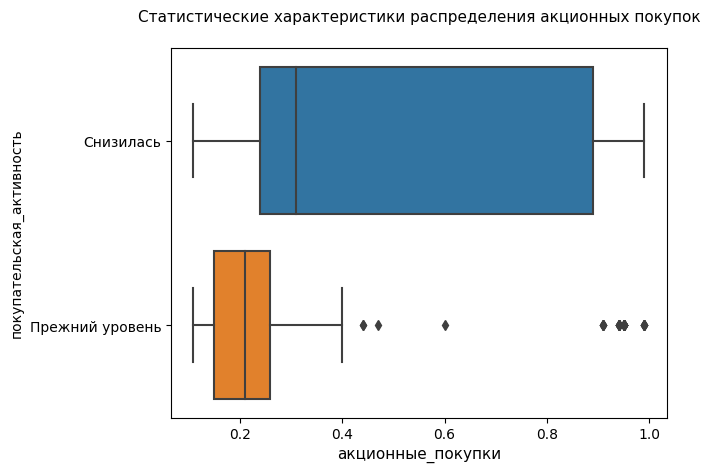

In [60]:
sns.boxplot(x='акционные_покупки', y='покупательская_активность', data=market_file, showfliers=True); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения акционных покупок', y=1.05, fontsize=11);
# подпись оси
plt.xlabel('акционные_покупки', fontsize=11);

**Класс покупательская активность "Снизилась" имеет более широкое распределение акционных покупок по сравнению с классом покупательской активности "Прежний уровень".**

In [61]:
compare_func(market_file, 'акционные_покупки')

Класс Снизилась
-------------------------------------------------------------------------------
Статистические характеристики столбца акционные_покупки:
Диапазон между нижней и верхней границей усов - (0.11, 0.99).
Количество точек правее верхней границы усов - 0 (0.0%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 494 (100.0%).
-------------------------------------------------------------------------------
Класс Прежний уровень
-------------------------------------------------------------------------------
Статистические характеристики столбца акционные_покупки:
Диапазон между нижней и верхней границей усов - (0.11, 0.42500000000000004).
Количество точек правее верхней границы усов - 37 (4.61%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 765 (95.39%).
-------------------------------------------------------------------------------


Снизилась  Прежний уровень
count  494.000000       802.000000
mean     0.452713         0.238367
std      0.304428         0.160599
min      0.110000         0.110000
25%      0.240000         0.150000
50%      0.310000         0.210000
75%      0.890000         0.260000
max      0.990000         0.990000

**Исследование акционных покупок без разбиения на сегменты по доле акционных покупок:**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение доли акционных покупок в классе "Снизилась" - 0.31 больше, чем в классе "Прежний уровень" (0.21).
- 25% покупателей с наименьшей долей акционных покупок в классе "Снизилась" - от 0.11 до 0.24, в классе "Прежний уровень" - от 0.11 до 0.15.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют долю акционных покупок - от 0.24 до 0.89, в классе "Прежний уровень" - от 0.15 до 0.26.
- 25% покупателей с наибольшей долей акционных покупок в классе "Снизилась" - от 0.89 до 0.99, в классе "Прежний уровень" - от 0.26 до 0.43.
В классе "Снизилась" более широкий диапазон значений доли акционных покупок. В классе "Прежний уровень" более сжатое распределение доли акционных покупок.   

**Теперь посмотрим на ящик с усами с разбиением на сегменты по доле акционных покупок.**

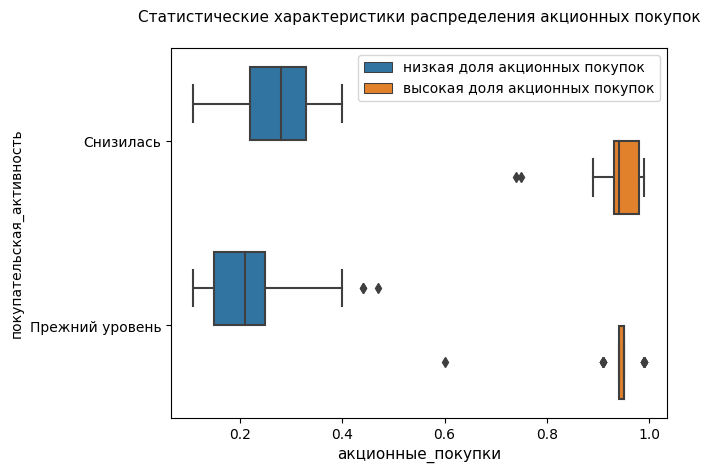

In [62]:
sns.boxplot(x='акционные_покупки', y='покупательская_активность', \
            hue='акционные_покупки_категории', data=market_file, showfliers=True); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения акционных покупок', y=1.05, fontsize=11);
# подпись оси
plt.xlabel('акционные_покупки', fontsize=11);
plt.legend(loc='best');

**Исследование акционных покупок с разбиением на сегменты по доле акционных покупок:** 
* Для сегмента с высокой долей акционных покупок для класса "Прежний уровень" - более сжатое распределение доли акционных покупок, для класса "Снизилась" - более широкое распределение, при этом медианное значение примерно на одном уровне.
* Для сегмента с низкой долей акционных покупок для класса "Прежний уровень" меньшее медианное значение по сравнению с классом "Снизилась".
* Этот график демонстрирует, что есть часть клиентов с высокой долей акционных покупок, но при этом их покупательская активность не снижается.    
Ниже опишем подробно с числовыми характеристиками.

**Вычислим статистические характеристики распределения акционных покупок для сегмента с низкой долей акционных покупок.**

In [63]:
market_file['акционные_покупки_категории'].value_counts()

низкая доля акционных покупок     1129
высокая доля акционных покупок     167
Name: акционные_покупки_категории, dtype: int64

In [64]:
compare_func(market_file[market_file['акционные_покупки_категории']=='низкая доля акционных покупок'], 'акционные_покупки')

Класс Снизилась
-------------------------------------------------------------------------------
Статистические характеристики столбца акционные_покупки:
Диапазон между нижней и верхней границей усов - (0.11, 0.4).
Количество точек правее верхней границы усов - 0 (0.0%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 361 (100.0%).
-------------------------------------------------------------------------------
Класс Прежний уровень
-------------------------------------------------------------------------------
Статистические характеристики столбца акционные_покупки:
Диапазон между нижней и верхней границей усов - (0.11, 0.4).
Количество точек правее верхней границы усов - 3 (0.39%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 765 (99.61%).
-------------------------------------------------------------------------------


Снизилась  Прежний уровень
count  361.000000       768.000000
mean     0.272742         0.207370
std      0.075214         0.063752
min      0.110000         0.110000
25%      0.220000         0.150000
50%      0.280000         0.210000
75%      0.330000         0.250000
max      0.400000         0.470000

**Исследование акционных покупок для сегмента с низкой долей акционных покупок в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1129 экземпляров данных: 361 экземпляр данных - в классе "Снизилась", 768 экземпляров данных - в классе "Прежний уровень".
- Медианное значение доли акционных покупок в классе "Снизилась" - 0.28 больше, чем в классе "Прежний уровень" (0.21).
- 25% покупателей с наименьшей долей акционных покупок в классе "Снизилась" - от 0.11 до 0.22, в классе "Прежний уровень" - от 0.11 до 0.15.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют долю акционных покупок - от 0.22 до 0.33, в классе "Прежний уровень" - от 0.15 до 0.25.
- 25% покупателей с наибольшей долей акционных покупок в классе "Снизилась" - от 0.33 до 0.4, в классе "Прежний уровень" - от 0.25 до 0.4.         
**В классе "Снизилась" более высокое медианное значение доли акционных покупок (0.28), чем в классе "Прежний уровень" (0.21)**.   

**Вычислим статистические характеристики распределения акционных покупок для сегмента с высокой долей акционных покупок.**

In [65]:
compare_func(market_file[market_file['акционные_покупки_категории']=='высокая доля акционных покупок'], 'акционные_покупки')

Класс Снизилась
-------------------------------------------------------------------------------
Статистические характеристики столбца акционные_покупки:
Диапазон между нижней и верхней границей усов - (0.8550000000000002, 0.99).
Количество точек правее верхней границы усов - 0 (0.0%).
Количество точек левее нижней границы усов - 2 (1.5%).
Количество точек между нижней и верхней границей усов - 131 (98.5%).
-------------------------------------------------------------------------------
Класс Прежний уровень
-------------------------------------------------------------------------------
Статистические характеристики столбца акционные_покупки:
Диапазон между нижней и верхней границей усов - (0.9249999999999999, 0.965).
Количество точек правее верхней границы усов - 6 (17.65%).
Количество точек левее нижней границы усов - 6 (17.65%).
Количество точек между нижней и верхней границей усов - 22 (64.71%).
-------------------------------------------------------------------------------


Снизилась  Прежний уровень
count  133.000000        34.000000
mean     0.941203         0.938529
std      0.041158         0.064297
min      0.740000         0.600000
25%      0.930000         0.940000
50%      0.940000         0.950000
75%      0.980000         0.950000
max      0.990000         0.990000

**Исследование акционных покупок для сегмента с высокой долей акционных покупок в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 167 экземпляров данных: 133 экземпляра данных - в классе "Снизилась", 34 экземпляров данных - в классе "Прежний уровень".
- Медианное значение доли акционных покупок в классе "Снизилась" - 0.94 меньше, чем в классе "Прежний уровень" (0.95).
- 25% покупателей с наименьшей долей акционных покупок в классе "Снизилась" - от 0.86 до 0.93, в классе "Прежний уровень" - от 0.92 до 0.94.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют долю акционных покупок - от 0.93 до 0.98, в классе "Прежний уровень" - от 0.94 до 0.95.
- 25% покупателей с наибольшей долей акционных покупок в классе "Снизилась" - от 0.98 до 0.99, в классе "Прежний уровень" - от 0.95 до 0.97.   
**Для сегмента с высокой долей акционных покупок для класса "Прежний уровень" - более сжатое распределение доли акционных покупок, для класса "Снизилась" - более широкое рапределение.**

### Исследование среднего количества просмотренных страниц за визит

**Представим распределение среднего количества просмотренных страниц за визит в виде гистограммы.**

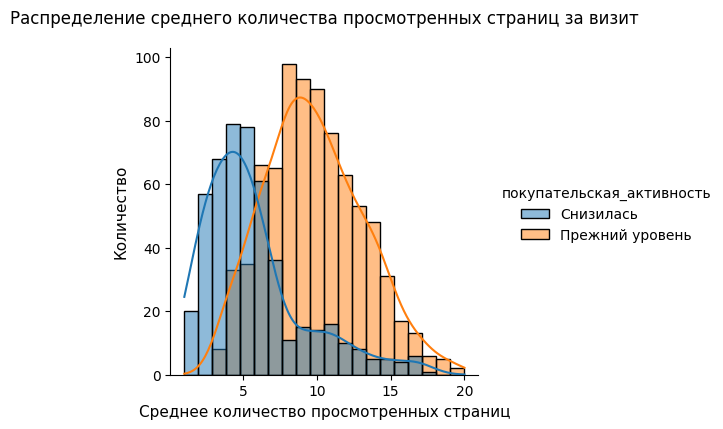

In [66]:
sns.displot(data=market_file, x='страниц_за_визит', hue='покупательская_активность', kde=True, bins=20, height=4, aspect=1);
# Подписи осей
plt.xlabel('Среднее количество просмотренных страниц', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение среднего количества просмотренных страниц за визит', y=1.05);

- **Распределение среднего количества просмотренных страниц для класса "Снизилась" находится левее, чем класса "Прежний уровень". Это говорит о том, что большая часть клиентов в сегменте "Снизилась" имеет меньшее количество просмотренных страниц по сравнению с сегментом "Прежний уровень".**   
- **Распределение среднего количества просмотренных страниц для класса "Снизилась" имеет широкий правый хвост, что говорит о том, что часть клиентов этого сегмента просматривает достаточно большое количество просмотренных страниц, однако их активность все равно снизилась.**

**Представим визульно основные статистические характеристики распределения среднего количества просмотренных страниц за визит.**

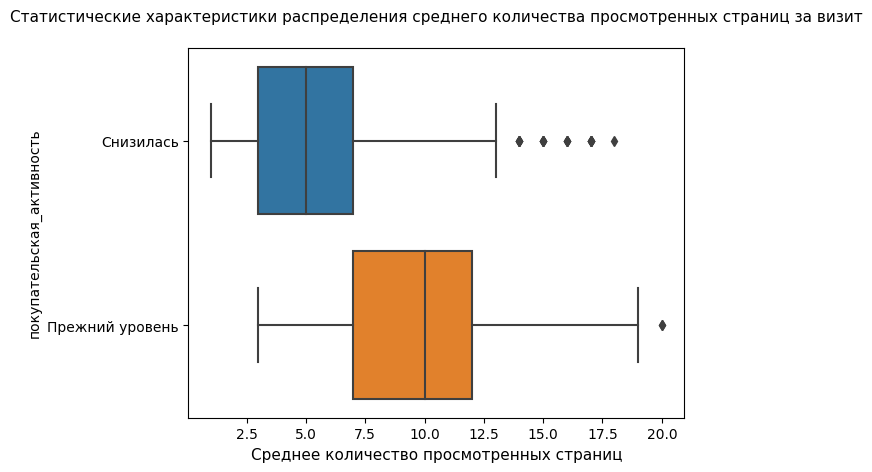

In [67]:
sns.boxplot(x='страниц_за_визит', data=market_file, y='покупательская_активность', showfliers=True); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения среднего количества просмотренных страниц за визит', \
          y=1.05, fontsize=11);
# подпись оси
plt.xlabel('Среднее количество просмотренных страниц', fontsize=11);

**Вычислим статистические характеристики распределения среднего количества просмотренных страниц за визит.**

In [68]:
compare_func(market_file, 'страниц_за_визит')

Класс Снизилась
-------------------------------------------------------------------------------
Статистические характеристики столбца страниц_за_визит:
Диапазон между нижней и верхней границей усов - (1.0, 13.0).
Количество точек правее верхней границы усов - 21 (4.25%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 473 (95.75%).
-------------------------------------------------------------------------------
Класс Прежний уровень
-------------------------------------------------------------------------------
Статистические характеристики столбца страниц_за_визит:
Диапазон между нижней и верхней границей усов - (3.0, 19.5).
Количество точек правее верхней границы усов - 2 (0.25%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 800 (99.75%).
-------------------------------------------------------------------------------


Снизилась  Прежний уровень
count  494.000000       802.000000
mean     5.574899         9.796758
std      3.463729         3.376846
min      1.000000         3.000000
25%      3.000000         7.000000
50%      5.000000        10.000000
75%      7.000000        12.000000
max     18.000000        20.000000

**Исследование среднего количества просмотренных страниц за визит в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение количества просмотренных страниц за визит в классе "Снизилась" - 5, что значительно меньше, чем в классе "Прежний уровень" (10).
- 25% покупателей с наименьшим средним количеством просмотренных страниц за визит в классе "Снизилась" - от 1 до 3, в классе "Прежний уровень" - от 3 до 7.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют среднее количество просмотренных страниц за визит - от 0.3 до 7, в классе "Прежний уровень" - от 7 до 12.
- 25% покупателей с наибольшим количеством просмотренных страниц за визит в классе "Снизилась" - от 7 до 13, в классе "Прежний уровень" - от 12 до 19.    
Таким образом, в среднем покупатели класса "Снизилась" имеют меньшее количество просмотренных страниц за визит, чем класса "Прежний уровень".

### Исследование маркетинговых коммуникаций в текущем месяце

**Исследуем количество маркетинговых коммуникаций в текущем месяце, которое приходилось на покупателя. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.**

In [69]:
market_file['маркет_актив_тек_мес'].nunique() # количество уникальных значений

3

In [70]:
market_file['маркет_актив_тек_мес'].sort_values().unique() # уникальные значения

array([3, 4, 5], dtype=int64)

**Данные по маркетинговым коммуникациям дискретны, поэтому будем использовать столбиковую диаграмму.**

**Создадим функцию для построения столбиковой диаграммы с уже готовым оформлением графика. Регулировать можно заголовок, подписи осей, метки над столбиком, если нужны, размер графика, поворот надписей под углом по оси абсцисс.**

In [71]:
"""
Функция создает столбиковую диаграмму. На вход функции поступает датафрейм data, 
столбец для построения column, заголовок графика title, подпись по оси абсцисс xlabel,
подпись по оси ординат ylabel, размер графика figsize, подпись величины столбика label - 
абсолютная - 1, абсолютная и относительная - 2, без подписи - 0,
порядок сортировки order_sort - без сортировки (0), по убыванию (1), по возрастанию (2),
поворот подписи по оси абсцисс rotation, палитра palette (по умолчанию 'Paired'). 
Подпись величины столбика label может принимать 3 значения: 0, 1, 2:
0- без подписи, столбики не упорядочены. 
1 - абсолютное значение столбика, 2 - относительное значение столбика. 

Пример вызова функции:
countplot_label(data=market_file, column='маркет_актив_тек_мес', \
                title='Маркетинговые коммуникации в текущем месяце', \
                xlabel='Маркетинговые коммуникации', ylabel='Количество', \
                figsize=(6,4), label=2, order_sort=0, rotation=0, palette='Paired')
"""
def countplot_label(data=None, column=None, title=None, xlabel=None, \
                    ylabel=None, figsize=(6,4), label=0, order_sort=0, \
                    rotation=0, palette='Paired'):
    # задаем размер и четкость-количество точек на дюйм
    plt.figure(figsize=figsize,dpi=100)
    sns.set(style='whitegrid') # добавим сетку (белый фон серая сетка) на заднем фоне
    #по умолчанию style='white'

    # Создадим датафрейм df, содержащий 3 столбца - абсолютные, относительные значения 
    # категории, третий столбец - кортеж из абс. и относ. значений (отформатированный по стилю)
    # абсолютные значения по категории
    abs_values = data[column].value_counts(ascending=False)
    # относительные значения по категории
    rel_values = data[column].value_counts(ascending=False, normalize=True).round(3).values *100
    # создание датафрейма
    df = pd.DataFrame(abs_values)
    df['relative'] = rel_values
    # наименования столбцов
    df.columns = ['absolute', 'relative'] 
    # список из кортежей абсолютных и относительных значений
    lst=list(zip(df['absolute'], df['relative']))
    # создание столбца из абс. и отн. значений, отформатированных (для отн. значений -
    # после запятой 1 знак и процент)
    df['total']=[f'{p[0]} ({p[1]:.1f}%)' for p in lst]
    # сортировка по индексу
    df = df.sort_index()
    
    #порядок действий в зависимости от заданных значений
    if order_sort == 2: # по возрастанию
        df = df.sort_values(by='absolute')
        order = df.index
        if label == 1: # 1 метка - абсолютная
            lbls = df['absolute'].values
        elif label == 2: # 2 метки абс. и отн.
            lbls = df['total'].values
        elif label == 0:
            lbls=''
    elif order_sort == 1: # по убыванию
        df = df.sort_values(by='absolute', ascending=False)
        order = df.index
        if label == 1: # 1 метка - абсолютная
            lbls = df['absolute'].values
        elif label == 2: # 2 метки
            lbls = df['total'].values
        elif label == 0:
            lbls=''
    elif order_sort == 0: # без сортировки
        order = df.index
        if label == 1: # 1 метка - абсолютная
            lbls = df['absolute'].values
        elif label == 2: # 2 метки абс. и отн.
            lbls = df['total'].values
        elif label == 0:
            lbls=''
    # построение графика
    ax = sns.countplot(data=data, x=column, order=order, palette='Paired');
    # метки над графиком
    for p, label in zip(ax.patches, lbls):
            ax.annotate(label, (p.get_x(), p.get_height()))
    # названия осей
    plt.xlabel(xlabel, fontsize=11);
    plt.xticks(rotation=rotation) # поворот надписи по оси абсцисс
    plt.ylabel(ylabel, fontsize=11);
    # заголовок
    plt.title(title, y=1.05, fontsize=11);
    # чтобы оси не пересекались с соседними графиками
    plt.tight_layout();

**Построим графики в разрезе классов "Снизилась" и "Прежний уровень".**

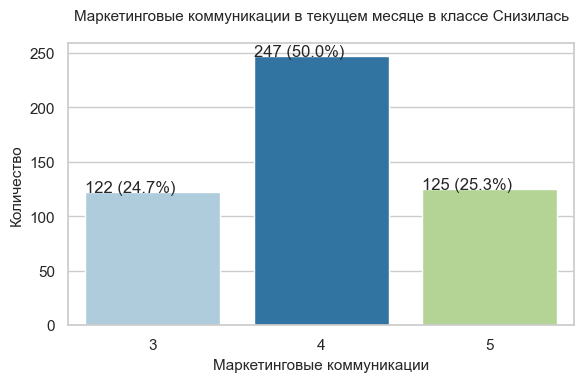

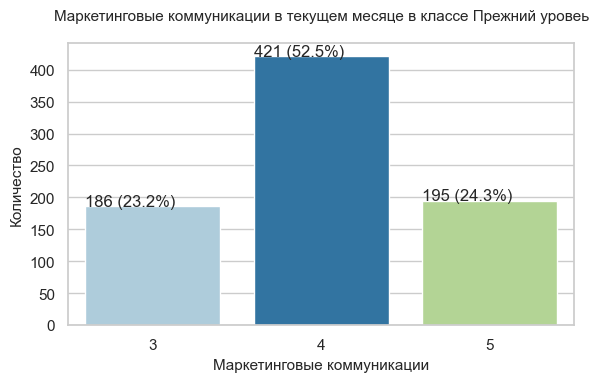

In [72]:
countplot_label(data=market_file[market_file['покупательская_активность']=='Снизилась'], column='маркет_актив_тек_мес', \
                title='Маркетинговые коммуникации в текущем месяце в классе Снизилась', \
                xlabel='Маркетинговые коммуникации', ylabel='Количество', \
                figsize=(6,4), label=2, order_sort=0, rotation=0, palette='Paired')
countplot_label(data=market_file[market_file['покупательская_активность']=='Прежний уровень'], column='маркет_актив_тек_мес', \
                title='Маркетинговые коммуникации в текущем месяце в классе Прежний уровеь', \
                xlabel='Маркетинговые коммуникации', ylabel='Количество', \
                figsize=(6,4), label=2, order_sort=0, rotation=0, palette='Paired')

**Исследование количества маркетинговых коммуникаций в текущем месяце  в разрезе классов "Снизилась" и "Прежний уровень":**       
В относительных величинах количество маркетинговых коммуникаций в разрезе классов "Снизилась" и "Прежний уровень" примерно одинаково. Однако в абсолютных величинах ввиду того, что класс "Прежний уровень" имеет значительно большее количество покупателей по сравнению с классом "Снизилась" - значения класса "Прежний уровень" значительно больше.    

### Исследование среднего количества просмотров категорий за визит в течение последнего месяца

**Исследуем, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.**

In [73]:
market_file['средний_просмотр_категорий_за_визит'].nunique() # количество уникальных значений

6

In [74]:
market_file['средний_просмотр_категорий_за_визит'].sort_values().unique() # уникальные значения

array([1, 2, 3, 4, 5, 6], dtype=int64)

**Данные по среднему количеству просмотров категорий за визит в течение последнего месяца дискретны, поэтому будем использовать столбиковую диаграмму.**

**Построим графики в разрезе классов "Снизилась" и "Прежний уровень".**

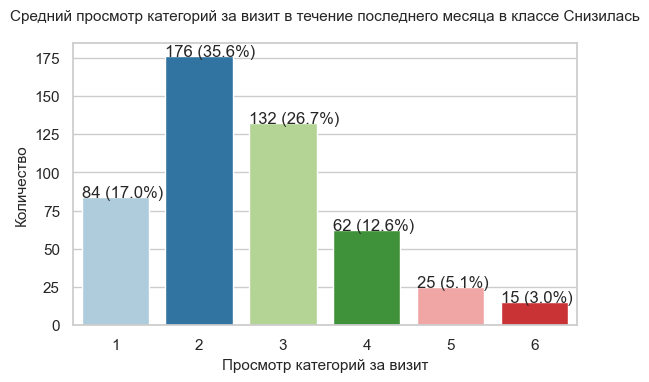

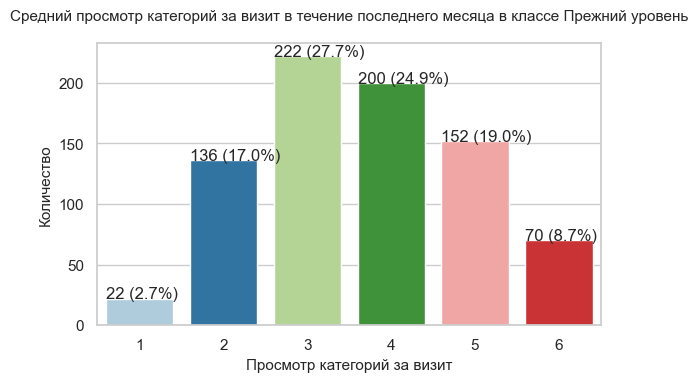

In [75]:
countplot_label(data=market_file[market_file['покупательская_активность']=='Снизилась'], 
                column='средний_просмотр_категорий_за_визит', 
                title='Средний просмотр категорий за визит в течение последнего месяца в классе Снизилась', 
                xlabel='Просмотр категорий за визит', ylabel='Количество', 
                figsize=(6,4), label=2, order_sort=0, rotation=0, palette='Paired')
countplot_label(data=market_file[market_file['покупательская_активность']=='Прежний уровень'], 
                column='средний_просмотр_категорий_за_визит', 
                title='Средний просмотр категорий за визит в течение последнего месяца в классе Прежний уровень', 
                xlabel='Просмотр категорий за визит', ylabel='Количество', 
                figsize=(6,4), label=2, order_sort=0, rotation=0, palette='Paired')

**Исследование среднего количества просмотров категорий за визит в течение последнего месяца  в разрезе классов "Снизилась" и "Прежний уровень":**       
* В относительных величинах в  среднем среднее количество просмотров категорий за визит в классе  "Прежний уровень" выше, чем в классе "Снизилась". 
* В классе Снизилась первые 3 категории с наибольшим количеством просмотров - 2 (176 чел., 35.6%), 3 (132 чел., 26.7%), 1 (84 чел., 17%), а в классе  "Прежний уровень" - 3 (222 чел., 27.7%), 4 (200 чел., 24.9%), 5 (152 чел., 19%).

### Исследование общего числа неоплаченных товаров за последние 3 месяца

Исследуем общее число неоплаченных товаров в корзине за последние 3 месяца.

In [76]:
market_file['неоплаченные_продукты_штук_квартал'].nunique() # количество уникальных значений

11

In [77]:
market_file['неоплаченные_продукты_штук_квартал'].sort_values().unique() # уникальные значения

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

**Данные по общему числу неоплаченных товаров за последние 3 месяца дискретны, поэтому будем использовать столбиковую диаграмму.**

**Построим графики в разрезе классов "Снизилась" и "Прежний уровень".**

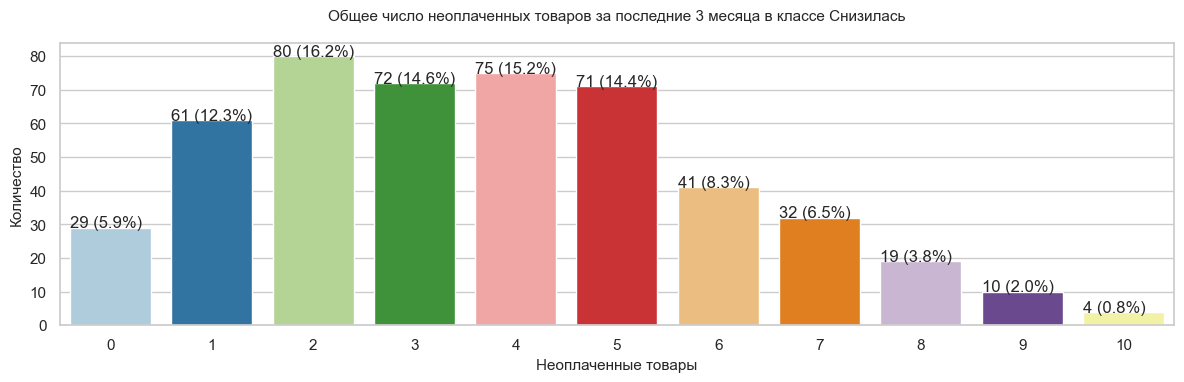

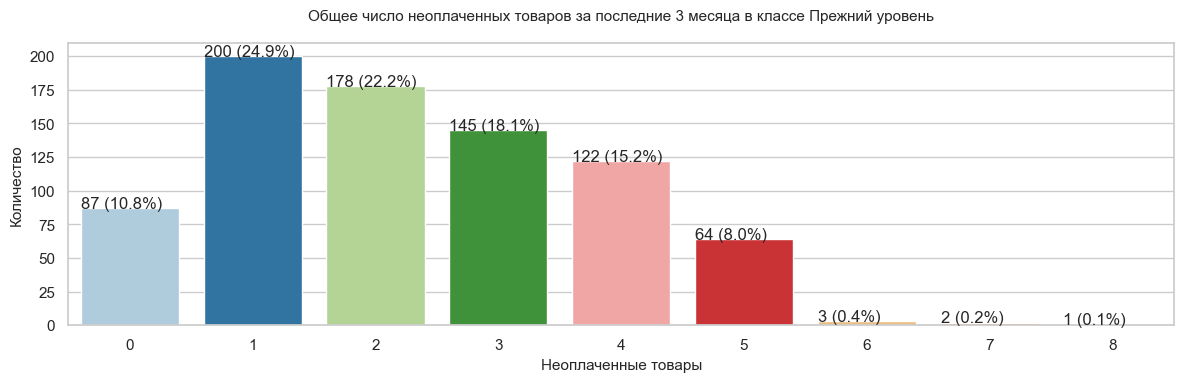

In [78]:
countplot_label(data=market_file[market_file['покупательская_активность']=='Снизилась'],
                column='неоплаченные_продукты_штук_квартал', 
                title='Общее число неоплаченных товаров за последние 3 месяца в классе Снизилась', 
                xlabel='Неоплаченные товары', ylabel='Количество', 
                figsize=(12,4), label=2, order_sort=0, rotation=0, palette='Paired')
countplot_label(data=market_file[market_file['покупательская_активность']=='Прежний уровень'], 
                column='неоплаченные_продукты_штук_квартал', 
                title='Общее число неоплаченных товаров за последние 3 месяца в классе Прежний уровень', 
                xlabel='Неоплаченные товары', ylabel='Количество', 
                figsize=(12,4), label=2, order_sort=0, rotation=0, palette='Paired')

**Исследование общего числа неоплаченных товаров за последние 3 месяца в разрезе классов "Снизилась" и "Прежний уровень":**
* В классах "Снизилась" и "Прежний уровень" распределение неоплаченных товаров отличается.        
* Класс "Снизилась" более активно использует корзину для хранения интересующих товаров.
* В классе "Снизилась" примерно равномерное распределение на участке от 2 до 5 товаров в корзине: 2 товара - 80 чел., 15.6%, 3 товара - 72 чел., 14.6%, 4 товара - 75 чел., 15.2%, 5 товаров - 71 чел., 14.4%.
* Для класса "Прежний уровень" количество товаров в корзине с 1 до 8 идет на убывание: 1 товар - 200 чел., 24.9%, 2 товара - 178 чел., 22.2%, 3 товара - 145 чел., 18.1%, 4 товара - 122 чел., 15.2%, 5 товаров - 64 чел., 8%.
* Для каждого из классов есть покупатели, не имеющие неоплаченные товары в корзине: класс "Снизилась" - 29 чел., 5.9%, класс "Прежний уровень" - 87 чел., 10%.

### Исследование количества сбоев во время посещения сайта

Исследуем ошибки сервиса, то есть число сбоев, которые коснулись покупателя во время посещения сайта.

In [79]:
market_file['ошибка_сервиса'].nunique() # количество уникальных значений

10

In [80]:
market_file['ошибка_сервиса'].sort_values().unique() # уникальные значения

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

**Данные по числу сбоев во время посещения сайта дискретны, поэтому будем использовать столбиковую диаграмму.**

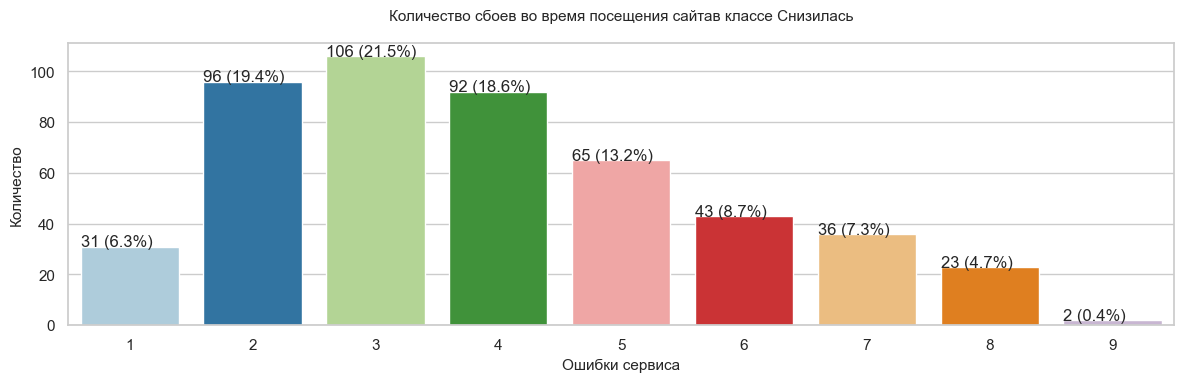

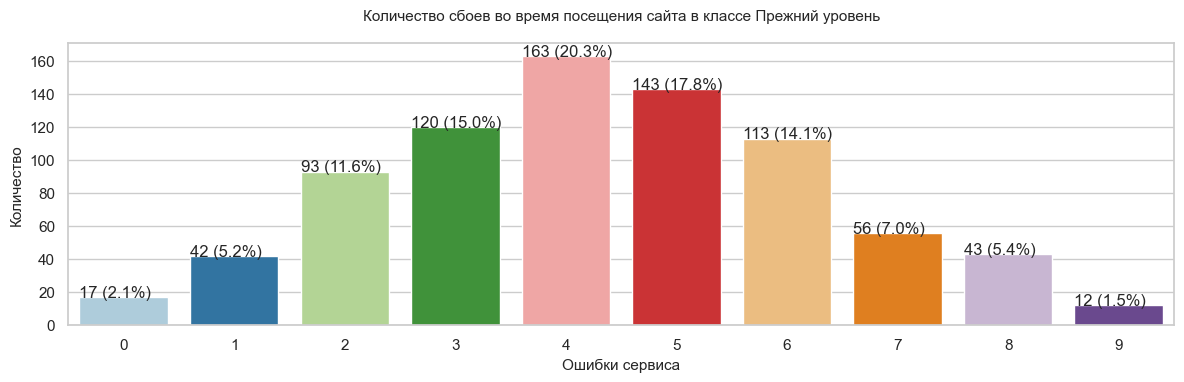

In [81]:
countplot_label(data=market_file[market_file['покупательская_активность']=='Снизилась'],
                column='ошибка_сервиса', 
                title='Количество сбоев во время посещения сайтав классе Снизилась',
                xlabel='Ошибки сервиса', ylabel='Количество', 
                figsize=(12,4), label=2, order_sort=0, rotation=0, palette='Paired')
countplot_label(data=market_file[market_file['покупательская_активность']=='Прежний уровень'], 
                column='ошибка_сервиса', 
                title='Количество сбоев во время посещения сайта в классе Прежний уровень',  
                xlabel='Ошибки сервиса', ylabel='Количество', 
                figsize=(12,4), label=2, order_sort=0, rotation=0, palette='Paired')

**Вполне логично, что во время посещения сайта у класса Прежний уровень возникает большее количество ошибок сервиса, чем у класса Снизилась. Это связано с большим количеством просмотренных страниц и категорий за визит, как было выяснено ранее.**

### Исследование класса покупательской активности

Исследуем класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

**Покупательская активность - категориальный признак, построим для него столбиковую диаграмму.**

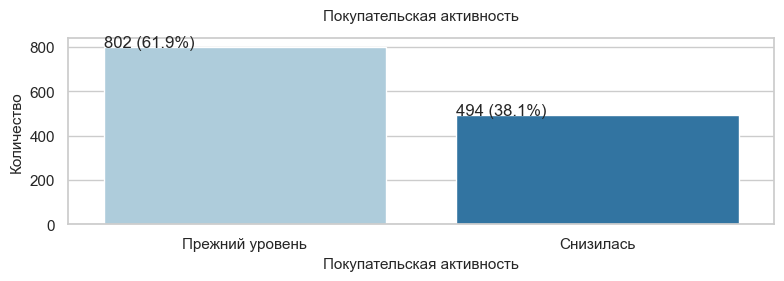

In [82]:
countplot_label(data=market_file, column='покупательская_активность', \
                title='Покупательская активность', \
                xlabel='Покупательская активность', ylabel='Количество', \
                figsize=(8,3), label=2, order_sort=0, rotation=0, palette='Paired')

**Исследование класса покупательской активности:**    
* Покупательская активность осталась на прежнем уровне у 802 покупателей (61.9%).    
* Покупательская активность снизилась у 494 покупателей (38.1%).      

**А теперь исследуем покупательскую активность в зависимости от различных категориальных признаков.**

#### Исследование типа сервиса и покупательской активности в зависимости от типа сервиса

Тип сервиса - категориальный признак, построим для него столбиковую диаграмму.

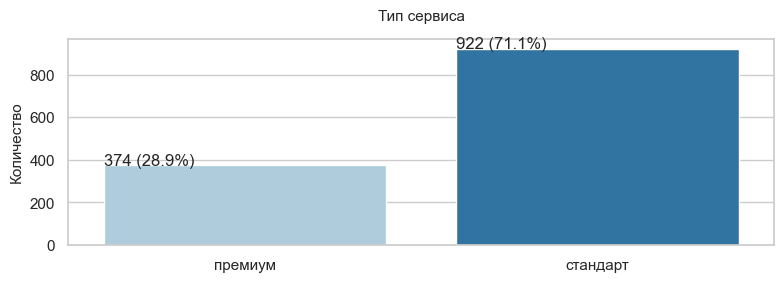

In [83]:
countplot_label(data=market_file, column='тип_сервиса', \
                title='Тип сервиса', \
                xlabel='', ylabel='Количество', \
                figsize=(8,3), label=2, order_sort=0, rotation=0, palette='Paired')

**Исследование типа сервиса:**    
* 922 покупателя (71.1%) относятся к сервису "стандарт".      
* 375 покупателей (28.9%) относятся к сервису "премиум".

**Исследуем покупательскую активность в зависимости от типа сервиса.**

покупательская_активность  Прежний уровень  Снизилась  \
тип_сервиса                                             
премиум                                206        168   
стандарт                               596        326   

покупательская_активность  Доля класса Прежний уровень  Доля класса Снизилась  
тип_сервиса                                                                    
премиум                                           0.55                   0.45  
стандарт                                          0.65                   0.35

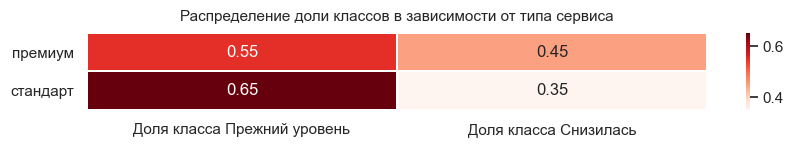

In [84]:
plt.figure(dpi=100, figsize=(10,1)) # размер, четкость
# группировка: в строках - тип сервиса, в столбцах - Класс, агрегирующая функция - количество
df = market_file.pivot_table(
    index='тип_сервиса', 
    columns = 'покупательская_активность', 
    aggfunc='count', 
    values='разрешить_сообщать')
df['Доля класса Прежний уровень'] = (
    df['Прежний уровень'] / (df['Прежний уровень'] + df['Снизилась'])
).round(2)
df['Доля класса Снизилась'] = 1 - df['Доля класса Прежний уровень']
display(df)
# Заголовок
plt.title('Распределение доли классов в зависимости от типа сервиса', y=1.05, fontsize=11);
# подписи на осях
# тепловая карта. "удаление" меток осей сделали с помощью .set(xlabel='', ylabel='')
sns.heatmap(
    data=df[
    ['Доля класса Прежний уровень', 'Доля класса Снизилась']
    ], linewidth=0.5, cmap='Reds', annot=True, fmt='.3').set(xlabel='', ylabel='');

**Исследование покупательской активности в зависимости от типа сервиса:**    
Для типа сервиса "премиум" 45% (168 покупателей) в классе "Снизилась", 55% (206 покупателей) в классе "Прежний уровень".         
Для типа сервиса "стандарт" 35% (326 покупателей) в классе "Снизилась", 65% (596 покупателей) в классе "Прежний уровень".

#### Исследование популярной категории и покупательской активности в зависимости от популярной категории.

**Популярная категория - категориальный признак, построим для него столбиковую диаграмму.**

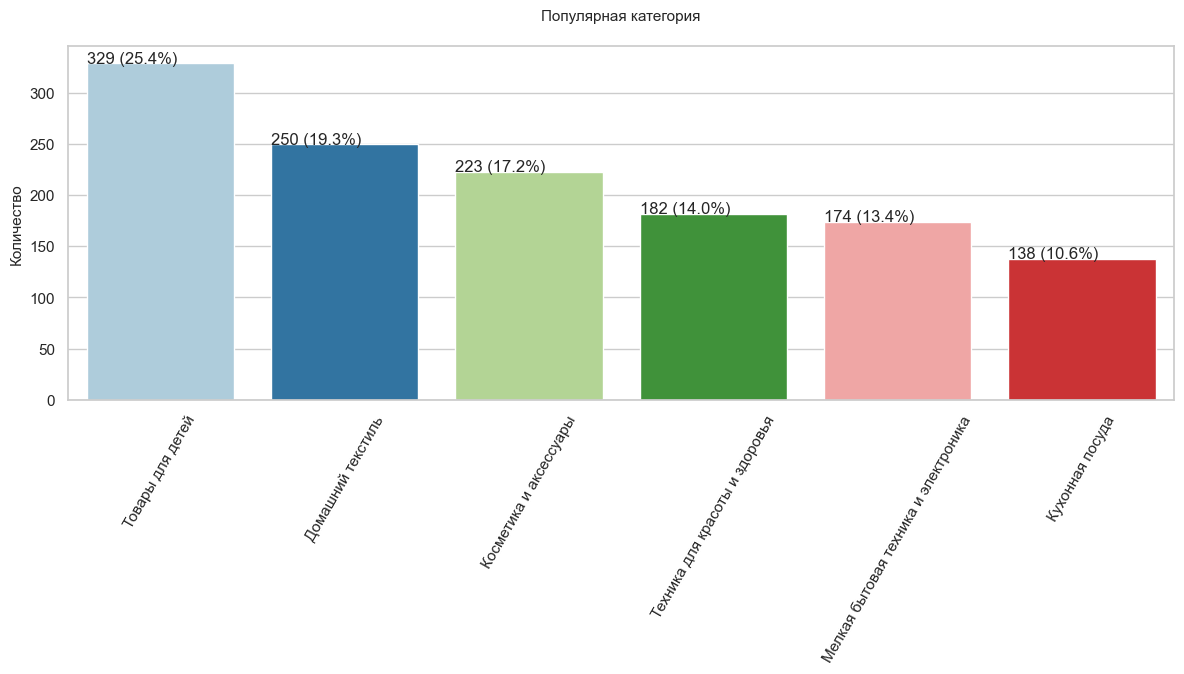

In [85]:
countplot_label(data=market_file, column='популярная_категория', \
                title='Популярная категория', \
                xlabel='', ylabel='Количество', \
                figsize=(12,7), label=2, order_sort=1, rotation=60, palette='Paired')

**Исследование популярной категории:**             
* Товары для детей - 329 покупателей (25.4%).
* Домашний текстиль - 250 покупателей (19.3%).
* Косметика и аксессуары - 223 покупателя (17.2%).
* Техника для красоты и здоровья - 182 покупателя (14%).
* Мелкая бытовая техника и электроника - 174 покупателя (13.4%).
* Кухонная посуда - 138 покупателей (10.6%).

**Исследуем покупательскую активность в зависимости от популярной категории.**

покупательская_активность             Прежний уровень  Снизилась  \
популярная_категория                                               
Домашний текстиль                                 149        101   
Косметика и аксессуары                            118        105   
Кухонная посуда                                    72         66   
Мелкая бытовая техника и электроника              147         27   
Техника для красоты и здоровья                    132         50   
Товары для детей                                  184        145   

покупательская_активность             Доля класса Прежний уровень  \
популярная_категория                                                
Домашний текстиль                                            0.60   
Косметика и аксессуары                                       0.53   
Кухонная посуда                                              0.52   
Мелкая бытовая техника и электроника                         0.84   
Техника для красоты и здоровья                               0.73   
Товары для детей                                             0.56   

покупательская_активность             Доля класса Снизилась  
популярная_категория                                         
Домашний текстиль                                      0.40  
Косметика и аксессуары                                 0.47  
Кухонная посуда                                        0.48  
Мелкая бытовая техника и электроника                   0.16  
Техника для красоты и здоровья                         0.27  
Товары для детей                                       0.44

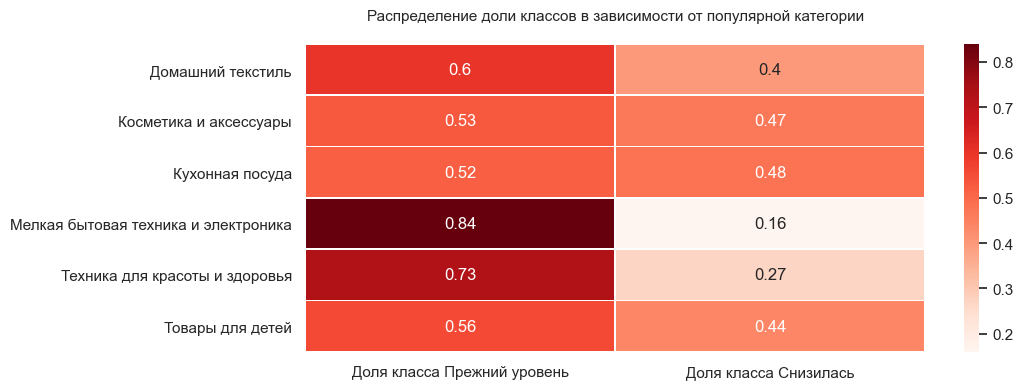

In [86]:
plt.figure(dpi=100, figsize=(10,4)) # размер, четкость
# группировка: по строкам - популярная_категория, по столбцам - покупательская активность, агрегирующая функция - количество.
df = market_file.pivot_table(
    index='популярная_категория', 
    columns = 'покупательская_активность', 
    aggfunc='count', 
    values='разрешить_сообщать')
df = df.fillna(0)
df['Доля класса Прежний уровень'] = (df['Прежний уровень'] / (df['Прежний уровень'] + df['Снизилась'])).round(2)
df['Доля класса Снизилась'] = 1 - df['Доля класса Прежний уровень']
display(df)
# Заголовок
plt.title('Распределение доли классов в зависимости от популярной категории', y=1.05, fontsize=11);
# тепловая карта. "удаление" меток осей сделали с помощью .set(xlabel='', ylabel='')
sns.heatmap(
    data=df[
    ['Доля класса Прежний уровень', 'Доля класса Снизилась']
    ], linewidth=0.5, cmap='Reds', annot=True, fmt='.3').set(xlabel='', ylabel='');

**Исследование покупательской активности в зависимости от популярной категории:**    
  
*Наименьшее снижение в категориях:*
* "Мелкая бытовая техника и электроника" (16%, 27 покупателей).
* "Техника для красоты и здоровья" (27%, 50 покупатель).
   
*Наибольшее снижение в категориях:*
* "Кухонная посуда" (48%, 66 покупателей).
* "Косметика и аксессуары" (47%, 105 покупателей).
* "Товары для детей" (44%, 145 покупателей).
* "Домашний текстиль" (40%, 101 покупатель).

#### Исследование признака согласия по рассылке и покупательской активности в зависимости от этого признака

**Согласие по рассылке - категориальный признак, построим для него столбиковую диаграмму.**

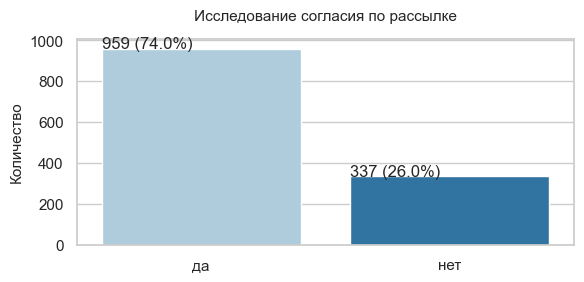

In [87]:
countplot_label(data=market_file, column='разрешить_сообщать', \
                title='Исследование согласия по рассылке', \
                xlabel='', ylabel='Количество', \
                figsize=(6,3), label=2, order_sort=1, rotation=0, palette='Paired')

**Исследование признака согласия по рассылке:**              
* Согласны - 959 покупателей (74%).       
* Не согласны - 337 покупателей (26%).

**Исследуем покупательскую активность в зависимости от согласия покупателя, можно ли присылать ему дополнительные предложения о товаре.**

покупательская_активность  Прежний уровень  Снизилась  \
разрешить_сообщать                                      
да                                     591        368   
нет                                    211        126   

покупательская_активность  Доля класса Прежний уровень  Доля класса Снизилась  
разрешить_сообщать                                                             
да                                                0.62                   0.38  
нет                                               0.63                   0.37

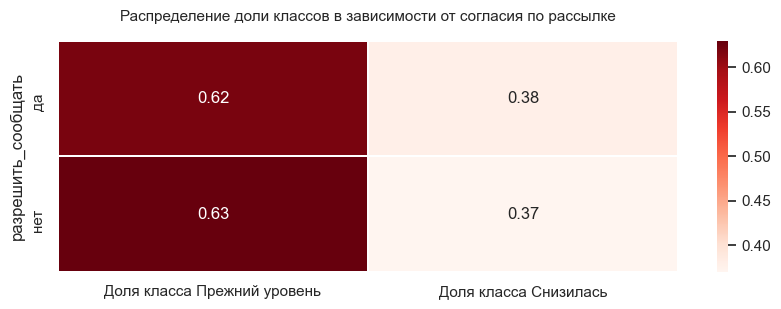

In [88]:
plt.figure(dpi=100, figsize=(10,3)) # размер, четкость
# группировка: по строкам - согласие покупателя, 
# по столбцам - покупательская активность, агрегирующая функция - количество.
df = market_file.pivot_table(
    index='разрешить_сообщать',
    columns = 'покупательская_активность',
    aggfunc='count',
    values='тип_сервиса')
df = df.fillna(0)
df['Доля класса Прежний уровень'] = (
    df['Прежний уровень'] / (df['Прежний уровень'] + df['Снизилась'])).round(2)
df['Доля класса Снизилась'] = 1 - df['Доля класса Прежний уровень']
display(df)
# Заголовок
plt.title('Распределение доли классов в зависимости от согласия по рассылке', y=1.05, fontsize=11);
# тепловая карта. "удаление" меток осей сделали с помощью .set(xlabel='', ylabel='')
sns.heatmap(
    data=df[
    ['Доля класса Прежний уровень', 'Доля класса Снизилась']
    ], linewidth=0.5, cmap='Reds', annot=True, fmt='.3').set(xlabel='');

**Исследование покупательской активности в зависимости от согласия покупателя на дополнительную рассылку о предложениях по товарам:**    
* Произошло одинаковое снижение покупательской активности (38%) в относительных величинах в классах разрешить сообщать и не разрешать сообщение.   
* Покупательская активность снизилась у 38% покупателей (368 человек) среди давших разрешение на отправку предложений о товаре.    
* Покупательская активность снизилась у 37% покупателей (126 человек) среди недавших разрешение на отправку предложений о товаре.  

#### Исследование покупательской активности в зависимости от общего числа неоплаченных товаров в корзине за последние 3 месяца.

покупательская_активность           Прежний уровень  Снизилась  \
неоплаченные_продукты_штук_квартал                               
0                                              87.0       29.0   
1                                             200.0       61.0   
2                                             178.0       80.0   
3                                             145.0       72.0   
4                                             122.0       75.0   
5                                              64.0       71.0   
6                                               3.0       41.0   
7                                               2.0       32.0   
8                                               1.0       19.0   
9                                               0.0       10.0   
10                                              0.0        4.0   

покупательская_активность           Доля класса Прежний уровень  \
неоплаченные_продукты_штук_квартал                                
0                                                          0.75   
1                                                          0.77   
2                                                          0.69   
3                                                          0.67   
4                                                          0.62   
5                                                          0.47   
6                                                          0.07   
7                                                          0.06   
8                                                          0.05   
9                                                          0.00   
10                                                         0.00   

покупательская_активность           Доля класса Снизилась  
неоплаченные_продукты_штук_квартал                         
0                                                    0.25  
1                                                    0.23  
2                                                    0.31  
3                                                    0.33  
4                                                    0.38  
5                                                    0.53  
6                                                    0.93  
7                                                    0.94  
8                                                    0.95  
9                                                    1.00  
10                                                   1.00

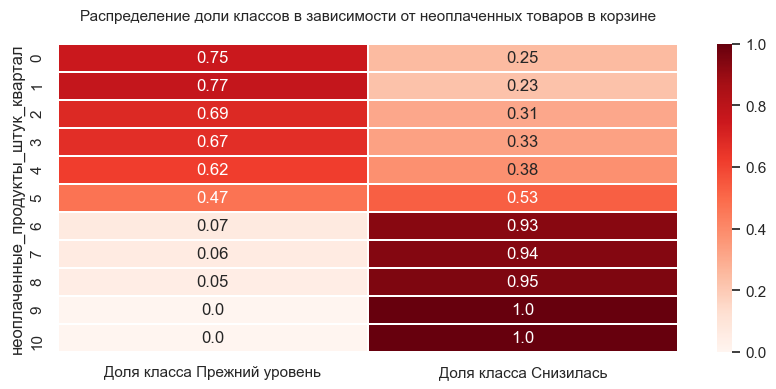

In [89]:
plt.figure(dpi=100, figsize=(10,4)) # размер, четкость
# группировка: по строкам - неоплаченные_продукты_штук_квартал,
# по столбцам - покупательская активность, агрегирующая функция - количество.
df = market_file.pivot_table(
    index='неоплаченные_продукты_штук_квартал',
    columns = 'покупательская_активность',
    aggfunc='count',
    values='разрешить_сообщать')
df = df.fillna(0)
df['Доля класса Прежний уровень'] = (
    df['Прежний уровень'] / (df['Прежний уровень'] + df['Снизилась'])).round(2)
df['Доля класса Снизилась'] = 1 - df['Доля класса Прежний уровень']
display(df)
# Заголовок
plt.title('Распределение доли классов в зависимости от неоплаченных товаров в корзине', y=1.05, fontsize=11);
# тепловая карта. "удаление" меток осей сделали с помощью .set(xlabel='', ylabel='')
sns.heatmap(
    data=df[
    ['Доля класса Прежний уровень', 'Доля класса Снизилась']
    ], linewidth=0.5, cmap='Reds', annot=True, fmt='.3').set(xlabel='');

**Исследование покупательской активности в зависимости от общего числа неоплаченных товаров в корзине за последние 3 месяца:**   
Наибольшее снижение в относительных величинах пришлось на покупателей, имеющих от 6 до 10 товаров в корзине:
10 неоплаченных товаров - снижение 100% (4 чел.)           
9  неоплаченных товаров - снижение 100% (10 чел.)       
8  неоплаченных товаров - снижение 95% (19 чел.)       
7  неоплаченных товаров - снижение 94% (32 чел.)         
6  неоплаченных товаров - снижение 93% (41 чел.)         
5  неоплаченных товаров - снижение 53% (71 чел.)   
4  неоплаченных товара -  снижение 38% (75 чел.)       
3  неоплаченных товаров - снижение 33% (72 чел.)       
2  неоплаченных товаров - снижение 94% (32 чел.)         
1  неоплаченный товар -   снижение 23% (61 чел.)   
0  неоплаченный товаров - снижение 25% (29 чел.)  

**Подсчитаем, какой процент покупателей с количеством неоплаченных товаров более или равном 5 имеет снижение покупательской активности к общему числу покупателей со сниженной активностью.**

In [90]:
# количество покупателей класса Снизилась с количеством неоплаченных товаров более или равном 5
low = market_file[
    market_file['неоплаченные_продукты_штук_квартал'] >=5
]['покупательская_активность'].value_counts()['Снизилась']
# общее количество покупателей класса Снизилась
low_all = market_file['покупательская_активность'].value_counts()['Снизилась']
(low / low_all).round(2)

0.36

**Таким образом, 36% покупателей в классе "Снизилась" имеют неоплаченные товары за последний квартал в количестве более или равном 5.**    
Для стимулирования продаж интернет-магазину будет полезно напоминать покупателю, если он согласен на рассылку, что на товар в корзине действуют дополнительные скидки и количество оставшихся товаров.

### Исследовательский анализ данных. Датафрейм "market_money"

#### Исследование суммы выручки с покупателя за период

**Представим распределение выручки, которую получает магазин с покупателя, в виде диаграммы и ящика с усами для сравнения за разные периоды сначала без деления на классы по целевому признаку, затем - с делением.**    

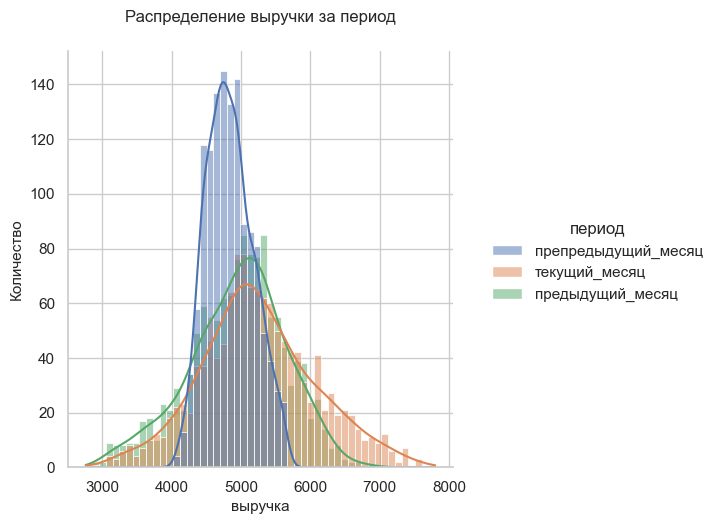

In [91]:
sns.displot(data=market_money, hue='период', kde=True, x='выручка');
# Подписи осей
plt.xlabel('выручка', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение выручки за период', y=1.05);

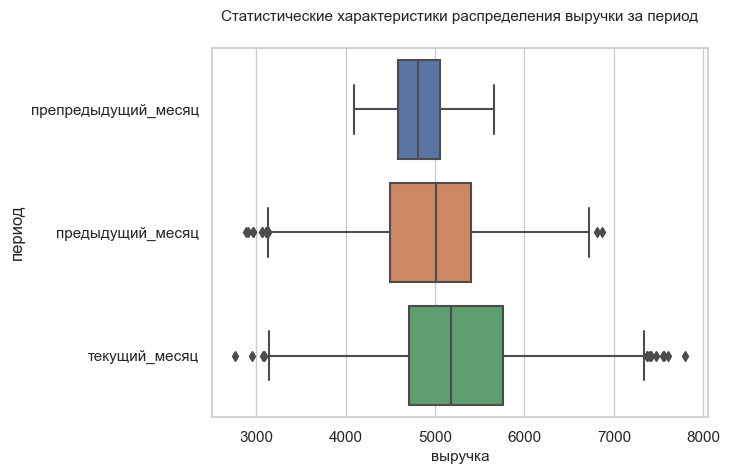

In [92]:
order = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']
sns.boxplot(x='выручка', y='период', data=market_money, showfliers=True, order=order); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения выручки за период', y=1.05, fontsize=11);
# подпись оси
plt.xlabel('выручка', fontsize=11);

**Видим, что распределение выручки за препредыдущий месяц более сжато, а распределение выручки за текущий месяц имеет более широкий диапазон. Это говорит о том, что риски не получить плановую выручку с покупателя возросли. Медианное значение суммы выручки идет по нарастанию, так же как и риски. Вполне естественно: большему доходу соответствует больший риск.**

**Исследуем сумму выручки с покупателя по периодам в разрезе классов графически, но для наглядности также получим числовую таблицу по средней и общей выручке.**

In [93]:
# создаем датафрейм, содержащий выручку и покупательскую активность
df = market_money.set_index('id').join(market_file.set_index('id')[['покупательская_активность']])
# группируем по периодам и покупательской активности и рассчитываем аггрегирующие значения для столбца выручка
df.groupby(['период', 'покупательская_активность'])['выручка'].agg(['mean','median', 'sum', 'count'])

mean   median  \
период              покупательская_активность                         
предыдущий_месяц    Прежний уровень            4932.559227  4977.25   
                    Снизилась                  4971.674089  5052.75   
препредыдущий_месяц Прежний уровень            4933.475062  4927.00   
                    Снизилась                  4678.281377  4668.00   
текущий_месяц       Прежний уровень            5197.704115  5122.55   
                    Снизилась                  5303.671660  5293.65   

                                                     sum  count  
период              покупательская_активность                    
предыдущий_месяц    Прежний уровень            3955912.5    802  
                    Снизилась                  2456007.0    494  
препредыдущий_месяц Прежний уровень            3956647.0    802  
                    Снизилась                  2311071.0    494  
текущий_месяц       Прежний уровень            4168558.7    802  
                    Снизилась                  2620013.8    494

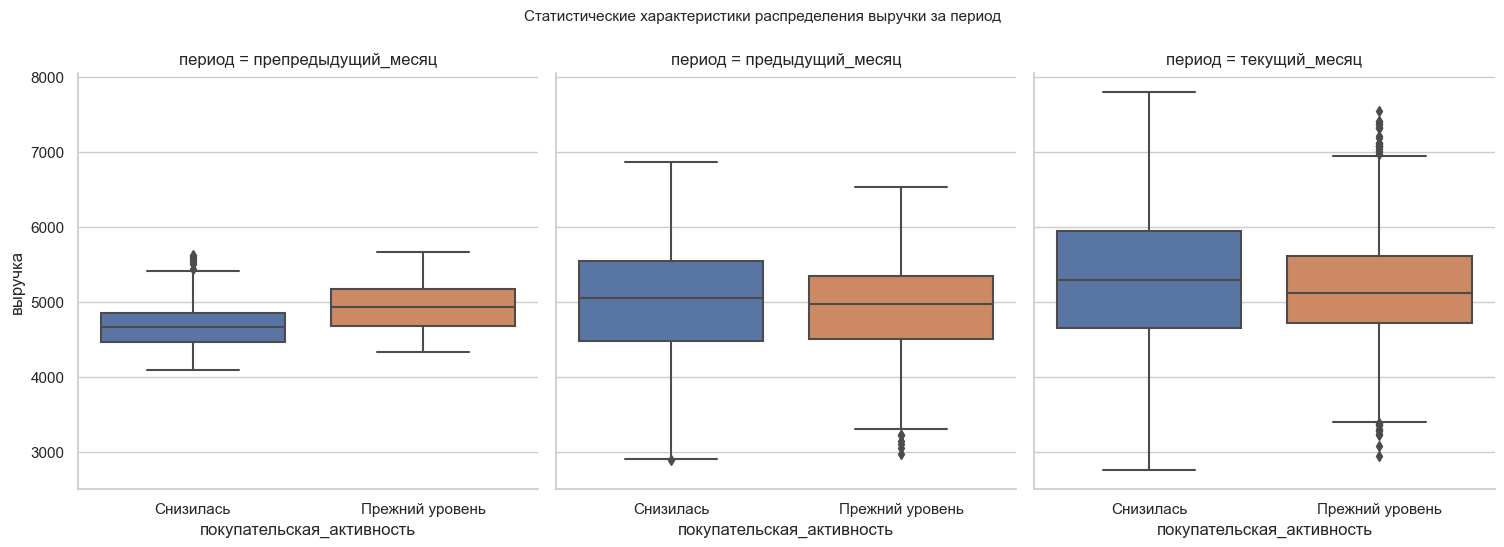

In [94]:
col_order = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']
sns.catplot(data=df, y='выручка', x='покупательская_активность', col='период', kind='box', col_order=col_order);
# заголовок
plt.suptitle('Статистические характеристики распределения выручки за период', y=1.05, fontsize=11);

**Исследование выручки с покупателя по периодам в разрезе классов "Снизилась" и "Прежний уровень":**   
* **Препредыдущий период:**             
Распределение выручки более сжато по сравнению с другими периодами, то есть несет меньший риск недополучения выручки с покупателя для каждого из классов.    
В среднем выручка в этом периоде для класса "Прежний уровень" (медиана - 4927 руб., среднее - 4933 руб.) выше, чем для класса "Снизилась" (медиана - 4668 руб., среднее - 4678 руб.).    
* **Предыдущий период:**          
Распределение выручки стало иметь более широкие границы для каждого из классов, но для класса "Снизилась" границы шире, что говорит о большем риске недополучения запланированной выручки с покупателя.  При этом медианное значение суммы выручки в классе "Снизилась" (5053 руб.) выше, чем в классе "Прежний уровень" (4977 руб.).    
* **Текущий месяц:**        
В текущем месяце риски недополучения запланированной прибыли с покупателя возросли, что связано с большим разбросом значений вокруг средней выручки. Медианная выручка в текущем месяце выше для обоих классов по сравнению с предыдущими месяцами (5294 руб. для класса "Снизилась", 5123 руб. для класса "Прежний уровень"). Большему риску соответсвует больший доход. Медианная выручка в классе "Снизилась" ((5294 руб.) выше медианной выручки класса "Прежний уровень" (5123 руб.). 

### Исследовательский анализ данных. Датафрейм "market_time"

#### Исследование количества минут на сайте за период

**Представим распределение количества минут на сайте за период в виде гистограммы и ящика с усами для сравнения за разные периоды сначала без деления на классы по целевому признаку, затем - с делением.**    

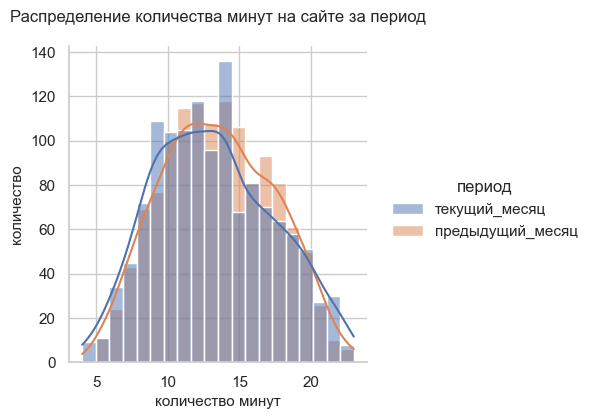

In [95]:
sns.displot(data=market_time, x='минут', hue='период', kde=True, bins=20, height=4, aspect=1);
# Подписи осей
plt.xlabel('количество минут', fontsize=11)
plt.ylabel('количество', fontsize=11)
# Заголовок
plt.title('Распределение количества минут на сайте за период', y=1.05);

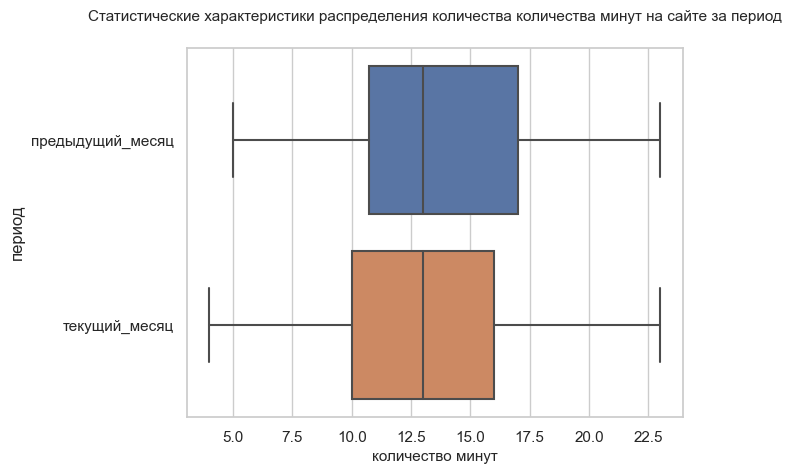

In [96]:
order = ['предыдущий_месяц', 'текущий_месяц']
sns.boxplot(x='минут', y='период', data=market_time, showfliers=True, order=order); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения количества количества минут на сайте за период', y=1.05, fontsize=11);
# подпись оси
plt.xlabel('количество минут', fontsize=11);

In [97]:
# группировка по периодам, вычисление среднего, медианного, общего количества минут и указание количества объектов в периоде
market_time.groupby('период')['минут'].agg(['mean','median', 'sum', 'count'])

mean  median    sum  count
период                                           
предыдущий_месяц  13.470679      13  17458   1296
текущий_месяц     13.210648      13  17121   1296

**Распределение количества минут на сайте за текущий и предыдущий месяц имеет схожие характеристики. Медианное количество минут совпадает.**

**Исследуем количество минут на сайте, проведенных покупателем, по периодам в разрезе классов графически, но для наглядности также получим числовую таблицу по среднему и общему количеству минут.**

In [98]:
# создаем датафрейм, содержащий количество минут и покупательскую активность
df = market_time.set_index('id').join(market_file.set_index('id')[['покупательская_активность']])
# группируем по периодам и покупательской активности и рассчитываем аггрегирующие значения для столбца минут
df.groupby(['период', 'покупательская_активность'])['минут'].agg(['mean','median', 'sum', 'count', 'std'])

mean  median    sum  count  \
период           покупательская_активность                                    
предыдущий_месяц Прежний уровень            15.029925      15  12054    802   
                 Снизилась                  10.939271      10   5404    494   
текущий_месяц    Прежний уровень            14.604738      15  11713    802   
                 Снизилась                  10.947368      10   5408    494   

                                                 std  
период           покупательская_активность            
предыдущий_месяц Прежний уровень            3.352991  
                 Снизилась                  3.476428  
текущий_месяц    Прежний уровень            4.064355  
                 Снизилась                  3.418311

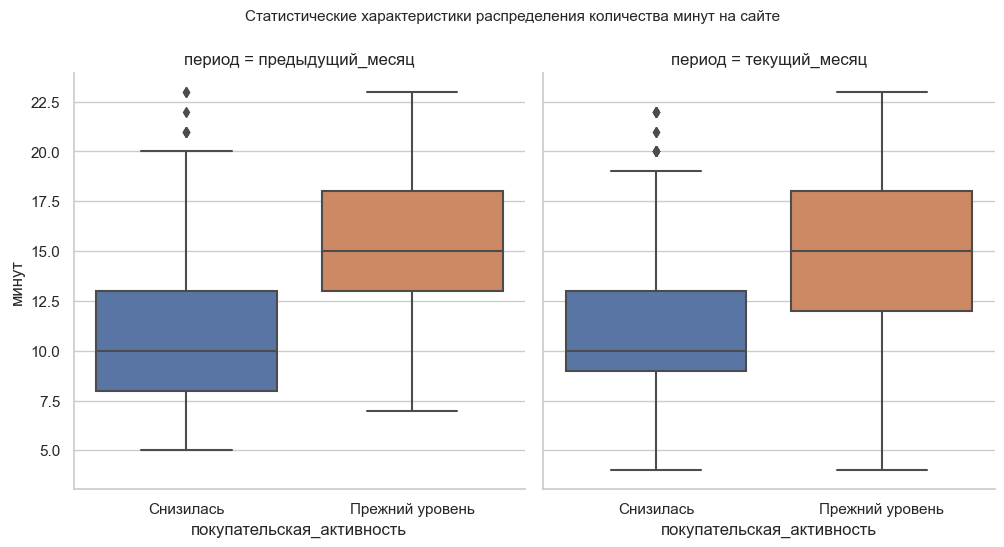

In [99]:
col_order = ['предыдущий_месяц', 'текущий_месяц']
sns.catplot(data=df, y='минут', x='покупательская_активность', col='период', kind='box', col_order=order);
# заголовок
plt.suptitle('Статистические характеристики распределения количества минут на сайте', y=1.05, fontsize=11);

**Исследование количества минут на сайте за период в разрезе классов "Снизилась" и "Прежний уровень":**
* Статистические характеристики количества минут на сайте для класса "Снизилась" за текущий и предыдущий месяц не сильно отличаются: медианное время совпадает (10 мин.), разброс значений вокруг среднего отличается незначительно (стандартное отклонение=3.48 мин. за предыдущий месяц и 3.42 мин. за текущий месяц).      
* Аналогично для класса "Прежний уровень": медианное время совпадает (15 мин.), разброс значений вокруг среднего в текущем месяце слегка возрос (стандартное отклонение=3.35 мин. за предыдущий месяц и 4.06 мин. за текущий месяц).   
* В среднем покупатели со сниженной покупательской активностью проводят меньше врени на сайте, чем покупатели с прежней активностью.

### Исследовательский анализ данных. Датафрейм "money"

#### Исследование распределения среднемесячной прибыли с покупателя за последние 3 месяца

In [100]:
# создаем датафрейм, содержащий прибыль и покупательскую активность
df = money.set_index('id').join(market_file.set_index('id')[['покупательская_активность']])
# группируем по покупательской активности и рассчитываем аггрегирующие значения для столбца прибыль
df.groupby(['покупательская_активность'])['прибыль'].agg(['mean','median', 'sum', 'count', 'std'])

mean  median      sum  count       std
покупательская_активность                                            
Прежний уровень            3.995574    4.04  3204.45    802  1.032618
Снизилась                  4.001154    4.05  1976.57    494  0.976446

Средние и медианные значения прибыли для классов "Снизилась" и "Прежний уровень" примерно одинаковы. При этом разброс значений вокруг средней выручки слегка выше для покупателей с прежней покупательской активностью.

**Представим распределение среднемесячной прибыли с покупателя за последние 3 месяца в виде гистограммы.**    

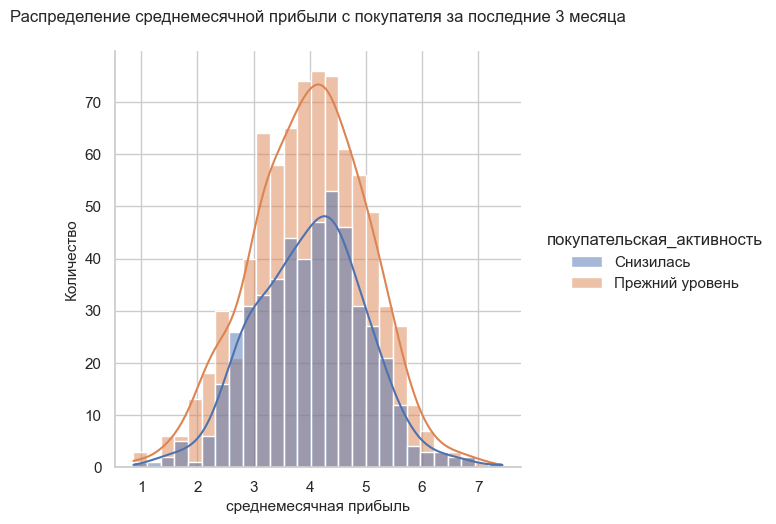

In [101]:
sns.displot(data=df, x='прибыль', hue='покупательская_активность', kde=True);
# Подписи осей
plt.xlabel('среднемесячная прибыль', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение среднемесячной прибыли с покупателя за последние 3 месяца', y=1.05);

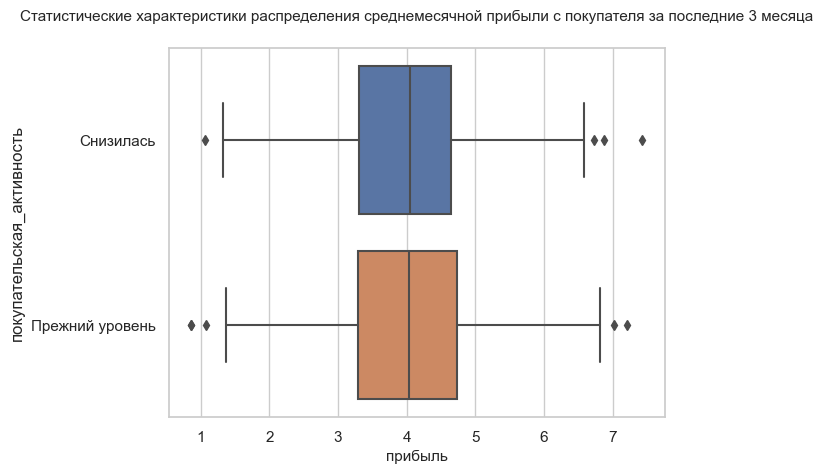

In [102]:
sns.boxplot(x='прибыль', data=df, y='покупательская_активность', showfliers=True); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения среднемесячной прибыли с покупателя за последние 3 месяца', y=1.05, fontsize=11);
# подпись оси
plt.xlabel('прибыль', fontsize=11);

По гистограмме и ящикам boxplot видно, что распределение прибыли для двух классов имеет схожие статистические характеристики: средние значения почти совпадают, разброс вокруг средней прибыли в классе "Прежний уровень" слегка выше (то есть слегка выше риск недополучения запланированной прибыли).   
По гистограмме видно, что класс "Прежний уровень" превосходит по количеству класс "Снизилась".

### Итоговый вывод по исследовательскому анализу данных

**Исследование класса покупательской активности:**    
Покупательская активность осталась на прежнем уровне у 802 покупателей (61.9%).    
Покупательская активность снизилась у 494 покупателей (38.1%).      

**Исследование типа сервиса:**    
922 покупателя (71.1%) относятся к сервису "стандарт".      
375 покупателей (28.9%) относятся к сервису "премиум".

**Исследование покупательской активности в зависимости от типа сервиса:**    
Для типа сервиса "премиум" 45% (168 покупателей) в классе "Снизилась", 55% (206 покупателей) в классе "Прежний уровень".         
Для типа сервиса "стандарт" 35% (326 покупателей) в классе "Снизилась", 65% (596 покупателей) в классе "Прежний уровень".

**Исследование популярной категории:**             
* Товары для детей - 329 покупателей (25.4%).
* Домашний текстиль - 250 покупателей (19.3%).
* Косметика и аксессуары - 223 покупателя (17.2%).
* Техника для красоты и здоровья - 182 покупателя (14%).
* Мелкая бытовая техника и электроника - 174 покупателя (13.4%).
* Кухонная посуда - 138 покупателей (10.6%).

**Исследование покупательской активности в зависимости от популярной категории:**    
  
*Наименьшее снижение в категориях:*
* "Мелкая бытовая техника и электроника" (16%, 27 покупателей).
* "Техника для красоты и здоровья" (27%, 50 покупатель).
   
*Наибольшее снижение в категориях:*
* "Кухонная посуда" (48%, 66 покупателей).
* "Косметика и аксессуары" (47%, 105 покупателей).
* "Товары для детей" (44%, 145 покупателей).
* "Домашний текстиль" (40%, 101 покупатель).

**Исследование признака согласия по рассылке:**              
* Согласны - 959 покупателей (74%).       
* Не согласны - 337 покупателей (26%).

**Исследование покупательской активности в зависимости от согласия покупателя на дополнительную рассылку о предложениях по товарам:**    
* Произошло одинаковое снижение покупательской активности (38%) в относительных величинах в классах разрешить сообщать и не разрешать сообщение.   
* Покупательская активность снизилась у 38% покупателей (368 человек) среди давших разрешение на отправку предложений о товаре.    
* Покупательская активность снизилась у 37% покупателей (126 человек) среди недавших разрешение на отправку предложений о товаре.  

**Исследование покупательской активности в зависимости от общего числа неоплаченных товаров в корзине за последние 3 месяца:**   
Наибольшее снижение в относительных величинах пришлось на покупателей, имеющих от 6 до 10 товаров в корзине:       
10 неоплаченных товаров - снижение 100% (4 чел.)           
9  неоплаченных товаров - снижение 100% (10 чел.)       
8  неоплаченных товаров - снижение 95% (19 чел.)       
7  неоплаченных товаров - снижение 94% (32 чел.)         
6  неоплаченных товаров - снижение 93% (41 чел.)         
5  неоплаченных товаров - снижение 53% (71 чел.)   
4  неоплаченных товара -  снижение 38% (75 чел.)       
3  неоплаченных товаров - снижение 33% (72 чел.)       
2  неоплаченных товаров - снижение 94% (32 чел.)         
1  неоплаченный товар -   снижение 23% (61 чел.)   
0  неоплаченный товаров - снижение 25% (29 чел.)  

**36% покупателей в классе "Снизилась" имеют неоплаченные товары за последний квартал в количестве более или равном 5.**    
Для стимулирования продаж интернет-магазину будет полезно напоминать покупателю, если он согласен на рассылку, что на товар в корзине действуют дополнительные скидки и количество оставшихся товаров.

**Исследование маркетинговых коммуникаций за последние 6 месяцев в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение маркетинговых коммуникаций в классе "Снизилась" - 3.9 меньше, чем в классе "Прежний уровень" (4.4).
- 25% покупателей с наименьшим средним числом маркетинговых коммуникаций в классе "Снизилась" - от 1.1 до 3.1, в классе "Прежний уровень" - от 2.1 до 4.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют среднее число маркетинговых коммуникаций - от 3.1 до 4.4, в классе "Прежний уровень" - от 4 до 5.3.
- 25% покупателей с наибольшим средним числом маркетинговых коммуникаций в классе "Снизилась" - от 4.4 до 6.35, в классе "Прежний уровень" - от 5.3 до 6.6.           
**В классе "Снизилась" более широкий диапазон значений маркетинговых коммуникаций. В классе "Прежний уровень" более сжатое распределение маркетинговых коммуникаций.**   

**В среднем у покупателей со сниженной покупательской активностью меньшее значение маркетинговых коммуникаций, чем у покупателей с прежней покупательской активностью.**

**Исследование количества дней с момента регистрации покупателя на сайте в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение количества дней с момента регистрации покупателя на сайте в классе "Снизилась" - 637 больше, чем в классе "Прежний уровень" (590).
- 25% покупателей с наименьшим количеством дней с момента регистрации в классе "Снизилась" - от 121 до 449, в классе "Прежний уровень" - от 121 до 383.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют количество дней с момента регистрации - от 449 до 813, в классе "Прежний уровень" - от 383 до 799.
- 25% покупателей с наибольшим количеством дней с момента регистрации  в классе "Снизилась" - от 813 до 1079, в классе "Прежний уровень" - от 799 до 1061.         

**В среднем в классе "Снизилась" более давние клиенты по сравнению с классом "Прежний уровень".**

**При исследовании доли акционных покупок обнаружено 2 сегмента: с высокой и низкой долей акционных покупок. При этом в каждом сегменте есть представители 2 классов: Снизилась и Прежний уровень.**   
Снижение покупательской активности сильно затронуло сегмент с высокой долей акционных покупок, если рассматривать в относительных величинах. Однако, если рассматривать в абсолютных величинах, то сегмент с низкой долей акционных покупок имеет более высокое снижение покупательской активности. Ниже в цифрах.

**Исследование покупательской активности в зависимости от деления на сегменты по доли акционных покупок:**  

* В сегменте с высокой долей акционных покупок: покупательская активность снизилась в 80% случаев (133 покупателя), осталась на прежнем уровне - в 20% случаев (34 покупателя).     
* В сегменте с низкой долей акционных покупок: покупательская активность снизилась в 32% случаев (361 покупатель), осталась на прежнем уровне - в 68% случаев (768 покупателей). 

**Исследование акционных покупок без разбиения на сегменты по доле акционных покупок:**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение доли акционных покупок в классе "Снизилась" - 0.31 больше, чем в классе "Прежний уровень" (0.21).
- 25% покупателей с наименьшей долей акционных покупок в классе "Снизилась" - от 0.11 до 0.24, в классе "Прежний уровень" - от 0.11 до 0.15.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют долю акционных покупок - от 0.24 до 0.89, в классе "Прежний уровень" - от 0.15 до 0.26.
- 25% покупателей с наибольшей долей акционных покупок в классе "Снизилась" - от 0.89 до 0.99, в классе "Прежний уровень" - от 0.26 до 0.43.
В классе "Снизилась" более широкий диапазон значений доли акционных покупок. В классе "Прежний уровень" более сжатое распределение доли акционных покупок.   

**Исследование акционных покупок с разбиением на сегменты по доле акционных покупок:** 
* Для сегмента с высокой долей акционных покупок для класса "Прежний уровень" - более сжатое распределение доли акционных покупок, для класса "Снизилась" - более широкое распределение, при этом медианное значение примерно на одном уровне.
* Для сегмента с низкой долей акционных покупок для класса "Прежний уровень" меньшее медианное значение доли акционных покупок по сравнению с классом "Снизилась".
* **При этом есть часть клиентов с высокой долей акционных покупок, но при этом их покупательская активность не снижается.** Ниже в цифрах.    

**Исследование акционных покупок для сегмента с низкой долей акционных покупок в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1129 экземпляров данных: 361 экземпляр данных - в классе "Снизилась", 768 экземпляров данных - в классе "Прежний уровень".
- Медианное значение доли акционных покупок в классе "Снизилась" - 0.28 больше, чем в классе "Прежний уровень" (0.21).
- 25% покупателей с наименьшей долей акционных покупок в классе "Снизилась" - от 0.11 до 0.22, в классе "Прежний уровень" - от 0.11 до 0.15.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют долю акционных покупок - от 0.22 до 0.33, в классе "Прежний уровень" - от 0.15 до 0.25.
- 25% покупателей с наибольшей долей акционных покупок в классе "Снизилась" - от 0.33 до 0.4, в классе "Прежний уровень" - от 0.25 до 0.4.         
**В классе "Снизилась" более высокое медианное значение доли акционных покупок (0.28), чем в классе "Прежний уровень" (0.21)**.   

**Исследование акционных покупок для сегмента с высокой долей акционных покупок в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 167 экземпляров данных: 133 экземпляра данных - в классе "Снизилась", 34 экземпляров данных - в классе "Прежний уровень".
- Медианное значение доли акционных покупок в классе "Снизилась" - 0.94 меньше, чем в классе "Прежний уровень" (0.95).
- 25% покупателей с наименьшей долей акционных покупок в классе "Снизилась" - от 0.86 до 0.93, в классе "Прежний уровень" - от 0.92 до 0.94.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют долю акционных покупок - от 0.93 до 0.98, в классе "Прежний уровень" - от 0.94 до 0.95.
- 25% покупателей с наибольшей долей акционных покупок в классе "Снизилась" - от 0.98 до 0.99, в классе "Прежний уровень" - от 0.95 до 0.97.   
**Для сегмента с высокой долей акционных покупок для класса "Прежний уровень" - более сжатое распределение доли акционных покупок, для класса "Снизилась" - более широкое рапределение.**

**Исследование среднего количества просмотренных страниц за визит в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение количества просмотренных страниц за визит в классе "Снизилась" - 5, что значительно меньше, чем в классе "Прежний уровень" (10).
- 25% покупателей с наименьшим средним количеством просмотренных страниц за визит в классе "Снизилась" - от 1 до 3, в классе "Прежний уровень" - от 3 до 7.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют среднее количество просмотренных страниц за визит - от 0.3 до 7, в классе "Прежний уровень" - от 7 до 12.
- 25% покупателей с наибольшим количеством просмотренных страниц за визит в классе "Снизилась" - от 7 до 13, в классе "Прежний уровень" - от 12 до 19.    
**В среднем покупатели класса "Снизилась" имеют меньшее количество просмотренных страниц за визит, чем класса "Прежний уровень".**

**Исследование количества маркетинговых коммуникаций в текущем месяце  в разрезе классов "Снизилась" и "Прежний уровень":**       
В относительных величинах количество маркетинговых коммуникаций в разрезе классов "Снизилась" и "Прежний уровень" примерно одинаково. Однако в абсолютных величинах ввиду того, что класс "Прежний уровень" имеет значительно большее количество покупателей по сравнению с классом "Снизилась" - значения класса "Прежний уровень" значительно больше.    

**Исследование среднего количества просмотров категорий за визит в течение последнего месяца  в разрезе классов "Снизилась" и "Прежний уровень":**       
* В среднем среднее количество просмотров категорий за визит в классе  "Прежний уровень" выше, чем в классе "Снизилась". 
* В классе Снизилась первые 3 категории с наибольшим количеством просмотров - 2 (176 чел., 35.6%), 3 (132 чел., 26.7%), 1 (84 чел., 17%), а в классе  "Прежний уровень" - 3 (222 чел., 27.7%), 4 (200 чел., 24.9%), 5 (152 чел., 19%).

**Исследование общего числа неоплаченных товаров за последние 3 месяца в разрезе классов "Снизилась" и "Прежний уровень":**
* В классах "Снизилась" и "Прежний уровень" распределение неоплаченных товаров отличается.        
* Класс "Снизилась" более активно использует корзину для хранения интересующих товаров.
* В классе "Снизилась" примерно равномерное распределение на участке от 2 до 5 товаров в корзине: 2 товара - 80 чел., 15.6%, 3 товара - 72 чел., 14.6%, 4 товара - 75 чел., 15.2%, 5 товаров - 71 чел., 14.4%.
* Для класса "Прежний уровень" количество товаров в корзине с 1 до 8 идет на убывание: 1 товар - 200 чел., 24.9%, 2 товара - 178 чел., 22.2%, 3 товара - 145 чел., 18.1%, 4 товара - 122 чел., 15.2%, 5 товаров - 64 чел., 8%.
* Для каждого из классов есть покупатели, не имеющие неоплаченные товары в корзине: класс "Снизилась" - 29 чел., 5.9%, класс "Прежний уровень" - 87 чел., 10%.

**Во время посещения сайта у класса Прежний уровень возникает большее количество ошибок сервиса, чем у класса Снизилась. Это связано с большим количеством просмотренных страниц и категорий за визит, как было выяснено ранее.**

**Исследование количества минут на сайте за период в разрезе классов "Снизилась" и "Прежний уровень":**
* Статистические характеристики количества минут на сайте для класса "Снизилась" за текущий и предыдущий месяц не сильно отличаются: медианное время совпадает (10 мин.), разброс значений вокруг среднего отличается незначительно (стандартное отклонение=3.48 мин. за предыдущий месяц и 3.42 мин. за текущий месяц).      
* Аналогично для класса "Прежний уровень": медианное время совпадает (15 мин.), разброс значений вокруг среднего в текущем месяце слегка возрос (стандартное отклонение=3.35 мин. за предыдущий месяц и 4.06 мин. за текущий месяц).   
* В среднем покупатели со сниженной покупательской активностью проводят меньше врени на сайте, чем покупатели с прежней активностью.

**Исследование выручки с покупателя по периодам в разрезе классов "Снизилась" и "Прежний уровень":**   
* **Препредыдущий период:**             
Распределение выручки более сжато по сравнению с другими периодами, то есть несет меньший риск недополучения выручки с покупателя для каждого из классов.    
В среднем выручка в этом периоде для класса "Прежний уровень" (медиана - 4927 руб., среднее - 4933 руб.) выше, чем для класса "Снизилась" (медиана - 4668 руб., среднее - 4678 руб.).    
* **Предыдущий период:**          
Распределение выручки стало иметь более широкие границы для каждого из классов, но для класса "Снизилась" границы шире, что говорит о большем риске недополучения запланированной выручки с покупателя.  При этом медианное значение суммы выручки в классе "Снизилась" (5053 руб.) выше, чем в классе "Прежний уровень" (4977 руб.).    
* **Текущий месяц:**        
В текущем месяце риски недополучения запланированной прибыли с покупателя возросли, что связано с большим разбросом значений вокруг средней выручки. Медианная выручка в текущем месяце выше для обоих классов по сравнению с предыдущими месяцами (5294 руб. для класса "Снизилась", 5123 руб. для класса "Прежний уровень"). Большему риску соответсвует больший доход. Медианная выручка в классе "Снизилась" ((5294 руб.) выше медианной выручки класса "Прежний уровень" (5123 руб.). 

**Исследование прибыли в разрезе классов "Снизилась" и "Прежний уровень":**       
* Средние и медианные значения прибыли для классов "Снизилась" и "Прежний уровень" примерно одинаковы (среднее значение прибыли примерно 4 у.е. для обоих классов, медиана - 4.04 для класса "Снизилась" и 4.05 для класса "Прежний уровень").
* При этом разброс значений вокруг средней выручки слегка выше для покупателей с прежней покупательской активностью по сравнению с покупателями со сниженной покупательской активностью (1.03 у.е. против 0.98 у.е.).

## Объединение датафреймов market_file, market_money, market_time

### Преобразование таблиц market_money и market_time

Объединим таблицы market_file, market_money, market_time. Отметим, что размерности таблиц разные в связи с тем, что данные о выручке (market_money) и времени (market_time) на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода. Для этого вначале преобразуем таблицы market_money и market_time.

**Изменим таблицу "market_money". Посмотрим на ее размерность и внешний вид.**

In [103]:
market_money.shape

(3888, 3)

In [104]:
market_money.head(4)

id               период  выручка
0  215349  препредыдущий_месяц   4472.0
1  215349        текущий_месяц   4971.6
2  215349     предыдущий_месяц   5216.0
3  215350  препредыдущий_месяц   4826.0

В таблице для каждого клиента дана выручка за 3 периода. Сделаем для каждого периода свой столбец с выручкой и удалим столбец "период". Для этого будем использовать сводные таблицы: в строках группируем по "id", в столбцах - по периоду, в качестве значений в таблице - выручка, в качестве агрегирующей функции можно взять first, last, mean - в нашем случае значение не поменяется, так как для одного покупателя 1 строка для каждого периода. Оставим по умолчанию mean.

In [105]:
market_money_new = market_money.pivot_table(index='id', columns='период', values='выручка')
market_money_new.head(3)

период  предыдущий_месяц  препредыдущий_месяц  текущий_месяц
id                                                          
215349            5216.0               4472.0         4971.6
215350            5457.5               4826.0         5058.4
215351            6158.0               4793.0         6610.4

**Переименуем столбцы, добавив слово "выручка" к каждому из периодов.**

In [106]:
# переименовывание столбцов через list comprehension
market_money_new.columns = ['_'.join(col) for col in zip(
    ['выручка']*len(market_money_new.columns.tolist()), 
    market_money_new.columns.tolist()
)]

In [107]:
# названия столбцов
market_money_new.columns

Index(['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц',
       'выручка_текущий_месяц'],
      dtype='object')

In [108]:
market_money_new.head(3)

выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
215349                    5216.0                       4472.0   
215350                    5457.5                       4826.0   
215351                    6158.0                       4793.0   

        выручка_текущий_месяц  
id                             
215349                 4971.6  
215350                 5058.4  
215351                 6610.4

In [109]:
market_money_new.shape

(1296, 3)

**Аналогично изменим таблицу "market_time". Посмотрим на ее размерность и внешний вид.**

In [110]:
market_time.shape

(2592, 3)

In [111]:
market_time.head(3)

id            период  минут
0  215349     текущий_месяц     10
1  215349  предыдущий_месяц     12
2  215350     текущий_месяц     13

В таблице "market_time" 2 периода и соответствующее им количество минут. По аналогии сделаем для каждого периода свой столбец с минутами и удалим столбец "период". Для этого будем использовать сводные таблицы: в строках группируем по "id", в столбцах - по периоду, в качестве значений в таблице - "минут", в качестве агрегирующей функции можно взять first, last, mean - в нашем случае значение не поменяется, так как для одного покупателя 1 строка для каждого периода. Оставим по умолчанию mean.

In [112]:
market_time_new = market_time.pivot_table(index='id', columns='период', values='минут')
market_time_new.head(3)

период  предыдущий_месяц  текущий_месяц
id                                     
215349                12             10
215350                 8             13
215351                11             13

**Переименуем столбцы, добавив слово "минут" к каждому из периодов.**

In [113]:
# переименовывание столбцов через list comprehension
market_time_new.columns = ['_'.join(col) for col in zip(
    ['минут']*len(market_time_new.columns.tolist()), 
    market_time_new.columns.tolist()
)]

In [114]:
# названия столбцов
market_time_new.columns

Index(['минут_предыдущий_месяц', 'минут_текущий_месяц'], dtype='object')

In [115]:
market_time_new.head(3)

минут_предыдущий_месяц  минут_текущий_месяц
id                                                 
215349                      12                   10
215350                       8                   13
215351                      11                   13

In [116]:
market_time_new.shape

(1296, 2)

### Объединение датафреймов market_file, market_money, market_time

**Посмотрим на размерности датафреймов до объединения.**

In [117]:
market_file.shape, market_time_new.shape, market_money_new.shape

((1296, 14), (1296, 2), (1296, 3))

**Таблицы market_file, market_money_new, market_time_new имеют одинаковое количество строк. Однако проверим, есть ли в них отличающиеся id.**

In [118]:
# проверяем, что множество идентификаторов в таблицах одинаковое
set(market_time_new.index) == set(market_money_new.index) == set(market_file["id"])

True

**Мы проверили, что датафреймы содержат одинаковых покупателей (совпадают "id"). Объединим датафреймы по уникальному номеру id.**

In [119]:
market_file = market_file.set_index('id').join([market_money_new, market_time_new])
market_file.head(3)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   
215351                 Снизилась    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   

        акционные_покупки популярная_категория  \
id                                               
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   

           акционные_покупки_категории  выручка_предыдущий_месяц  \
id                                                                 
215349  высокая доля акционных покупок                    5216.0   
215350   низкая доля акционных покупок                    5457.5   
215351  высокая доля акционных покупок                    6158.0   

        выручка_препредыдущий_месяц  выручка_текущий_месяц  \
id                                                           
215349                       4472.0                 4971.6   
215350                       4826.0                 5058.4   
215351                       4793.0                 6610.4   

        минут_предыдущий_месяц  минут_текущий_месяц  
id                                                   
215349                      12                   10  
215350                       8                   13  
215351                      11                   13

**Посмотрим на размерность датафрейма после объединения.**

In [120]:
market_file.shape

(1296, 18)

**Объединение прошло успешно, уменьшение на 1 столбец, так как "id" сделали индексом.**

### Промежуточный вывод по объединению датафреймов

Таблицы market_file, market_money, market_time объединены в одну.   
Перед объединением таблиц были сделаны следующие преобразования:
* На основе таблицы "market_money" создана таблица "market_money_new", в которой для каждого периода получен свой столбец с выручкой (выручка_предыдущий_месяц, выручка_препредыдущий_месяц, выручка_текущий_месяц) и удален столбец "период".
*  На основе таблицы "market_time" создана таблица "market_time_new", в которой для каждого периода получен свой столбец с минутами (минут_предыдущий_месяц, минут_текущий_месяц) и удален столбец "период".
*  Новые таблицы и "market_file" были проверены на соответствие покупателей по "id" и объединены по "id" в одну таблицу "market_file".
*  Объединенная таблица  "market_file" содержит 1296 строк, 17 столбцов (в качестве индекса установлен "id").

## Корреляционный анализ данных

**Для чего используют коэффициент корреляции:** чтобы определить направление и силу связи между переменными. Далее с учетом коэффициента корреляции и диаграмм рассеяния отбирают признаки для построения моделей машинного обучения. Отбирают признаки наиболее сильно коррелированные с целевой переменной. При этом, если между входными признаками присутствует мультиколлинеарность (корреляция между зависимыми переменными), исключают признак с меньшей корреляцией с целевой переменной. При мультиколлинеарности на целевую переменную оказывают эффект сразу несколько признаков и невозможно точно интерпретировать каждый из них. 

**Возникает вопрос, когда какой коэффициент корреляции использовать и для чего?**   
**[Какие методы и когда можно использовать:](https://www.dmitrymakarov.ru/opt/relationship-03/#26-podvedem-itog)**   
`Для двух количественных переменных:`   
* коэффициент Пирсона, если требуется оценить линейную зависимость   
* коэффициент Спирмена и Кендалла, если требуется оценить нелинейную зависимость.  
`Для двух категориальных переменных:`
* коэффициент Спирмена и Кендалла для порядковых категорий.
* коэффициент неопределенности Тиля           
`Для количественной и категориальной переменных:`
* точечно-бисериальный коэффициент корреляции, если категориальная переменная - дихотомическая (имеет 2 значения)
* корреляционное отношение в общем случае (в случае множества категорий).
          
При этом стоит отметить, что коэффициент корреляции Пирсона - это параметрический тест, то есть измеряет взаимосвязь количественных переменных в предположении, что обе переменные имеют нормальное распределение. Коэффициенты Спирмена и Кендалла - непараметрические тесты, то есть не предполагают каких-либо допущений о распределении генеральной совокупности, из которой взяты выборки. На практике это означает, что, если допущения параметрического теста не выполняются, его результат нельзя считать достоверным. Для непаметрического теста такое допущение отсутствует.

Таким образом для переменных разного типа с разным распределением используется разная методология расчета коэффициента корреляции. Это усложняет корреляционный анализ. Однако на текущий момент разработан новый коэффициент корреляции [phi_K для расчета матрицы корреляций переменных смешанного типа](https://arxiv.org/abs/1811.11440).

phi_K - практический коэффициент корреляции, основанный на нескольких уточнениях проверки гипотезы Пирсона о независимости двух переменных. Объединенные функции  phi_K формируют преимущество перед существующими коэффициентами. Во-первых, он работает согласованно между категориальными, порядковыми и интервальными переменными. Во-вторых, он фиксирует нелинейную зависимость. В-третьих, он возвращается к коэффициенту корреляции Пирсона в случае двунаправленного нормального входного распределения. Это полезные функции при изучении корреляции между переменными смешанных типов. Особое внимание уделяется надлежащей оценке статистической значимости корреляций. Реализован в библиотеке Python - [phik.](https://nbviewer.org/github/KaveIO/PhiK/blob/master/phik/notebooks/phik_tutorial_basic.ipynb)

**Наша цель - построение моделей машинного обучения, поэтому отбор признаков и проверку [мультиколлинеарности](https://www.dmitrymakarov.ru/opt/mlr-04/#10-4-otsutstvie-multikollinearnosti) проведем с помощью коэффициентов корреляции  phi_K.**     
**Этот анализ поможет нам в случае добавления признаков в модель либо их удаления из модели.**

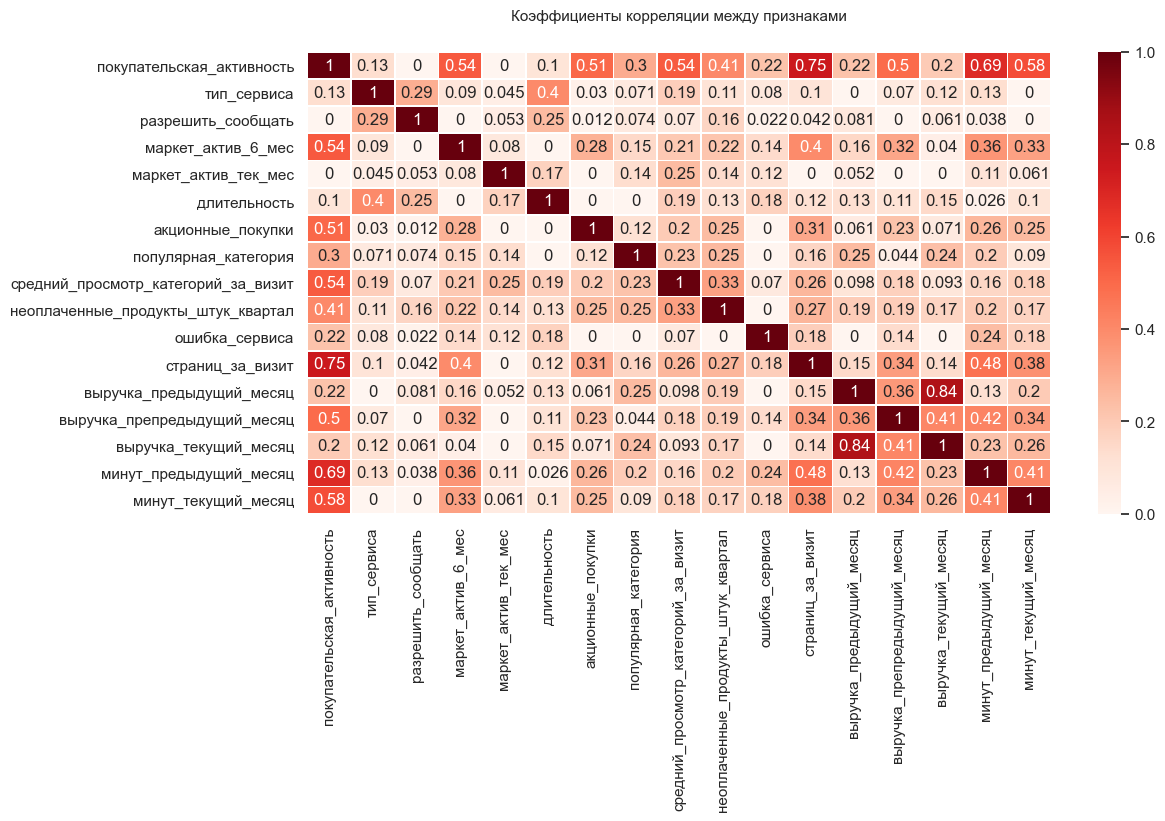

In [121]:
# задаем размер и четкость-количество точек на дюйм
plt.figure(dpi=100, figsize=(12,6))
# Заголовок
plt.title('Коэффициенты корреляции между признаками', y=1.05, fontsize=11);
# столбцы с непрерывными переменными
interval_cols = ['маркет_актив_6_мес', 'длительность', \
'акционные_покупки', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', \
'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
# визуализация с помощью тепловой карты
sns.heatmap(market_file.drop(columns='акционные_покупки_категории').phik_matrix(interval_cols=interval_cols), \
            linewidth=0.5, cmap='Reds', annot=True);

Посмотрим, какие признаки влияют на целевую переменную более всего.

**Взаимосвязь между целевым (покупательская_активность) и входными признаками.**         
**Показатели коррелированности по [шкале Чеддока](https://math.semestr.ru/corel/cheddok.php):**     
**Весьма высокая (0.9-1):**      
- нет.     
**Высокая корреляция (0.7-0.9):**       
- между покупательской активностью и средним количеством просмотренных страниц за визит (коэффициент корреляции 0.75).       
**Заметная корреляция (0.5-0.7):**             
- между покупательской активностью и количеством минут на сайте за предыдущий месяц (коэффициент корреляции 0.69).      
- между покупательской активностью и количеством минут на сайте за текущий месяц (коэффициент корреляции 0.58).             
- между покупательской активностью и средним просмотром категорий за визит в течение последнего месяца (коэффициент корреляции 0.54).              
- между покупательской активностью и средним значением маркетинговых коммуникаций за последние 6 месяцев (коэффициент корреляции 0.54).             
- между покупательской активностью и среднемесячной долей акционных покупок за последние 6 месяцев (коэффициент корреляции 0.51).          
- между покупательской активностью и суммой выручки за препредыдущий месяц (коэффициент корреляции 0.5) - граничное значение между умеренной и заметной корреляцией.         
**Умеренная корреляция (0.3-0.5):**               
- между покупательской активностью и общим числом неоплаченных товаров за последние 3 месяца (коэффициент корреляции 0.41).         
- между покупательской активностью и популярной категорией за последние 6 месяцев (коэффициент корреляции 0.3) - граничное значение между слабой и умеренной корреляцией.         
**Слабая корреляция (0.1-0.3):**                  
- между покупательской активностью и суммой выручки за предыдущий месяц (коэффициент корреляции 0.22).      
- между покупательской активностью и количеством сбоев во время посещения сайта (ошибка_сервиса) (коэффициент корреляции 0.22).          
- между покупательской активностью и суммой выручки за текущий месяц (коэффициент корреляции 0.2).           
- между покупательской активностью и типом сервиса (коэффициент корреляции 0.13).           
- между покупательской активностью и количеством дней с момента регистрации покупателя на сайте (коэффициент корреляции 0.1) -  граничное значение между "практически отсутствует" и слабой корреляцией.              
**Практически отсутствует (0-0.1):**                  
- между покупательской активностью и количество маркетинговых коммуникаций в текущем месяце (коэффициент корреляции 0).       
- между покупательской активностью и согласием покупателя на рассылку (разрешить_сообщать) (коэффициент корреляции 0).         

**Посмотрим, как связаны между собой входные признаки.**

**`Распределим коэффициенты корреляции между входными признаками в группы, начиная с коэффициента корреляции 0.7 и выше.`**    
**Показатели коррелированности по [шкале Чеддока](https://math.semestr.ru/corel/cheddok.php):**     
**Весьма высокая (0.9-1):**      
- нет.     
**Высокая корреляция (0.7-0.9):**
- между выручкой за предыдущий месяц и выручкой за текущий месяц (коэффициент корреляции 0.84).     

* **Как правило, о мультиколинеарности (высокой корреляции между зависимыми переменными) говорят `при коэффициенте корреляции от 0.9 и выше по модулю`. И это относится к числовым переменным, то есть между ними можно построить линейную зависимость.** В такой ситуации лишние коррелирующие признаки необходимо удалить из обучающей выборки.
* Сильно коррелированные друг с другом переменные дают модели одну и ту же информацию. Следовательно, для анализа не нужно использовать их все. В таком случае в модели нужна только одна из таких переменных.
* Однако также может случиться, что несколько переменных с высокой корреляцией фактически добавляют информацию, которая должна быть использована. 
* В нащем случае, **между выручкой за предыдущий месяц и выручкой за текущий месяц (коэффициент корреляции 0.84) существует сильная зависимость. Будет ли она помехой при построении моделей машинного обучения проверим далее, построив модели с этими признаками вместе и с каждым из них по-отдельности.**

Некоторые эксперты отмечают, что **мультиколлинеарность может возникать [при коэффициентах корреляции > 0.7](https://yandex.ru/q/machine-learning/9208212225/).** Диагностировать мультиколлинеарность можно 2 способами: 
* [заметные изменения в расчетных коэффициентах регрессии путем добавления или удаления входного признака ](https://yandex.ru/q/machine-learning/9208212225/)
* [коэффициент увеличения дисперсии VIF позволяет выявить корреляцию между признаками модели](https://www.dmitrymakarov.ru/opt/mlr-04/#11-variance-inflation-factor)

## Моделирование с использованием пайплайнов

### Построение пайплайна со всеми входными признаками

In [122]:
# market_file - используемый датафрейм для обучения, кросс-валидации и тестирования модели
target = 'покупательская_активность'   # целевая переменная

In [123]:
# выделение входных признаков X и целевого признака y
X = market_file.drop([target, 'акционные_покупки_категории'], axis=1)
y = market_file[target]

**Входные признаки X разобъем на числовые и категориальные, при этом выделим отдельно категориальные столбцы для кодировщика номинальных переменных - OneHotEncoder и для кодировщика порядковых переменных - OrdinalEncoder.**

**Посмотрим на числовые столбцы.**

In [124]:
market_file.select_dtypes(include='number').columns.tolist()

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'выручка_предыдущий_месяц',
 'выручка_препредыдущий_месяц',
 'выручка_текущий_месяц',
 'минут_предыдущий_месяц',
 'минут_текущий_месяц']

**Оставим все эти числовые столбцы. По мере необходимости их можно подредактировать и какой-нибудь удалить (например, входные признаки с высокой корреляцией либо признаки, у которых коррелированность с целевой переменной практически отсутствует, либо признаки, которые оказались наименее важными при построении модели).**

**Посмотрим на категориальные столбцы.**

In [125]:
market_file.drop('покупательская_активность', axis=1).select_dtypes(exclude='number').columns.tolist() 

['тип_сервиса',
 'разрешить_сообщать',
 'популярная_категория',
 'акционные_покупки_категории']

In [126]:
market_file['тип_сервиса'].unique() # уникальные категории

array(['премиум', 'стандарт'], dtype=object)

In [127]:
market_file['разрешить_сообщать'].unique() # уникальные категории

array(['да', 'нет'], dtype=object)

In [128]:
market_file['популярная_категория'].unique() # уникальные категории

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
       'Кухонная посуда', 'Техника для красоты и здоровья',
       'Мелкая бытовая техника и электроника'], dtype=object)

**Категории у номинальных признаков 'разрешить_сообщать' и 'популярная_категория' нельзя упорядочить, поэтому для них будем использовать кодирование с помощью OneHotEncoder. Входной признак 'тип_сервиса' содержит категории, которые можно упорядочить. Для 'тип_сервиса' будем использовать кодирование OrdinalEncoder.**

In [129]:
# создаём списки с названиями признаков
ohe_columns = ['разрешить_сообщать', 'популярная_категория'] # столбцы для OneHotEncoder
ord_columns = ['тип_сервиса'] # столбцы для OrdinalEncoder

# числовые столбцы для масштабирования и кодирования
num_columns = market_file.select_dtypes(include='number').columns.tolist() 

In [130]:

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)

In [131]:
X_train.shape, X_test.shape 

((972, 16), (324, 16))

In [132]:
# создайте экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# обучите модель и трансформируйте тренировочную выборку 
y_train = label_encoder.fit_transform(y_train)

# трансформируем тестовую выборку
y_test = label_encoder.transform(y_test)

Отсортированные классы можно посмотреть с помощью атрибута classes_:

In [133]:
print(label_encoder.classes_) 

['Прежний уровень' 'Снизилась']


Узнать, к какому классу относится число, можно, используя метод inverse_transform():

In [134]:
print(label_encoder.inverse_transform([0, 1])) 

['Прежний уровень' 'Снизилась']


**Выберем подходящую метрику для нашей задачи.**    

**Как выбрать метрику:**           
* Accuracy - когда данные хорошо сбалансированы, доля объектов каждого класса примерно равна доле остальных.            
* Recall - когда необходимо не пропускать объекты класса 1.             
* Precision - когда необходимо присваивать класс 1 без ошибок.          
* F1-score - когда необходимо при оценке модели учитывать как recall, так и precision. Метрики можно учесть в равной степени или отдать приоритет одной из них.          
* ROC-AUC	- когда необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.          

**Выберем для нашей задачи ROC-AUC. Это площадь под ROC-кривой. Она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения. Поэтому она не зависит от того, какой порог мы выберем. Это самая общая оценка итогов работы модели. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.**

In [135]:
#-------------------------------------------------------------------------------

# создаём пайплайн для подготовки признаков из списка ohe_columns:  OHE-кодирование

ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: Ordinal-кодирование
#-------------------------------------------------------------------------------
ord_pipe = Pipeline(
    [
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
             ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        )
     
    ]
)
#-------------------------------------------------------------------------------
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)
#-------------------------------------------------------------------------------
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
#-------------------------------------------------------------------------------
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),  
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(2, 5),
        # указываем список методов масштабирования
          
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga', 
            penalty='l1'
        )],
        'models__C': [0.5, 0.8, 1, 3],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
        # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE, probability= True)],
      
        'models__kernel': ['rbf','sigmoid', 'linear', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
   
    
]
#-------------------------------------------------------------------------------
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
    
)
#-------------------------------------------------------------------------------
randomized_search.fit(X_train, y_train)

#-------------------------------------------------------------------------------
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search.best_score_)
#-------------------------------------------------------------------------------
# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred_proba = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                 

In [136]:
randomized_search.best_params_

{'preprocessor__num': MinMaxScaler(),
 'models__C': 0.8,
 'models': LogisticRegression(penalty='l1', random_state=42, solver='saga')}

Таким образом, мы получили гиперпараметры лучшей модели, которой оказалась LogisticRegression(penalty='l1', C=0.8, random_state=42, solver='saga'). 

### Попытки улучшения метрики модели за счет отбора признаков

#### Вывод коэффициентов значимости для лучшей модели

**Пайплайн готов. Сделаем одно наблюдение. Итоговый пайплайн pipe_final включает в себя промежуточный пайплайн data_preprocessor. Мы можем работать не только с итоговой моделью, но и с промежуточными результатами пайплайна. Покажем на примере расчета значимости коэффициентов логистической регрессии.**

In [137]:
'''
Пайплайн data_preprocessor применяется к тренировочной и тестовой выборкам. 
1. Пайплайн data_preprocessor применяется к выборке X_train.
2. Затем обученный на тренировочных данных data_preprocessor применяется к выборке X_test.
3. Для обеих выборок создаём датафрейм с обозначением названия признаков после подготовки. 

Название признаков выводим с помощью команды get_feature_names_out() 
Эту и другие команды можно посмотреть в документации 
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
'''

X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()    
) 

In [138]:
X_train_p.head(2)

ohe__разрешить_сообщать_нет  \
0                          0.0   
1                          0.0   

   ohe__популярная_категория_Косметика и аксессуары  \
0                                               0.0   
1                                               0.0   

   ohe__популярная_категория_Кухонная посуда  \
0                                        0.0   
1                                        0.0   

   ohe__популярная_категория_Мелкая бытовая техника и электроника  \
0                                                             1.0   
1                                                             0.0   

   ohe__популярная_категория_Техника для красоты и здоровья  \
0                                                       0.0   
1                                                       1.0   

   ohe__популярная_категория_Товары для детей  ord__тип_сервиса  \
0                                         0.0               0.0   
1                                         0.0               0.0   

   num__маркет_актив_6_мес  num__маркет_актив_тек_мес  num__длительность  \
0                 0.807018                        0.5           0.406054   
1                 0.736842                        0.5           0.081420   

   num__акционные_покупки  num__средний_просмотр_категорий_за_визит  \
0                0.045455                                       0.2   
1                0.136364                                       0.6   

   num__неоплаченные_продукты_штук_квартал  num__ошибка_сервиса  \
0                                      0.4             0.777778   
1                                      0.5             0.222222   

   num__страниц_за_визит  num__выручка_предыдущий_месяц  \
0               0.789474                       0.573062   
1               0.105263                       0.882020   

   num__выручка_препредыдущий_месяц  num__выручка_текущий_месяц  \
0                          0.159105                    0.645843   
1                          0.318850                    0.204535   

   num__минут_предыдущий_месяц  num__минут_текущий_месяц  
0                     0.833333                  0.105263  
1                     0.333333                  0.473684

In [139]:
X_test_p.head(2)

ohe__разрешить_сообщать_нет  \
0                          0.0   
1                          1.0   

   ohe__популярная_категория_Косметика и аксессуары  \
0                                               0.0   
1                                               0.0   

   ohe__популярная_категория_Кухонная посуда  \
0                                        0.0   
1                                        0.0   

   ohe__популярная_категория_Мелкая бытовая техника и электроника  \
0                                                             0.0   
1                                                             0.0   

   ohe__популярная_категория_Техника для красоты и здоровья  \
0                                                       1.0   
1                                                       0.0   

   ohe__популярная_категория_Товары для детей  ord__тип_сервиса  \
0                                         0.0               0.0   
1                                         1.0               1.0   

   num__маркет_актив_6_мес  num__маркет_актив_тек_мес  num__длительность  \
0                 0.561404                        0.5           0.506263   
1                 0.087719                        0.5           0.587683   

   num__акционные_покупки  num__средний_просмотр_категорий_за_визит  \
0                0.045455                                       1.0   
1                0.943182                                       0.4   

   num__неоплаченные_продукты_штук_квартал  num__ошибка_сервиса  \
0                                      0.1             0.444444   
1                                      0.6             0.111111   

   num__страниц_за_визит  num__выручка_предыдущий_месяц  \
0               0.578947                       0.272145   
1               0.263158                       0.165347   

   num__выручка_препредыдущий_месяц  num__выручка_текущий_месяц  \
0                          0.520128                    0.105243   
1                          0.356550                    0.280120   

   num__минут_предыдущий_месяц  num__минут_текущий_месяц  
0                     0.611111                  0.684211  
1                     0.333333                  0.263158

**Эти промежуточные датафреймы мы можем использовать. Покажем, как использовать X_train_p.**

**Часто один или несколько признаков наиболее значимы для модели. Метод логистической регрессии надёжно их выявляет, потому что он основан на точном расчёте значений коэффициентов. Коэффициенты модели для логит-функции можно посмотреть, используя атрибут coef_. Коэффициенты в coef_ расположены в том же порядке, что и переданные методу fit признаки.** 

**Гиперпараметры лучшей модели мы получили выше. Используем их при инициализации модели. А обучение  проводим с использованием результатов промежуточного пайплайна data_preprocessor - X_train_p (входные признаки обработаны: результаты масштабирования, кодирования).**

In [140]:
model = LogisticRegression(penalty='l1', random_state=42, solver='saga', C=0.8)
# используем результаты промежуточного пайплайна data_preprocessor
model = model.fit(X_train_p, y_train)

In [141]:
model.coef_

array([[-0.0651407 ,  0.        ,  0.        , -0.89267187, -0.39307141,
        -0.04387578,  0.        , -2.15206796,  0.        ,  0.17065361,
         2.0158631 , -2.16296868,  2.38744038, -0.34016555, -3.04454789,
         0.        , -0.81677729,  0.        , -2.55736773, -2.02133635]])

**Выведем коэффициенты в читаемом виде - в соответствии с признаком, перед которым он стоит.**

In [142]:
# выводим экспоненциальные веса коэффициентов после экспоненцирования 
# так делают, чтобы избавиться от логарифма в логит-функции, это позволяет интерпретировать коэффициенты 
# в соответствии с теорией шансов
rez=[]
for feature_number, feature_name in enumerate(num_columns+ohe_columns+ord_columns):
    weight = model.coef_[0, feature_number]
    rez.append((feature_name, weight))
pd.DataFrame(rez, columns=['feature', 'significance']).set_index('feature').sort_values(by='significance', ascending=False)  

significance
feature                                          
минут_текущий_месяц                      2.387440
выручка_текущий_месяц                    2.015863
выручка_препредыдущий_месяц              0.170654
маркет_актив_тек_мес                     0.000000
длительность                             0.000000
ошибка_сервиса                           0.000000
выручка_предыдущий_месяц                 0.000000
тип_сервиса                              0.000000
неоплаченные_продукты_штук_квартал      -0.043876
маркет_актив_6_мес                      -0.065141
разрешить_сообщать                      -0.340166
средний_просмотр_категорий_за_визит     -0.393071
акционные_покупки                       -0.892672
страниц_за_визит                        -2.152068
минут_предыдущий_месяц                  -2.162969
популярная_категория                    -3.044548

**Это коэффициенты-веса в логит-функции, поэтому их сложно интерпретировать. При помощи l1-регуляризации некоторые коэффициенты обнулились. Далее будем производить интерпретацию с помощью shap-визуализации.**

#### Выборочное удаление признаков для лучшей модели вручную

**Покажем 2 варианта уменьшения признакового пространства: вручную и через SelectKBest.**

Ранее при при проведении корреляционного анализа было обнаружено, что 2 входных признака имеют сильную корреляцию: выручка за текущий период и выручка за предыдущий период (0.84). Удалим один из них и посмотрим, как это повлияет на roc_auc_score лучшей модели. Сначала удалим выручку за предыдущий месяц, так как этот признак оказался менее важным при построении модели. Посмотрим на метрику. А затем, наоборот, оставим выручку за предыдущий месяц и удалим выручку за текущий месяц, так как между покупательской активностью и выручкой за текущий меcяц слегка меньше корреляция (phi_K=0.2),  чем между покупательской активностью и выручкой за предыдущий меcяц (phi_K=0.22).

**Метрика при удалении выручки за предыдущий месяц**

In [143]:
model = LogisticRegression(penalty='l1', C=0.8, random_state=42, solver='saga')
# используем результаты промежуточного пайплайна data_preprocessor
model = model.fit(X_train_p.drop('num__выручка_предыдущий_месяц', axis=1), y_train)
y_test_proba_del_prev = model.predict_proba(X_test_p.drop('num__выручка_предыдущий_месяц', axis=1))[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba_del_prev)}')

Метрика ROC-AUC на тестовой выборке: 0.9189014278202482


**Метрика на тестовой выборке не изменилась.**

**Метрика при удалении выручки за текущий месяц**

In [144]:
model = LogisticRegression(penalty='l1', C=0.8, random_state=42, solver='saga')
# используем результаты промежуточного пайплайна data_preprocessor
model = model.fit(X_train_p.drop('num__выручка_текущий_месяц', axis=1), y_train)
y_test_proba_del_prev = model.predict_proba(X_test_p.drop('num__выручка_текущий_месяц', axis=1))[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba_del_prev)}')

Метрика ROC-AUC на тестовой выборке: 0.9189014278202482


**Метрика на тестовой выборке не изменилась.**

**Метрика при удалении признаков, имеющих малую значимость при построении модели.**

Можно ли сделать метрику качества еще выше, если удалить признаки, имеющие наименьшую важность. Проверим это.

Удалим признаки: "популярная_категория", "страниц_за_визит", "минут_предыдущий_месяц".

**Чтобы удалить эти столбцы, посмотрим их точные названия после обработки признаков.**

In [145]:
X_train_p.columns

Index(['ohe__разрешить_сообщать_нет',
       'ohe__популярная_категория_Косметика и аксессуары',
       'ohe__популярная_категория_Кухонная посуда',
       'ohe__популярная_категория_Мелкая бытовая техника и электроника',
       'ohe__популярная_категория_Техника для красоты и здоровья',
       'ohe__популярная_категория_Товары для детей', 'ord__тип_сервиса',
       'num__маркет_актив_6_мес', 'num__маркет_актив_тек_мес',
       'num__длительность', 'num__акционные_покупки',
       'num__средний_просмотр_категорий_за_визит',
       'num__неоплаченные_продукты_штук_квартал', 'num__ошибка_сервиса',
       'num__страниц_за_визит', 'num__выручка_предыдущий_месяц',
       'num__выручка_препредыдущий_месяц', 'num__выручка_текущий_месяц',
       'num__минут_предыдущий_месяц', 'num__минут_текущий_месяц'],
      dtype='object')

In [146]:
del_feature = ['ohe__популярная_категория_Косметика и аксессуары',
    'ohe__популярная_категория_Кухонная посуда',
    'ohe__популярная_категория_Мелкая бытовая техника и электроника',
    'ohe__популярная_категория_Техника для красоты и здоровья',
    'ohe__популярная_категория_Товары для детей', 'num__страниц_за_визит',
     'num__минут_предыдущий_месяц']     

In [147]:
model = LogisticRegression(penalty='l1', C=0.8, random_state=42, solver='saga')
# используем результаты промежуточного пайплайна data_preprocessor
model = model.fit(X_train_p.drop(del_feature, axis=1), y_train)
y_test_proba_del_prev = model.predict_proba(X_test_p.drop(del_feature, axis=1))[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba_del_prev)}')

Метрика ROC-AUC на тестовой выборке: 0.8929741536221332


**Удаление признаков, имеющих малую значимость при построении регрессии, лишь ухудшило метрику качества.**

**Если удалять признаки вручную, то лучшую метрику получили при удалении выручки за предыдущий месяц либо выручки за текущий месяц. roc_auc на тестовой выборке - 0.9182, совпадает с результатом, полученном при использовании пайплайна.**

Построим график ROC-кривой с помощью RocCurveDisplay() для модели с лучшей метрикой.

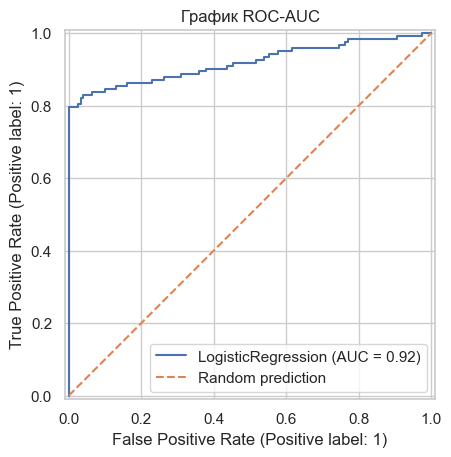

In [148]:
# обучаем модель, удалив из подготовленных данных (данные отмасштабированы, закодированы) признак с выручкой за предыдущий период
model = LogisticRegression(penalty='l1', C=0.8, random_state=42, solver='saga')
model = model.fit(X_train_p, y_train)

# выведите на экран ROC-кривую методом from_estimator()
RocCurveDisplay.from_estimator(model, X_test_p, y_test)
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.title("График ROC-AUC")
plt.legend()
plt.show()

**Объясним кривую ROC.**   
* Кривая ROC строится для различных порогов. Для каждого из порогов рассчитывается точка на графике, ей соответствуют 2 координаты: ошибка 1 рода FPR=fp/(tn+fp) и recall, его также называют TPR=tp/(tp+fn). И эта точка наносится на график. И так для всех порогов.
* Метрики измеряются от 0 до 1, что откладывается по осям.
* Точке (1, 1) соответствует минимальный порог. При минимальном пороге всем объектам проставляется класс 1. В этом случае максимальный recall=1 (100%) и максимальный FPR (так как все нули отмечены как единицы).
* Точке (0, 0) соответствует максимальный порог. Здесь все объекты получили класс 0. Тогда recall=0. Так как ложных единиц нет, то FPR=0.
* Насколько хороша модель, определяется с помощью метрики roc_auc - это площадь под кривой. Для нашей модели roc_auc примерно 0.92.
* Идеальная модель в виде буквы "Г". Ей соответствует площадь под кривой, равная 1.
* Красной пунктирной линией отмечена случайная модель. Случайной модели соответствует площадь, равная 0.5.
* Среди нескольких моделей можно выбирать лучшую с помощью метрики roc_auc. Выбирается модель с большей roc_auc.

#### Отбор признаков для лучшей модели с использованием SelectKBest

**Отберем важные признаки для построения модели с помощью SelectKBest.**     
В SelectKBest встроено сразу несколько статистических тестов.    
f_classif - тест на основании линейной зависимости между двумя случайными признаками. Он сравнивает изменения между входным признаком и целевым, чтобы проверить, влияют ли они друг на друга. Применяется для линейной и логистической регрессий. Поэтому будем использовать f_classif.

In [149]:
roc = []
k_best = 1
roc_auc_best = 0

for i in range(len(X_train_p.columns)):
        # объявляем селектор 
    # он будет подбирать разное количество признаков k за счёт цикла
    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_p, y_train)
    
        # сохраняем названия признаков в переменную features_names
    features_names = selector.get_feature_names_out()
    
    # стандартизируем признаки
    X_train_new = X_train_p[list(features_names)]
    X_test_new = X_test_p[list(features_names)]

    # инициализируем и обучаем модель
    model = LogisticRegression(penalty='l1', C=0.8, random_state=42, solver='saga')
    model.fit(X_train_new, y_train)
    
    roc_new = roc_auc_score(y_test, model.predict_proba(X_test_new)[:,1])
   
    roc.append(roc_new)

    if roc_new > roc_auc_best:
        roc_auc_best = roc_new
        k_best = i + 1
        features_names_best = features_names

    
    print(i,  roc_new) 
print(f'Лучшее значение метрики на тестовой выборке roc_auc = {roc_auc_best} на {k_best} признаках.') 
print (f'Отобранные признаки: {features_names_best}')

0 0.8526877806091493
1 0.8886664239776727
2 0.8940460300125389
3 0.8999312381183513
4 0.9037333656918659
5 0.9208024916070057
6 0.9217327994175465
7 0.9176070865186265
8 0.9180115681753833
9 0.9174048456902479
10 0.9174857420215993
11 0.9192654613113295
12 0.9192654613113295
13 0.9189418759859241
14 0.9189418759859241
15 0.9191036686486267
16 0.9191036686486267
17 0.9191036686486267
18 0.9191036686486267
19 0.9189014278202482
Лучшее значение метрики на тестовой выборке roc_auc = 0.9217327994175465 на 7 признаках.
Отобранные признаки: ['num__маркет_актив_6_мес' 'num__акционные_покупки'
 'num__средний_просмотр_категорий_за_визит' 'num__страниц_за_визит'
 'num__выручка_препредыдущий_месяц' 'num__минут_предыдущий_месяц'
 'num__минут_текущий_месяц']


**А теперь сделаем одно наблюдение - отберем входные признаки, у которых коэффициент корреляции phi_K с целевой переменной больше либо равен 0.5.**

In [150]:
ser = market_file.phik_matrix(interval_cols=interval_cols)['покупательская_активность']
ser[ser>=0.5].sort_values(ascending=False).drop('покупательская_активность')

страниц_за_визит                       0.749888
минут_предыдущий_месяц                 0.685138
минут_текущий_месяц                    0.576770
маркет_актив_6_мес                     0.544831
средний_просмотр_категорий_за_визит    0.539607
акционные_покупки                      0.506276
Name: покупательская_активность, dtype: float64

**Заметим, что SelectKBest отобрал те 7 признаков, у которых коэффициент корреляции phi_K>=0.5, то есть с заметной и высокой корреляцией между целевым и входными признаками. Таким образом, мы можем для отбора признаков вручную ориентироваться на phi_K.**

**Выведем новые коэффициенты важности для модели с отобранными признаками с помощью SelectKBest. Они хранятся в features_names_best. Выведем сразу экспоненциальные веса.**

In [151]:
# список признаков, для которых будут выводиться экспоненциальные веса
features_names_best

array(['num__маркет_актив_6_мес', 'num__акционные_покупки',
       'num__средний_просмотр_категорий_за_визит',
       'num__страниц_за_визит', 'num__выручка_препредыдущий_месяц',
       'num__минут_предыдущий_месяц', 'num__минут_текущий_месяц'],
      dtype=object)

In [152]:
# обучаем модель на подготовленных данных (данные отмасштабированы и закодированы), 
# оставив только признаки из features_names_best.
model_select_k_best = model.fit(X_train_p[features_names_best], y_train)

In [153]:
# выводим экспоненциальные веса коэффициентов после экспоненцирования 
# так делают, чтобы избавиться от логарифма в логит-функции, это позволяет интерпретировать
#коэффициенты в соответствии с теорией шансов
rez=[]
for feature_number, feature_name in enumerate(features_names_best):
    weight = model_select_k_best.coef_[0, feature_number]
    rez.append((feature_name, weight))
pd.DataFrame(rez, columns=['feature', 'significance']).set_index('feature').sort_values(by='significance', ascending=False)  

significance
feature                                               
num__акционные_покупки                        2.061611
num__выручка_препредыдущий_месяц             -1.173788
num__минут_текущий_месяц                     -2.148989
num__маркет_актив_6_мес                      -2.193928
num__средний_просмотр_категорий_за_визит     -2.458533
num__минут_предыдущий_месяц                  -2.898554
num__страниц_за_визит                        -3.071904

**Заметим, что среди этих признаков только один имеет положительный коэффициент - акционные покупки, остальные - с отрицательными коэффициентами. Понятно, что если рассматривать значимость в соответствии с теорией шансов и экспоненцировать веса, то акционные покупки будут иметь наибольший вес, несмотря на то, что есть много категорий с отрицательными значениями, которые по модулю больше, чем акционные покупки.**    
**С этой неоднозначной проблемой в интерпретации коэффициентов поможет справиться SHAP, который использует другой подход для определения важности признаков и интерпретации. Он будет рассмотрен ниже.**

In [154]:
# выводим экспоненциальные веса коэффициентов после экспоненцирования 
# так делают, чтобы избавиться от логарифма в логит-функции, это позволяет интерпретировать коэффициенты в соответствии с теорией шансов
rez=[]
for feature_number, feature_name in enumerate(features_names_best):
    exp_weight = math.exp(model_select_k_best.coef_[0, feature_number])
    rez.append((feature_name, exp_weight))
feature_importances = pd.DataFrame(rez, columns=['feature', 'significance']).\
    set_index('feature').sort_values(by='significance', ascending=False)  
feature_importances

significance
feature                                               
num__акционные_покупки                        7.858619
num__выручка_препредыдущий_месяц              0.309194
num__минут_текущий_месяц                      0.116602
num__маркет_актив_6_мес                       0.111478
num__средний_просмотр_категорий_за_визит      0.085560
num__минут_предыдущий_месяц                   0.055103
num__страниц_за_визит                         0.046333

**Важность признаков перераспределилась. Отобразим на графике.**

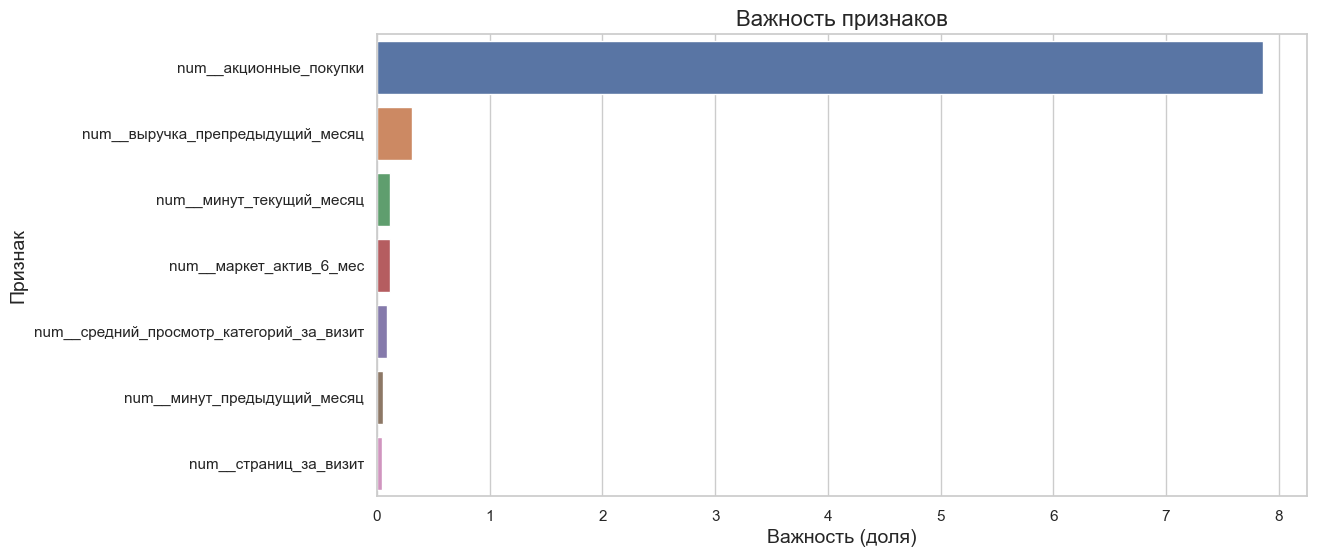

In [155]:
plt.figure(figsize=(12, 6))

# Постройте столбчатый график:
# по оси x — важность признака;
# по оси y - его наименование.
ax = sns.barplot(data=feature_importances, x='significance', y=feature_importances.index)

# добавляем названия графика и осей
ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

# отображаем график
plt.show()

**В соответствие с теорией шансов и экспонецированием весов, акционные покупки играют самую важную роль для определения класса, что покупательская активность снизится.** Обратим на это внимание. 

**Мы видим, что подход с экспоненцированием весов приводит к завышению важности признака акционных покупок и занижению важности остальных признаков, имеющих большие отрицательные коэффициенты. Эту проблему преодолевает алгоритм SHAP, который анализирует все возможные комбинации признаков и выявляет вклад каждого из них в предсказания. Будет рассмотрен ниже.**

#### Попытки улучшить метрику с помощью полиномизации

**Логистическая регрессия улавливает только линейные зависимости, поэтому её можно улучшить, добавив в признаковое описание полиномиальные признаки с помощью полиномизации.    
SelectKBest отобрал только переменные, содержащие числа. Посмотрим, произойдет ли улучшение метрики, если использовать полиномизацию.**

Выведем список отобранных SelectKBest признаков.

In [156]:
# список отобранных признаков
lst=features_names_best.tolist()
lst

['num__маркет_актив_6_мес',
 'num__акционные_покупки',
 'num__средний_просмотр_категорий_за_визит',
 'num__страниц_за_визит',
 'num__выручка_препредыдущий_месяц',
 'num__минут_предыдущий_месяц',
 'num__минут_текущий_месяц']

Нам нужно отобрать эти признаки среди исходных, содержащихся в X_train. Там эти признаки без приставки "num__".

In [157]:
X_train.head(2)

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
id                                                          
215858    стандарт                 да                 5.5   
215361    стандарт                 да                 5.1   

        маркет_актив_тек_мес  длительность  акционные_покупки  \
id                                                              
215858                     4           510               0.15   
215361                     4           199               0.23   

                        популярная_категория  \
id                                             
215858  Мелкая бытовая техника и электроника   
215361        Техника для красоты и здоровья   

        средний_просмотр_категорий_за_визит  \
id                                            
215858                                    2   
215361                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215858                                   4               7                16   
215361                                   5               2                 3   

        выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
215858                    5170.5                       4347.0   
215361                    6400.0                       4597.0   

        выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  
id                                                                          
215858                 6014.2                      20                    6  
215361                 3789.7                      11                   13

Удалим приставку "num__" и сформируем список отобранных признаков в соответствие с именами в X_train. Будем использовать list comprehension.

In [158]:
'num__маркет_актив_6_мес'.split('__')

['num', 'маркет_актив_6_мес']

In [159]:
# список отобранных признаков
lst = [x.split('__')[1] for x in lst]
lst

['маркет_актив_6_мес',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'страниц_за_визит',
 'выручка_препредыдущий_месяц',
 'минут_предыдущий_месяц',
 'минут_текущий_месяц']

In [160]:
poly = PolynomialFeatures(2)

X_train_new_ = poly.fit_transform(X_train[lst])
X_test_new_ = poly.transform(X_test[lst])

# применяем масштабирование StandardScaler(), так как он был выбран как гиперпераметр
scaler = StandardScaler()

# стандартизация
X_train_scalled = pd.DataFrame(scaler.fit_transform(X_train_new_),columns = poly.get_feature_names_out())
X_test_scalled =  pd.DataFrame(scaler.transform(X_test_new_),columns = poly.get_feature_names_out())
# инициализируем и обучаем модель
# считаем roc_auc
model_poly = LogisticRegression(penalty='l1', C=0.8, random_state=42, solver='saga')
model_poly.fit(X_train_scalled, y_train)
roc_auc_poly = roc_auc_score(y_test, model_poly.predict_proba(X_test_scalled)[:,1])
print(roc_auc_poly)

0.9225822108967359


**Метрика почти не изменилась. Будем использовать более простую модель без полинимизации.**

### Итоговый вывод по моделированию с использованием пайплайнов

* Вначале был построен пайплайн на основе всех входных признаков.   
* Количественные и категориальные признаки обработаны в пайплайне раздельно.
* Во время подготовки данных использован ColumnTransformer. 
* Для кодирования категориальных признаков использованы OneHotEncoder и OrdinalEncoder.    
Категории у номинальных признаков 'разрешить_сообщать' и 'популярная_категория' нельзя упорядочить, поэтому для них использовано кодирование с помощью OneHotEncoder. Входной признак 'тип_сервиса' содержит категории, которые можно упорядочить. Для 'тип_сервиса' использовано кодирование OrdinalEncoder.   
* Для масштабирования количественных признаков рассматривались скейлеры: StandardScaler(), MinMaxScaler().
* При моделировании выбрана метрика ROC-AUC. Это площадь под ROC-кривой. Она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения. Поэтому она не зависит от того, какой порог мы выберем. Это самая общая оценка итогов работы модели. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.   
* **Было обучено четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой из них осуществлялся перебор гиперпараметров. В результате случайного поиска с использованием кросс-валидации RandomSearchCV была найдена оптимальная модель LogisticRegression(C=0.8, penalty='l1', random_state=42,                                    solver='saga') с лучшим скейлером MinMaxScaler. Метрика лучшей модели при кросс-валидации: 0.8985. Метрика ROC-AUC на тестовой выборке: 0.9189.**   
* Далее производилось улучшение метрики модели за счет отбора признаков 2 способами: вручную и через SelectKBest.
* Через отбор признаков вручную лучшая метрика получена при удалении признака выручка за предыдущий месяц либо выручка за текущий месяц, которые имеют между собой сильную корреляцию (коэффициент корреляции phi_K=0.84). Эта метрика совпадает с метрикой, полученной при использовании пайплайна. **Метрика ROC-AUC на тестовой выборке: 0.9189.**    
* **Далее был произведен отбор признаков с помощью SelectKBest с использованием статистического теста f_classif** - тест на основании линейной зависимости между двумя случайными признаками. Он сравнивает изменения между входным признаком и целевым, чтобы проверить, влияют ли они друг на друга. Применяется для линейной и логистической регрессий. SelectKBest отобрал следующие 7 признаков: среднее значение маркетинговых коммуникаций за последние 6 месяцев,  среднемесячная доля акционных покупок за последние 6 месяцев,  средний просмотр категорий за визит в течение последнего месяца, среднее количество просмотренных страниц за визит, сумма выручки за препредыдущий_месяц, количество минут на сайте за предыдущий месяц, количество минут на сайте за текущий_месяц. **Лучшее значение метрики на тестовых данных roc_auc = 0.9217 получено на 7 признаках.**
* Также была исследована возможность полиномизации признаков. Так как метрика не сильно отличается от оптимальной на 7 признаках, в целях упрощения модели полиномизация применяться не будет.

## Анализ важности признаков методом SHAP

Однозначную оценку вклада признака в каждый прогноз показывают значения Шепли, их оценивают методом SHAP (SHapley Additive exPlanations). Он вычисляет, как отдельный признак помог присвоить модели итоговое значение целевого.

Значение Шепли изначально рассчитывают для каждого отдельного наблюдения в выборке. Для этого алгоритм SHAP анализирует все возможные комбинации признаков и выявляет вклад каждого из них в предсказания. Если вам нужно узнать вклад признака на всех данных, то SHAP может агрегировать индивидуальные значения Шепли: высчитает среднее модулей каждого из них или суммирует их по модулю.    
Значения Шепли требуют большой мощи компьютера, поэтому для их расчёта используют алгоритмы оптимизации вычислений. 

Чаще всего значения Шепли показывают с помощью графиков shap.plots.bar(), shap.plots.beeswarm(), shap.plots.waterfall().  
Графики shap.plots.bar(), shap.plots.beeswarm() предназначены для визуализации общей значимости признаков, а shap.plots.waterfall() — для отображения вклада каждого признака в классификацию отдельного наблюдения.

**Выведем признаки, отобранные SelectKBest.**

In [161]:
features_names_best

array(['num__маркет_актив_6_мес', 'num__акционные_покупки',
       'num__средний_просмотр_категорий_за_визит',
       'num__страниц_за_визит', 'num__выручка_препредыдущий_месяц',
       'num__минут_предыдущий_месяц', 'num__минут_текущий_месяц'],
      dtype=object)

**Построим график значимости признаков на обучающей выборке.**

In [162]:
X_train_p[features_names_best].shape # размерность обучающей выборки

(972, 7)

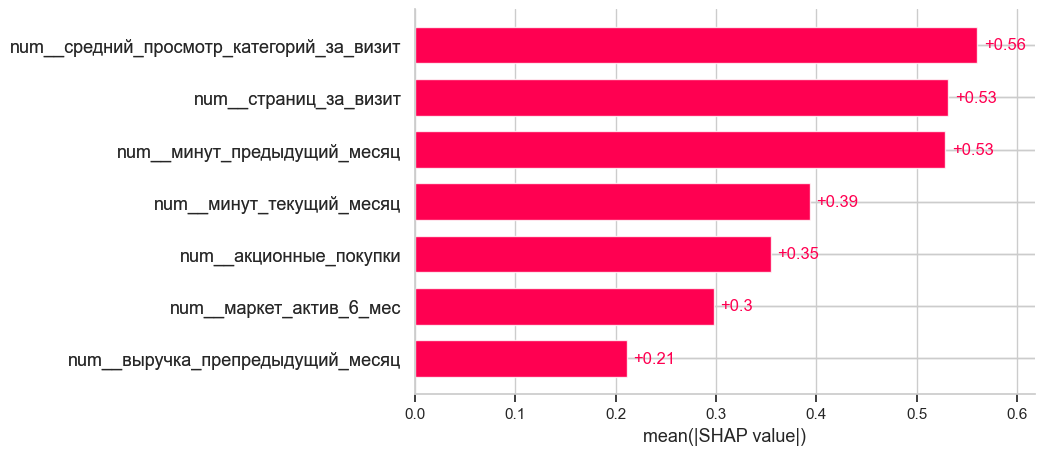

In [163]:
shap.initjs()
# инициализация объекта
explainer = shap.LinearExplainer(model_select_k_best, X_train_p[features_names_best])
# вычисление значений Шепли для обучающей выборки
shap_values_train = explainer(X_train_p[features_names_best])
shap.plots.bar(shap_values_train) 

**Построим график значимости признаков на тестовой выборке.**

In [164]:
X_test_p[features_names_best].shape # размерность тестовой выборки

(324, 7)

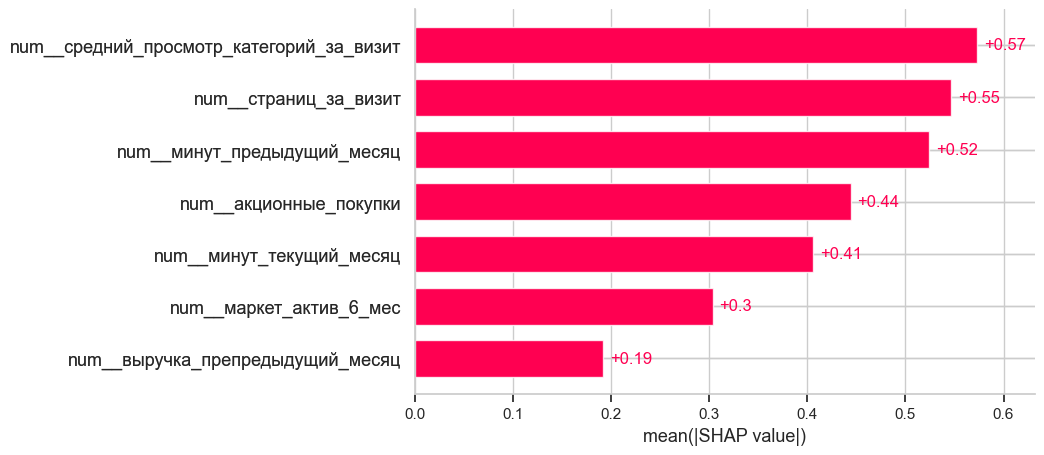

In [165]:
shap.initjs()
# инициализация объекта
explainer = shap.LinearExplainer(model_select_k_best, X_test_p[features_names_best])
# вычисление значений Шепли для тестовой выборки
shap_values_test = explainer(X_test_p[features_names_best])
shap.plots.bar(shap_values_test) 

Лидирует среднее количество просмотров категорий за визит в течение последнего месяца, вторым по значимости стал признак — среднее количество просмотренных страниц за визит.  
Признаки на графике расположены в порядке убывания их вклада: если убрать те, что наверху, качество модели просядет сильнее всего.       
Перейдём к самому интересному — посмотрим, как признаки влияют на каждое предсказание модели. 

**График shap.plots.beeswarm**

График shap.plots.beeswarm
Диаграмма shap.plots.beeswarm — это один из вариантов визуализации вклада признаков в каждое предсказание модели. На графике точками отображены все наблюдения из выборки.
На оси 𝑋 отложены значения Шепли, на оси 𝑌 — признаки модели, расположенные сверху вниз в порядке убывания средних SHAP значений.

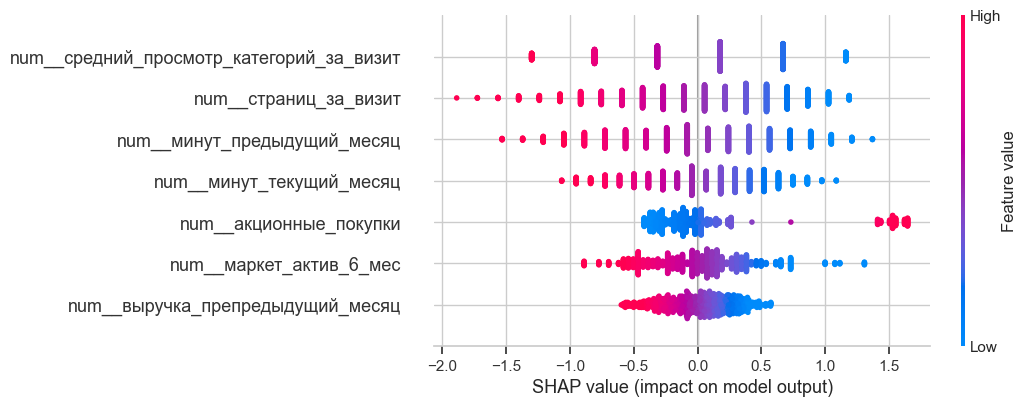

In [166]:
# график для обучающей выборки
shap.plots.beeswarm(shap_values_train)

Всего на этом графике 972*7 точек. 972 объекта из обучающей выборки откладываются на диаграмме 7 раз, по одному разу на «строчке» каждого признака. Так проще всего отобразить вклад каждого признака в классификацию всех наблюдений.

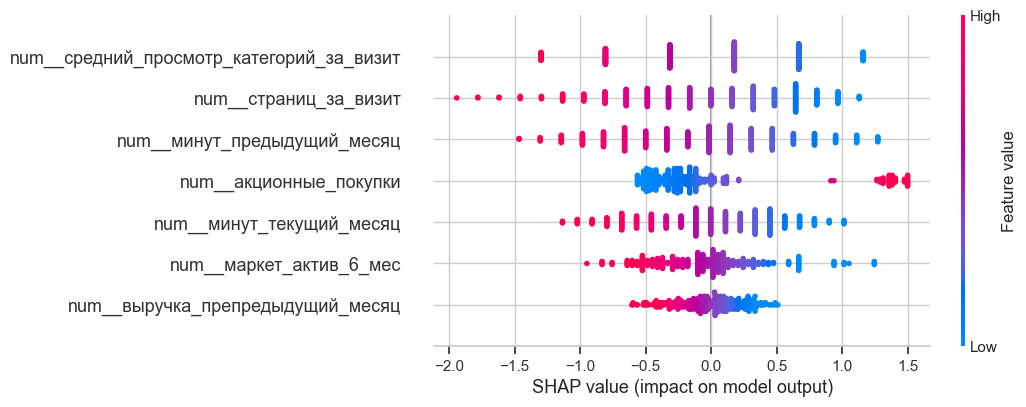

In [167]:
shap.plots.beeswarm(shap_values_test)

Всего на этом графике 324*7 точек. 324 объекта из тестовой выборки откладываются на диаграмме 7 раз, по одному разу на «строчке» каждого признака. Так проще всего отобразить вклад каждого признака в классификацию всех наблюдений.

Мы видим на графике вертикальные черточки для признаков "среднее количество просмотров категорий за визит в течение последнего месяца", "среднее количество просмотренных страниц за визит", "количество минут на сайте за предыдущий месяц", "количество минут на сайте за текущий месяц", так как значения этих признаков - дискретны. Для непрервных переменных ("среднемесячная доля акционных покупок за последние 6 месяцев", "среднемесячное значение маркетинговых коммуникаций за последние 6 месяцев", "сумма выручки за препредыдущий месяц") таких черточек нет: значения сплошь заполняют некоторую область.  При этом в случае непрерывных переменных мы видим 2 явно выраженных сегмента по признаку акционные покупки.

**Как читать этот график:**        
* Отрицательные значения Шепли означают, что признак склоняет модель отнести объекты к классу 0, а положительные значения - к классу 1.
* Чем больше высота линии, тем больше наблюдений сгруппированы вместе: у них близкие значения Шепли. Это значит, что модель уверенно присваивает SHAP-значения с учетом закономерностей в данных.
* Цвет точки отображает значения каждого признака объекта. Чем краснее объект, тем больше значение признака. 

**Разберем отдельно для каждого признака:**   

* **Среднее количество просмотров категорий за визит в течение последнего месяца.** Чем больше значения признака (красный цвет), тем меньше SHAP значения объектов. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 0. То есть, чем больше среднее количество просмотренных категорий за визит в течение последнего месяца, тем больше вероятность, что покупательская активность останется на прежнем уровне. Соответственно малые значения среднего количества просмотренных категорий за визит в течение последнего месяца увеличивают вероятность принадлежности к классу 1, то есть, что покупательская активность снизится.

* **Среднее количество просмотренных страниц за визит.** Чем больше значения признака (красный цвет), тем меньше SHAP значения объектов. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 0. То есть, чем больше среднее количество просмотренных страниц за визит, тем больше вероятность, что покупательская активность останется на прежнем уровне. Соответственно малые значения среднего количества просмотренных страниц за визит увеличивают вероятность принадлежности к классу 1, то есть, что покупательская активность снизится.

* **Количество минут на сайте за предыдущий месяц.** Чем больше значения признака (красный цвет), тем меньше SHAP значения объектов. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 0. То есть, чем больше количество минут на сайте за предыдущий месяц, тем больше вероятность, что покупательская активность останется на прежнем уровне. Соответственно малые значения количества минут на сайте за предыдущий месяц увеличивают вероятность принадлежности к классу 1, то есть, что покупательская активность снизится.

* **Среднемесячная доля акционных покупок за последние 6 месяцев.** Чем больше значения признака (красный цвет), тем больше SHAP значения объектов. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 1. То есть, чем больше среднемесячная доля акционных покупок за последние 6 месяцев, тем больше вероятность, что покупательская активность  снизится. Соответственно малые значения среднемесячной доли акционных покупок за последние 6 месяцев увеличивают вероятность принадлежности к классу 0, то есть, что покупательская активность останется на прежнем уровне. На графике видим  2 ярко выраженных сегмента: сегмент с высокой долей акционных покупок, у которых высока вероятность снижения покупательской активности и сегмент с низкой долей акционных покупок, у которых высока вероятность, что покупательская активность останется на прежнем уровне.

* **Количество минут на сайте за текущий месяц.** Чем больше значения признака (красный цвет), тем меньше SHAP значения объектов. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 0. То есть, чем больше количество минут на сайте за текущий месяц, тем больше вероятность, что покупательская активность останется на прежнем уровне. Соответственно малые значения количества минут на сайте за текущий месяц увеличивают вероятность принадлежности к классу 1, то есть, что покупательская активность снизится.

* **Среднемесячное значение маркетинговых коммуникаций за последние 6 месяцев.** Чем больше значения признака (красный цвет), тем меньше SHAP значения объектов. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 0. То есть, чем больше среднемесячное значение маркетинговых коммуникаций за последние 6 месяцев, тем больше вероятность, что покупательская активность останется на прежнем уровне. Соответственно малые значения среднемесячных значений маркетинговых коммуникаций за последние 6 месяцев увеличивают вероятность принадлежности к классу 1, то есть, что покупательская активность снизится.

* **Сумма выручки за препредыдущий месяц.** Чем больше значения признака (красный цвет), тем меньше SHAP значения объектов. Если у наблюдения высокое значение этого признака, то у него высокая вероятность принадлежности к классу 0. То есть, чем больше сумма выручки за препредыдущий месяц, тем больше вероятность, что покупательская активность останется на прежнем уровне. Соответственно малые значения сумма выручки за препредыдущий месяц увеличивают вероятность принадлежности к классу 1, то есть, что покупательская активность снизится.

**График shap.plots.waterfall**

Диаграмма shap.plots.waterfall визуализирует индивидуальные SHAP-значения каждого наблюдения в датасете. 

In [168]:
# истинное значение класса для 6-го объекта (нумерация с нуля)
y_test[5] 

0

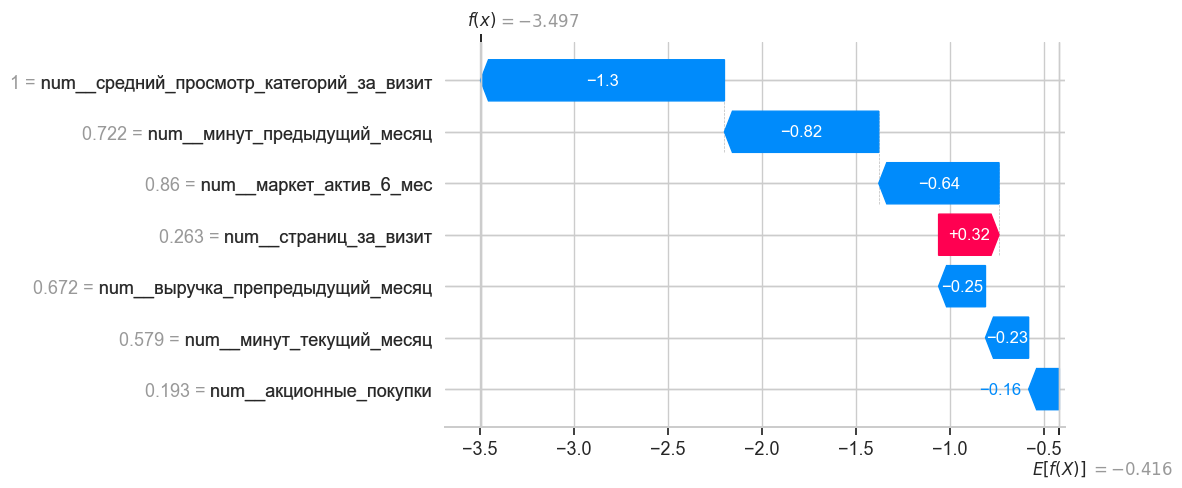

In [169]:
shap.plots.waterfall(shap_values_test[5])

Сильнее всего на классификацию этого объекта влияют признаки "среднее количество просмотров категорий за визит в течение последнего месяца", "количество минут на сайте за предыдущий месяц", "среднемесячное значение маркетинговых коммуникаций за последние 6 месяцев": они «перетягивают» предсказание в сторону класса 0. Значение f(x) на графике показывает, к какому классу признак склоняет наблюдение: отрицательные значения говорят о том, что наблюдение скорее относится к классу 0, а положительные — к классу 1.    
**Модель верно определила класс объекта.**

**Проанализируем с помощью SHAP объекты, которым модель поставила низкую оценку принадлежности к классу 1 (то есть высока оценка принадлежности к классу 0), а на самом деле эти объекты принадлежат классу 1.**

Вначале создадим датафрейм, в котором будут 2 столбца: y_test - истинные значения - класс 0 (Прежний уровень покупательской активности) и класс 1 (Снизилась), столбец score_class_1 - оценки (вероятности) отнесения к классу 1.

In [170]:
X_test_p[features_names_best].shape # размерность тестовой выборки

(324, 7)

In [171]:
score_class_1 = model_select_k_best.predict_proba(X_test_p[features_names_best])[:,1]
score_class_1 = pd.DataFrame(data = {'y_test':y_test, 'score_class_1': score_class_1})
score_class_1

y_test  score_class_1
0         0       0.020986
1         1       0.967532
2         0       0.121307
3         1       0.686018
4         1       0.776772
..      ...            ...
319       1       0.941308
320       0       0.114750
321       1       0.813959
322       0       0.289633
323       1       0.963076

[324 rows x 2 columns]

**Выведем объекты с довольно низкой оценкой принадлежности к классу 1, например, ниже 0.1. Этот порог мы можем менять и анализировать объекты с помощью SHAP.**

In [172]:
score_class_1[(score_class_1['y_test']==1)&(score_class_1['score_class_1']<0.1)]

y_test  score_class_1
24        1       0.075607
111       1       0.024047
272       1       0.080692
275       1       0.016199
297       1       0.071958

**Визуализируем индивидуальные SHAP-значения этих наблюдений.**

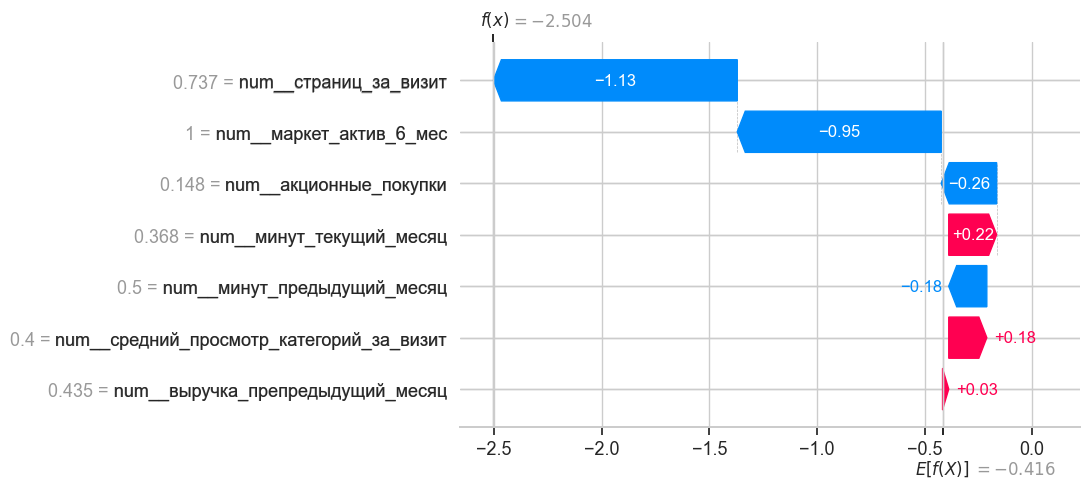

In [173]:
shap.plots.waterfall(shap_values_test[24])

**Модель отнесла объект к классу 0 (на самом деле объект класса 1) из-за того, что среднее количество просмотренных страниц за визит, среднемесячное значение маркетинговых коммуникаций за последние 6 месяцев, среднемесячная доля акционных покупок за последние 6 месяцев,  количество минут на сайте за предыдущий месяц склонили модель к неверному решению.**

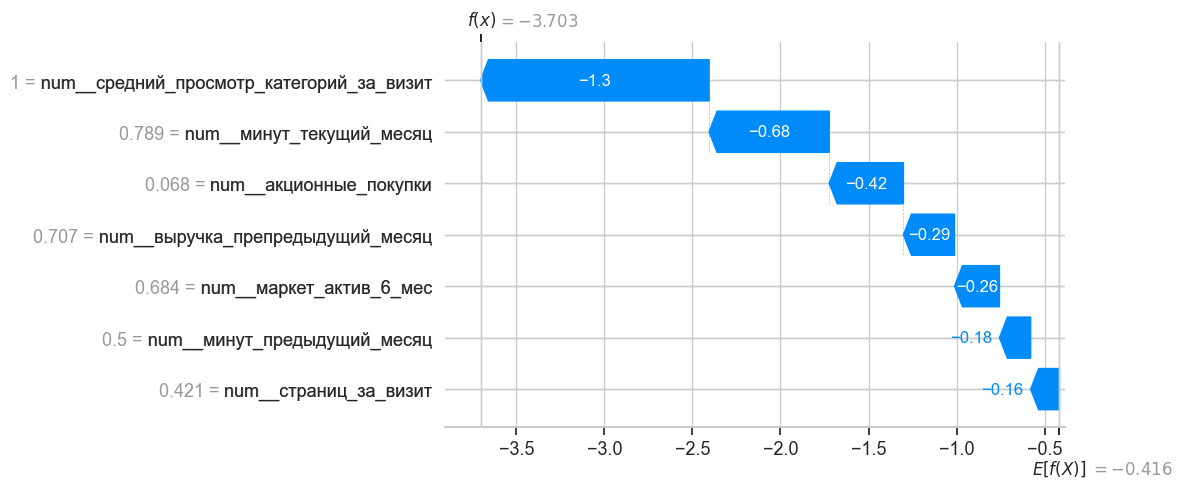

In [174]:
shap.plots.waterfall(shap_values_test[111])

**Модель отнесла объект к классу 0 (на самом деле объект класса 1) из-за того, что все признаки склонили модель к неверному решению.**

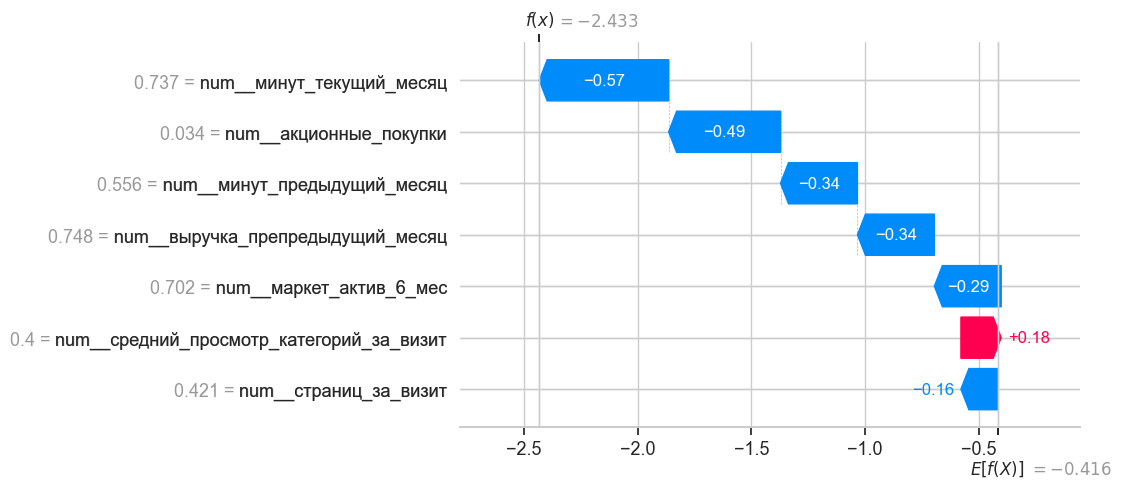

In [175]:
shap.plots.waterfall(shap_values_test[272])

**Модель отнесла объект к классу 0 (на самом деле объект класса 1) из-за того, что все признаки, кроме среднего количества просмотров категорий за визит в течение последнего месяца, склонили модель к неверному решению.**

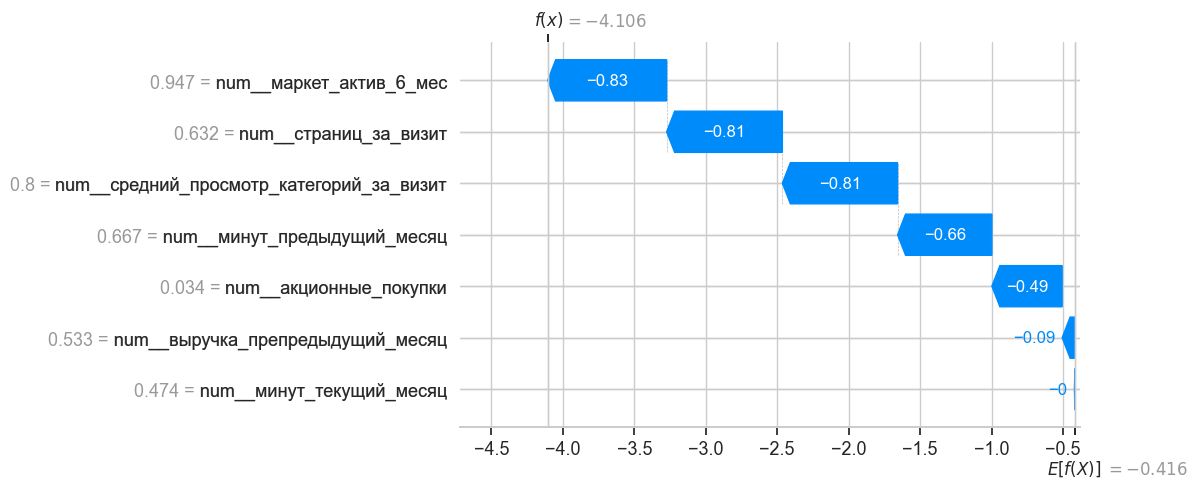

In [176]:
shap.plots.waterfall(shap_values_test[275])

**Модель отнесла объект к классу 0 (на самом деле объект класса 1) из-за того, что все признаки склонили модель к неверному решению.**

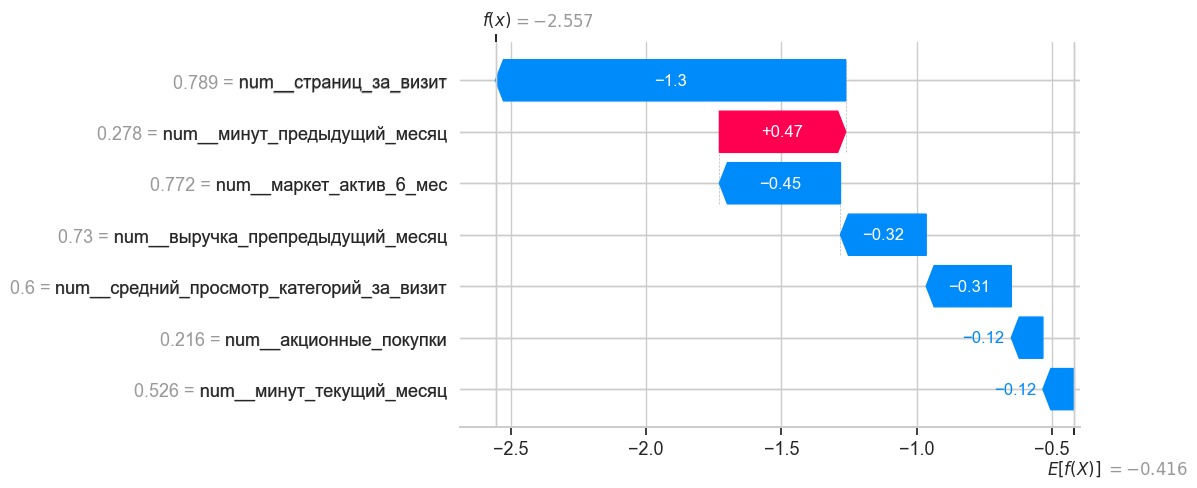

In [177]:
shap.plots.waterfall(shap_values_test[297])

**Модель отнесла объект к классу 0 (на самом деле объект класса 1) из-за того, что все признаки, кроме количества минут на сайте за предыдущий месяц, склонили модель к неверному решению. Сильнее всего на его классификацию влияет признак "среднее количество просмотренных страниц за визит".**

**По аналогии проанализируем с помощью SHAP объекты, которым модель поставила высокую оценку принадлежности к классу 1 (например, больше 0.7), а на самом деле эти объекты принадлежат классу 0.**

In [178]:
score_class_1[(score_class_1['y_test']==0)&(score_class_1['score_class_1']>=0.7)]

y_test  score_class_1
277       0        0.71159

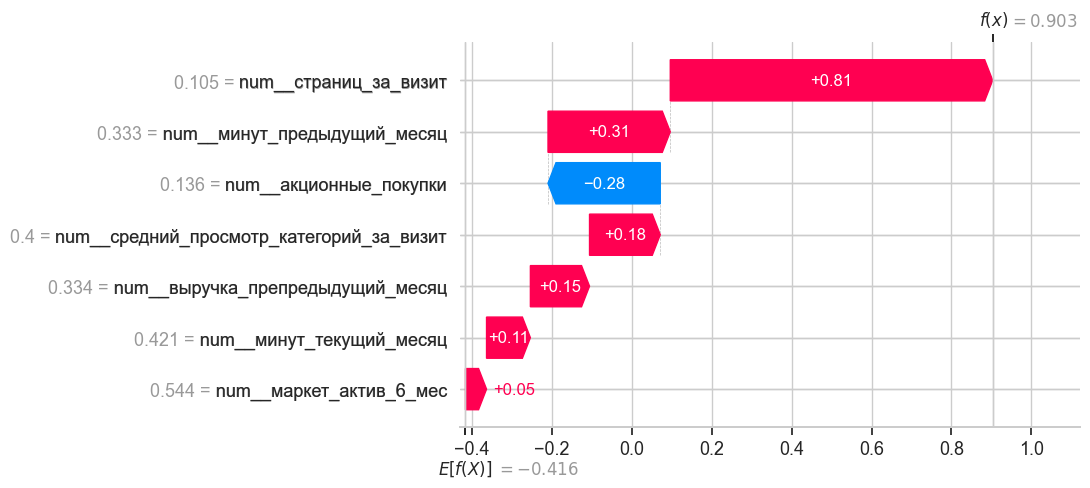

In [179]:
shap.plots.waterfall(shap_values_test[277])

Сильнее всего на его классификацию влияет признаки "среднее количество просмотренных страниц за визит" и "количество минут на сайте за предыдущий месяц": они «перетягивают» предсказание в сторону класса 1. Положительное значение f(x) на графике показывает, что модель относит наблюдение скорее к классу 1.

**Таким образом, можно задать границу порога вероятности и проанализировать с помощью SHAP ошибки 1 и 2 рода, то есть, какие признаки склонили модель к неправильному решению.**

## Добавление новых данных в таблицу "market_file"

Для более подробного исследования объединим таблицу "market_file" с "money".

In [180]:
# объединение по индексу id через join
market_file = market_file.join(money.set_index('id'))
market_file.head(3)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   
215351                 Снизилась    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   

        акционные_покупки популярная_категория  \
id                                               
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   

           акционные_покупки_категории  выручка_предыдущий_месяц  \
id                                                                 
215349  высокая доля акционных покупок                    5216.0   
215350   низкая доля акционных покупок                    5457.5   
215351  высокая доля акционных покупок                    6158.0   

        выручка_препредыдущий_месяц  выручка_текущий_месяц  \
id                                                           
215349                       4472.0                 4971.6   
215350                       4826.0                 5058.4   
215351                       4793.0                 6610.4   

        минут_предыдущий_месяц  минут_текущий_месяц  прибыль  
id                                                            
215349                      12                   10     4.16  
215350                       8                   13     3.13  
215351                      11                   13     4.87

Добавим в таблицу также 2 столбца: разница в выручке текущего и предыдущего месяца и разница в выручке предыдущего и  препредыдущего месяца.

In [181]:
market_file['разница_в_выручке_тек_пред'] = market_file['выручка_текущий_месяц'] - market_file['выручка_предыдущий_месяц']
market_file['разница_в_выручке_пред_препред'] = market_file['выручка_предыдущий_месяц'] - market_file['выручка_препредыдущий_месяц'] 
market_file[['выручка_текущий_месяц', 'разница_в_выручке_тек_пред', 'разница_в_выручке_пред_препред', 'прибыль']].head()

выручка_текущий_месяц  разница_в_выручке_тек_пред  \
id                                                          
215349                 4971.6                      -244.4   
215350                 5058.4                      -399.1   
215351                 6610.4                       452.4   
215352                 5872.5                        65.0   
215353                 5388.5                       650.0   

        разница_в_выручке_пред_препред  прибыль  
id                                               
215349                           744.0     4.16  
215350                           631.5     3.13  
215351                          1365.0     4.87  
215352                          1213.5     4.21  
215353                          -385.5     3.95

## Исследование сегмента с высокой долей акционных покупок

### Общие сведения о сегменте

Ранее при исследовательском анализе данных мы видели, что есть группа покупателей с высокой долей акционных покупок. Повторим гистограмму.

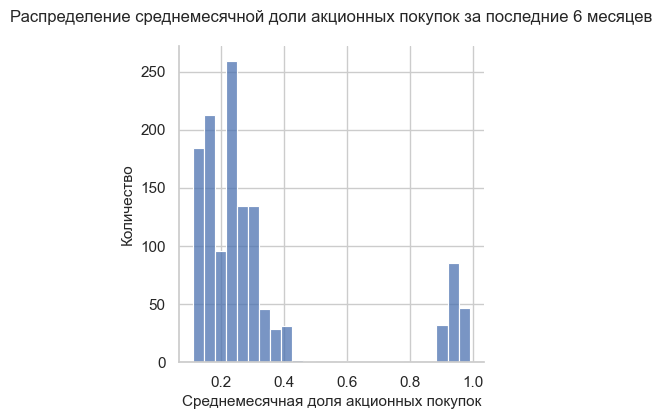

In [182]:
sns.displot(data=market_file, x='акционные_покупки', bins=25, height=4, aspect=1);
# Подписи осей
plt.xlabel('Среднемесячная доля акционных покупок', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение cреднемесячной доли акционных покупок за последние 6 месяцев', y=1.05);

**На графике 2 сегмента:** 
* большая часть - те, кто делают покупки независимо от акции.
* меньшая часть - те, кто делают покупки по акции.   

**Рассмотрим сегмент с высокой долей акционных покупок.** 

**Будем использовать полученные в результате моделирования вероятности снижения покупательской активности.**

In [183]:
# объединяем акционные покупки с оценками принадлежности к классу 1 (покупательская активность Снизилась)
df = X_test.reset_index().join(score_class_1)
df['y_test'] = df['y_test'].map({1: 'Снизилась', 0: 'Прежний уровень'})
# создаем датафрейм для нашего сегмента
high_promo_buy = df[df['акционные_покупки'] > 0.5]
high_promo_buy = high_promo_buy.rename(columns={'y_test': 'покупательская_активность', 'score_class_1': 'вероятность_класса_1'})
# объединяем датафреймы по индексу
high_promo_buy = high_promo_buy.set_index('id').join(money.set_index('id'))
# посмотрим на датафрейм
high_promo_buy.head(3) 

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
id                                                          
215654     премиум                нет                 1.4   
215934    стандарт                нет                 5.5   
215844     премиум                 да                 4.3   

        маркет_актив_тек_мес  длительность  акционные_покупки  \
id                                                              
215654                     4           684               0.94   
215934                     4           147               0.99   
215844                     4          1041               0.99   

                        популярная_категория  \
id                                             
215654                      Товары для детей   
215934  Мелкая бытовая техника и электроника   
215844                       Кухонная посуда   

        средний_просмотр_категорий_за_визит  \
id                                            
215654                                    3   
215934                                    1   
215844                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215654                                   6               1                 6   
215934                                   2               3                 7   
215844                                   1               6                 6   

        выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
215654                    3548.0                       4656.0   
215934                    5090.0                       4451.0   
215844                    5339.0                       4880.0   

        выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  \
id                                                                           
215654                 4170.7                      11                    9   
215934                 5773.8                      15                   18   
215844                 5866.8                       9                   14   

       покупательская_активность  вероятность_класса_1  прибыль  
id                                                               
215654                 Снизилась              0.967532     2.75  
215934                 Снизилась              0.776772     4.40  
215844                 Снизилась              0.816413     2.79

In [184]:
# размерность датафрейма с выбранным сегментом в тестовой выборке
high_promo_buy.shape 

(45, 19)

**В связи с малым объемом выборки поступим следующим образом: вычисляем вероятности снижения активности на всем датасете с помощью модели.**

Для тестовой выборки вероятности уже вычислены и находятся в датафрейме score_class_1. Вычислим вероятности для обучающей выборки. Используем обработанные данные (отмасштабированные, закодированные).

In [185]:
score_class_1_train = model_select_k_best.predict_proba(X_train_p[features_names_best])[:,1]
score_class_1_train= pd.DataFrame(data = {'покупательская_активность':y_train, 'вероятность_класса_1': score_class_1_train})
# присоединение вероятностей к признакам для обучающей выборки
df_train = X_train.reset_index().join(score_class_1_train)
# присоединение вероятностей к признакам для тестовой выборки
df_test = X_test.reset_index().join(score_class_1)
df_test = df_test.rename(columns={'y_test': 'покупательская_активность', 'score_class_1': 'вероятность_класса_1'})
df_train.shape, df_test.shape  # размерности датафреймов

((972, 19), (324, 19))

Соединяем вместе df_train и df_test с помощью pd.concat().

In [186]:
# соединение строк датафреймов
data_all = pd.concat([df_train,df_test], axis=0)
# замена в столбце значений 1 на Снизилась и 0 на Прежний уровень
data_all['покупательская_активность'] = data_all['покупательская_активность'].map({1: 'Снизилась', 0: 'Прежний уровень'})
data_all.head(3)

id тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
0  215858    стандарт                 да                 5.5   
1  215361    стандарт                 да                 5.1   
2  215884    стандарт                 да                 4.3   

   маркет_актив_тек_мес  длительность  акционные_покупки  \
0                     4           510               0.15   
1                     4           199               0.23   
2                     5           997               0.17   

                   популярная_категория  средний_просмотр_категорий_за_визит  \
0  Мелкая бытовая техника и электроника                                    2   
1        Техника для красоты и здоровья                                    4   
2  Мелкая бытовая техника и электроника                                    5   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   4               7                16   
1                                   5               2                 3   
2                                   1               3                11   

   выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
0                    5170.5                       4347.0   
1                    6400.0                       4597.0   
2                    4113.0                       4626.0   

   выручка_текущий_месяц  минут_предыдущий_месяц  минут_текущий_месяц  \
0                 6014.2                      20                    6   
1                 3789.7                      11                   13   
2                 3798.4                      13                   10   

  покупательская_активность  вероятность_класса_1  
0           Прежний уровень              0.115305  
1                 Снизилась              0.473068  
2           Прежний уровень              0.150573

In [187]:
data_all.shape # размерность

(1296, 19)

**Рассмотрим сегмент с высокой долей акционных покупок.**

In [188]:
# создаем датафрейм для нашего сегмента
high_promo_buy = data_all[data_all['акционные_покупки'] > 0.5]
# объединяем датафреймы по индексу
high_promo_buy = high_promo_buy.set_index('id').join(money.set_index('id'))
# посмотрим на датафрейм
high_promo_buy.shape

(167, 19)

**Используя результаты моделирования (вероятности классов), мы можем проранжировать клиентов по вероятности снижения активности и таким образом использовать эту информацию как одну из осей скаттерплота. Второй осью тогда будет категория, которая является логичной после выбора сегмента. В нашем случае, если выбираем сегмент с высокой вероятностью снижения покупательской активности и максимальной долей покупок по акции, то второй шкалой в скаттерплоте будет доля покупок по акции.**

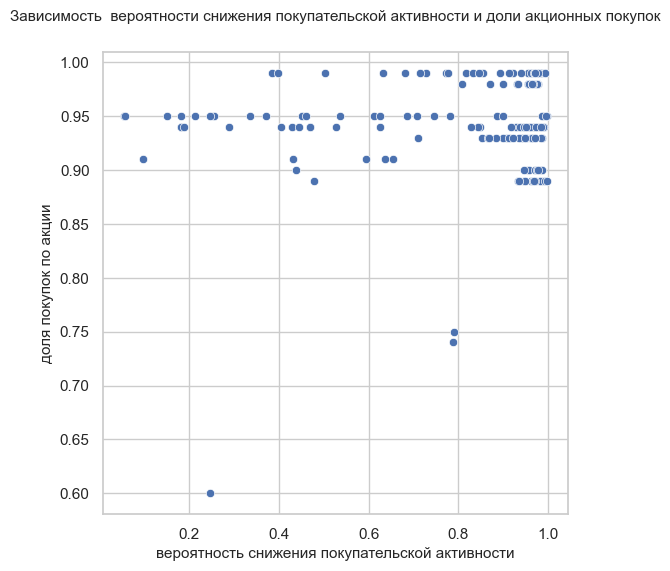

In [189]:
plt.figure(figsize=(6,6))
sns.scatterplot(y='акционные_покупки', x='вероятность_класса_1', data=high_promo_buy,  palette='Dark2');
# Заголовок
plt.title('Зависимость  вероятности снижения покупательской активности и доли акционных покупок', y=1.05, fontsize=11);
# подписи осей
plt.ylabel('доля покупок по акции', fontsize=11);
plt.xlabel('вероятность снижения покупательской активности', fontsize=11);

Для бизнеса важно, чтобы покупательская активность не снижалась. Поэтому рассмотрим **сегмент с высокой долей акционных покупок и и высокой вероятностью снижения покупательской активности.** Проанализируем его и предложим меры для сохранения покупательской активности.

In [190]:
high_promo_buy = high_promo_buy[high_promo_buy['вероятность_класса_1'] > 0.5]
high_promo_buy.shape

(140, 19)

**Посмотрим на зависимость прибыли в этом сегменте от вероятности снижения покупательской активности.**

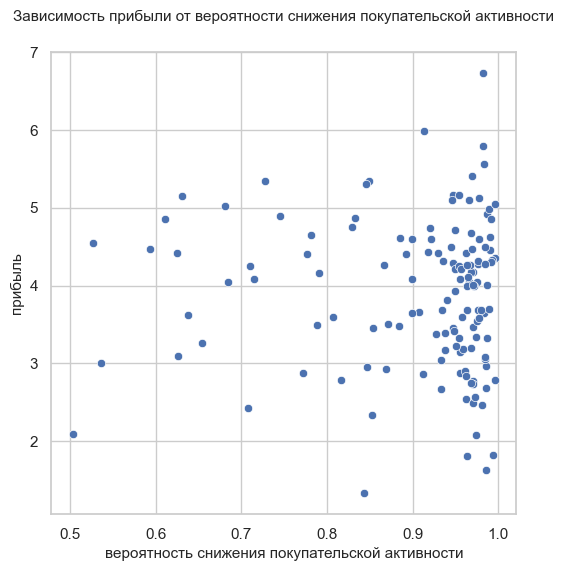

In [191]:
plt.figure(figsize=(6,6))
sns.scatterplot(y='прибыль', x='вероятность_класса_1', data=high_promo_buy,  palette='Dark2');
# Заголовок
plt.title('Зависимость прибыли от вероятности снижения покупательской активности', y=1.05, fontsize=11);
# подписи осей
plt.xlabel('вероятность снижения покупательской активности', fontsize=11);
plt.ylabel('прибыль', fontsize=11);

**Ярко выраженной зависимости не наблюдается.**

### Подробный анализ выбранного сегмента 

#### Исследование выручки и разницы в выручке за периоды

**Представим распределение выручки, которую получает магазин с покупателей выбранного сегмента, в виде диаграммы и ящика с усами для сравнения за разные периоды.**    

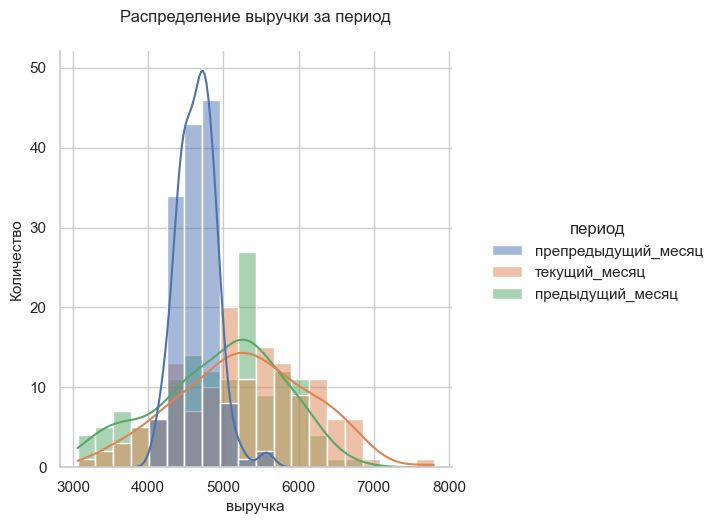

In [192]:
# объединяем датафрейм рассматриваемого сегмента с датафреймом с выручкой по периодам
df_period = high_promo_buy[['популярная_категория']].join(market_money.set_index('id'))

sns.displot(data=df_period, hue='период', kde=True, x='выручка');
# Подписи осей
plt.xlabel('выручка', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение выручки за период', y=1.05);

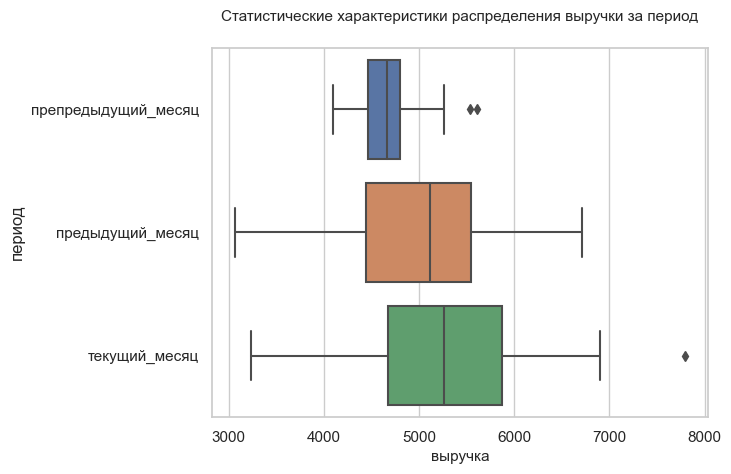

In [193]:
order = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']
sns.boxplot(x='выручка', y='период', data=df_period, showfliers=True, order=order); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения выручки за период', y=1.05, fontsize=11);
# подпись оси
plt.xlabel('выручка', fontsize=11);

**Видно, что средняя выручка увеличивается по периодам, однако это увеличение сопровождается увеличением разброса вокруг среднего значения, если сравнивать текущий и препредыдущий месяцы. Что вполне естественно: большему доходу соответствует больший риск.**

**Видим, что распределение выручки за препредыдущий месяц более сжато, что означает меньше рисков и большей предсказуемости выручки с покупателя.
А распределение выручки за текущий месяц имеет более широкий диапазон. Это говорит о том, что риски не получить плановую выручку с покупателя возросли. Медианное значение суммы выручки идет по нарастанию.**

**По графикам понятно, что разница в выручке за текущий и предыдущий месяц, а также за предыдущий и препредыдущий месяц будет положительна. Однако посмотрим, насколько сильно изменились риски.**

In [194]:
# группируем по периодам, рассчитываем среднее, медиану, общую сумму, 
# количество, стандартное отклонение по столбцу выручка
tmp = df_period.groupby(['период'])['выручка'].agg(['mean','median', 'sum', 'count', 'std'])
# создаем столбец с коэффициентом вариации
tmp['coef_variation'] = (100 * tmp['std'] / tmp['mean']).round(1)
tmp

mean   median       sum  count         std  \
период                                                                   
предыдущий_месяц     4950.314286  5119.25  693044.0    140  816.941742   
препредыдущий_месяц  4650.107143  4661.50  651015.0    140  253.892622   
текущий_месяц        5277.366429  5261.95  738831.3    140  866.551584   

                     coef_variation  
период                               
предыдущий_месяц               16.5  
препредыдущий_месяц             5.5  
текущий_месяц                  16.4

**Коэффициент вариации показывает, сколько риска приходится на 1 рубль выручки. Видим, насколько сильно возросли риски получения дополнительного рубля выручки текущего месяца (коэффициент вариации=16.4) по сравнению с препредыдущим месяцем (коэффициент вариации=5.5).**

#### Исследование прибыли и разницы в выручке за период в зависимости от популярной категории

**Посмотрим, какие категории наиболее популярны для выбранного сегмента.**

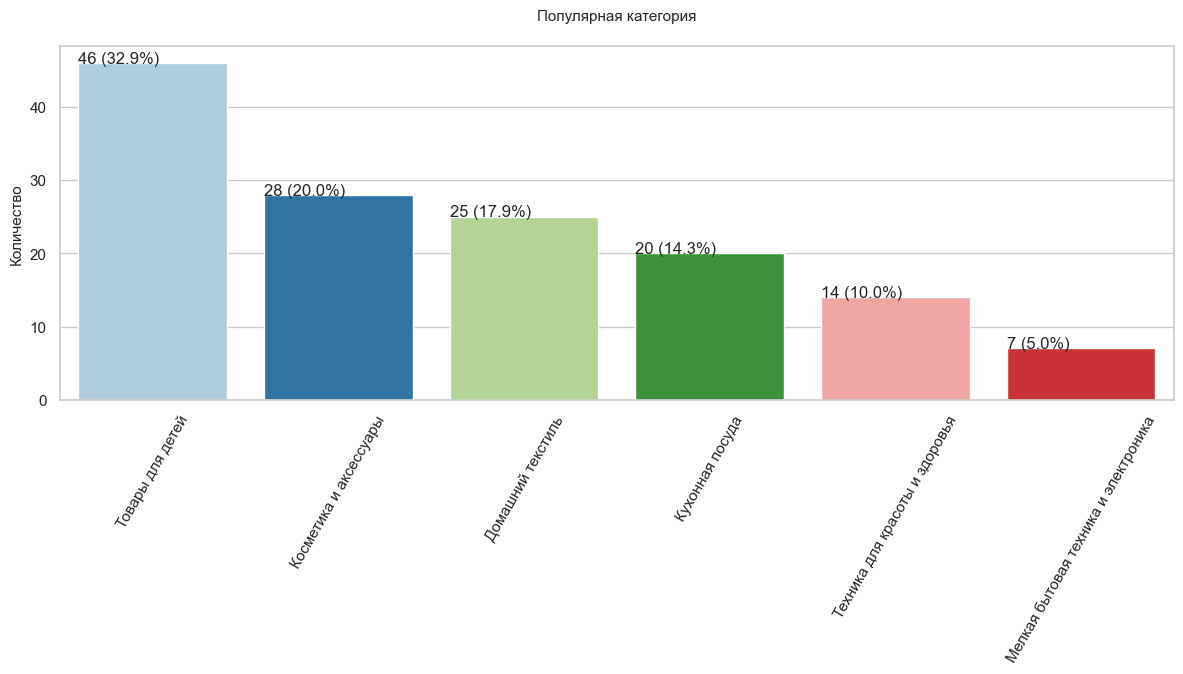

In [195]:
countplot_label(data=high_promo_buy, column='популярная_категория', \
                title='Популярная категория', \
                xlabel='', ylabel='Количество', \
                figsize=(12,7), label=2, order_sort=1, rotation=60, palette='Paired')

**Наиболее популярные категории:**
* Товары для детей (46 покупателей, 32.9%)
* Косметика и аксессуары (28 покупателей, 20%)     
* Домашний текстиль (25 покупателей, 17.9%)
  
**Наименее популярные категории:**
* Мелкая бытовая техника и электроника (7 покупателей, 5%)
* Техника для красоты и здоровья (14 покупателей, 10%)
* Кухонная посуда (20 покупателей, 14.3%)

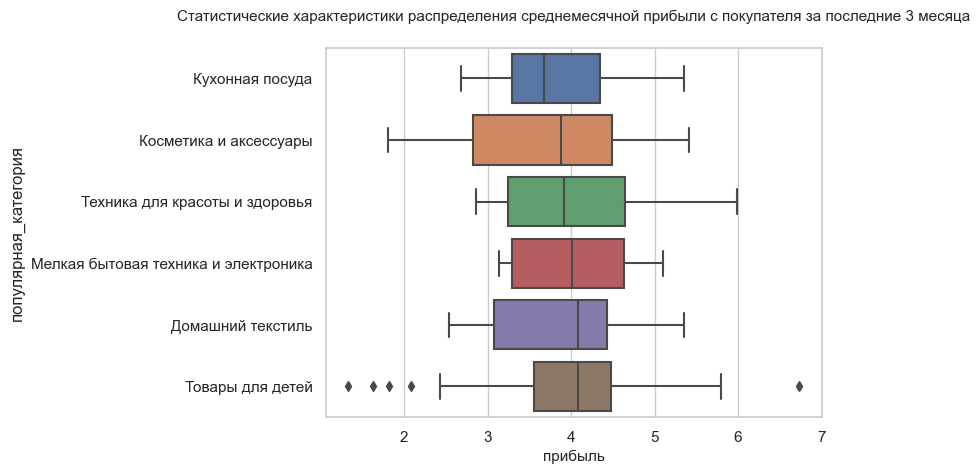

In [196]:
# порядок следования категорий - по возрастанию медианы прибыли
order = high_promo_buy.groupby('популярная_категория')['прибыль'].agg('median').sort_values().index
sns.boxplot(x='прибыль', data=high_promo_buy, y='популярная_категория', showfliers=True, order=order); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения среднемесячной прибыли с покупателя за последние 3 месяца', y=1.05, fontsize=11);
# подпись оси
plt.xlabel('прибыль', fontsize=11);

**Наибольшая медианная прибыль соответствует категориям Товары для детей, Домашний текстиль, Мелкая бытовая техника и электроника.  Наименьшая медианная прибыль соответствует категориям: Кухонная посуда, Косметика и аксессуары, Техника для красоты и здоровья.**

**Посмотрим графически, как меняется средняя выручка по категориям по месяцам.**

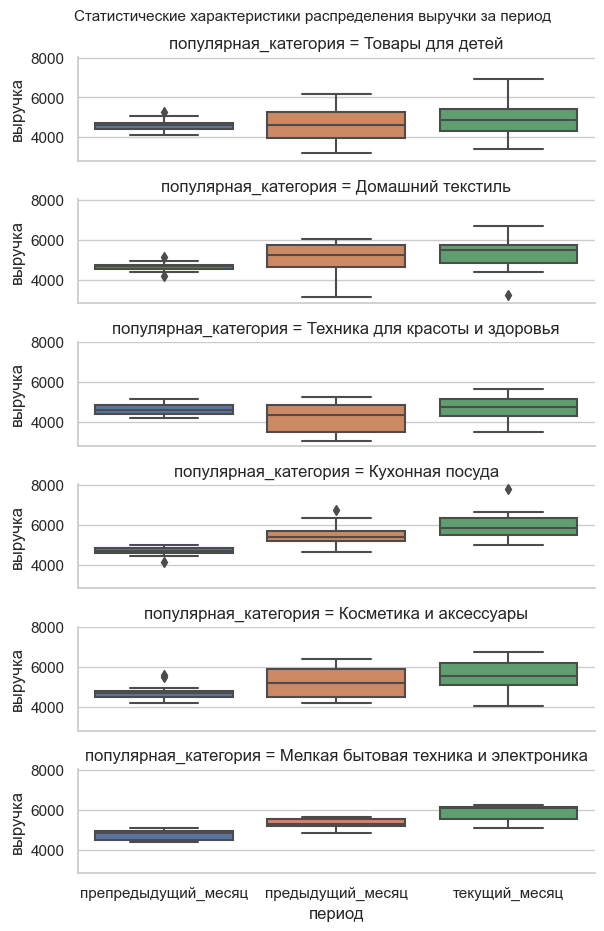

In [197]:
order = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']
sns.catplot(data=df_period, y='выручка', row='популярная_категория', x='период', kind='box', aspect=4, height=1.5, order=order);
# заголовок
plt.suptitle('Статистические характеристики распределения выручки за период',y=1.01, fontsize=11);

**Видим, что для рассматриваемого сегмента по всем категориям, кроме Техника для красоты и здоровья, медианная выручка возрастает по месяцам. В случае категории Техника для красоты и здоровья выручка просела в предыдущем месяце. Однако в текущем месяце ее значение выше предыдущего и препредыдущего месяцев.**

**Посчитаем разницу в выручке между месяцами по категориям товаров.**

In [198]:
high_promo_buy = high_promo_buy.join(market_file[['разница_в_выручке_пред_препред', 'разница_в_выручке_тек_пред']])

In [199]:
df = high_promo_buy.pivot_table(
    index = 'популярная_категория', 
    aggfunc='sum', 
    values=['разница_в_выручке_тек_пред', 'разница_в_выручке_пред_препред'])
df

разница_в_выручке_пред_препред  \
популярная_категория                                                   
Домашний текстиль                                             9741.5   
Косметика и аксессуары                                       15490.0   
Кухонная посуда                                              15898.0   
Мелкая бытовая техника и электроника                          4098.0   
Техника для красоты и здоровья                               -5186.0   
Товары для детей                                              1987.5   

                                      разница_в_выручке_тек_пред  
популярная_категория                                              
Домашний текстиль                                         7725.9  
Косметика и аксессуары                                    9503.0  
Кухонная посуда                                           8633.3  
Мелкая бытовая техника и электроника                      3493.1  
Техника для красоты и здоровья                            5697.9  
Товары для детей                                         10734.1

В текущем месяце выручка не проседает ни по одной из категорий по сравнению с предыдущим месяцем. Однако в предыдущем месяце выручка просела по категории Техника для красоты и здоровья. Это вполне объяснимо, ведь товары данной категории покупаются на длительный срок и в какой-то момент выручка по ним может проседать. Можно попробовать предложить на данную категорию товаров какую-либо акцию. Однако, если товар длительного срока есть в наличии, акция не всегда может действовать. В этом случае могут действовать акции на другие товары менее длительного срока, чтобы в среднем получить запланированную сумму выручки с покупателя за счет товаров других категорий по акции.

**Посмотрим глубже: за счет какого типа сервиса проседает выручка в предыдущем периоде по категории Техника для красоты и здоровья.**

#### Исследование разницы в выручке за период в зависимости от сервиса

Посмотрим на количество покупателей, разделенных по типу сервиса.

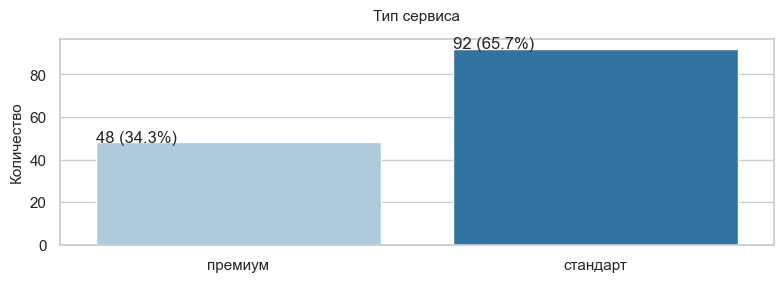

In [200]:
countplot_label(data=high_promo_buy, column='тип_сервиса', \
                title='Тип сервиса', \
                xlabel='', ylabel='Количество', \
                figsize=(8,3), label=2, order_sort=0, rotation=0, palette='Paired')

**Исследование типа сервиса:**    
* 92 покупателя (65.7%) относятся к сервису "стандарт".      
* 48 покупателей (34.3%) относятся к сервису "премиум".

**Посчитаем разницу в выручке между периодами в зависимости от типа сервиса и популярной категории.**

In [201]:
df = high_promo_buy.pivot_table(
    index = ['тип_сервиса','популярная_категория'], 
    aggfunc='sum', 
    values=['разница_в_выручке_тек_пред', 'разница_в_выручке_пред_препред'])
df

разница_в_выручке_пред_препред  \
тип_сервиса популярная_категория                                                   
премиум     Домашний текстиль                                             5328.5   
            Косметика и аксессуары                                        5626.0   
            Кухонная посуда                                               5332.5   
            Мелкая бытовая техника и электроника                          1080.0   
            Техника для красоты и здоровья                                -934.5   
            Товары для детей                                              1219.0   
стандарт    Домашний текстиль                                             4413.0   
            Косметика и аксессуары                                        9864.0   
            Кухонная посуда                                              10565.5   
            Мелкая бытовая техника и электроника                          3018.0   
            Техника для красоты и здоровья                               -4251.5   
            Товары для детей                                               768.5   

                                                  разница_в_выручке_тек_пред  
тип_сервиса популярная_категория                                              
премиум     Домашний текстиль                                         1690.0  
            Косметика и аксессуары                                    4724.2  
            Кухонная посуда                                           3068.0  
            Мелкая бытовая техника и электроника                       765.7  
            Техника для красоты и здоровья                             432.9  
            Товары для детей                                          4780.1  
стандарт    Домашний текстиль                                         6035.9  
            Косметика и аксессуары                                    4778.8  
            Кухонная посуда                                           5565.3  
            Мелкая бытовая техника и электроника                      2727.4  
            Техника для красоты и здоровья                            5265.0  
            Товары для детей                                          5954.0

**Видим, что выручка проседает за предыдущий месяц по категории Техника для красоты и здоровья и для типа сервиса стандарт, и для типа сервиса премиум.** 

**Посмотрим, проседание выручки идет по покупателям, согласным или не согласным на рассылку.**

#### Исследование признака согласия по рассылке и покупательской активности в зависимости от этого признака

**Посмотрим на количество покупателей, согласных на рассылку.**

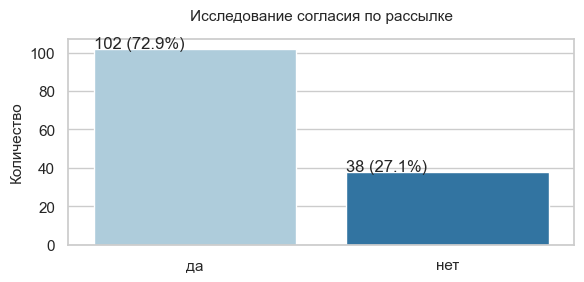

In [202]:
countplot_label(data=high_promo_buy, column='разрешить_сообщать', \
                title='Исследование согласия по рассылке', \
                xlabel='', ylabel='Количество', \
                figsize=(6,3), label=2, order_sort=1, rotation=0, palette='Paired')

**Исследование признака согласия по рассылке:**              
* Согласны - 102 покупателя (72.9%).       
* Не согласны - 38 покупателей (27.1%).

**Желательно, чтобы сегмент с высокой долей акционных покупок имел 100% подписку на рассылку специальных предложений и акций. Так мы можем простимулировать уровень продаж по акциям. Можно для данного сегмента устроить акцию: при подписке на рассылки дарится товар из любимой категории клиента на ограниченную лимитом сумму.**

**Посмотрим на проседание выручки в разрезе популярных категорий, типа сервиса и согласия на рассылку.**

In [203]:
df = high_promo_buy.pivot_table(
    index = ['разрешить_сообщать','тип_сервиса', 'популярная_категория'], 
    aggfunc='sum', 
    values=['разница_в_выручке_тек_пред', 'разница_в_выручке_пред_препред'])
df

разница_в_выручке_пред_препред  \
разрешить_сообщать тип_сервиса популярная_категория                                                   
да                 премиум     Домашний текстиль                                             2783.0   
                               Косметика и аксессуары                                        4019.5   
                               Кухонная посуда                                               5332.5   
                               Мелкая бытовая техника и электроника                          1080.0   
                               Техника для красоты и здоровья                               -1494.0   
                               Товары для детей                                              3225.0   
                   стандарт    Домашний текстиль                                             -579.0   
                               Косметика и аксессуары                                        5641.5   
                               Кухонная посуда                                               9445.0   
                               Мелкая бытовая техника и электроника                          2379.0   
                               Техника для красоты и здоровья                               -4944.0   
                               Товары для детей                                             -3694.5   
нет                премиум     Домашний текстиль                                             2545.5   
                               Косметика и аксессуары                                        1606.5   
                               Техника для красоты и здоровья                                 559.5   
                               Товары для детей                                             -2006.0   
                   стандарт    Домашний текстиль                                             4992.0   
                               Косметика и аксессуары                                        4222.5   
                               Кухонная посуда                                               1120.5   
                               Мелкая бытовая техника и электроника                           639.0   
                               Техника для красоты и здоровья                                 692.5   
                               Товары для детей                                              4463.0   

                                                                     разница_в_выручке_тек_пред  
разрешить_сообщать тип_сервиса популярная_категория                                              
да                 премиум     Домашний текстиль                                          460.2  
                               Косметика и аксессуары                                    4071.6  
                               Кухонная посуда                                           3068.0  
                               Мелкая бытовая техника и электроника                       765.7  
                               Техника для красоты и здоровья                             240.5  
                               Товары для детей                                          2818.4  
                   стандарт    Домашний текстиль                                         3515.2  
                               Косметика и аксессуары                                    4694.3  
                               Кухонная посуда                                           4160.0  
                               Мелкая бытовая техника и электроника                      2043.6  
                               Техника для красоты и здоровья                            5349.5  
                               Товары для детей                                          3972.8  
нет                премиум     Домашний текстиль                                         1229.8  
                               Косметика и аксессуары                                     652.6  
                            

**Выручка за предыдущий месяц проседает по категории Техника для красоты и здоровья для типа сервиса стандарт (-4944 руб.) и типа сервиса премиум (-1494 руб.) среди согласных на рассылку покупателей, а также по категории Товары для детей типа сервиса премиум среди несогласных на рассылку покупателей (-2006 руб.).**      
**Выручка за текущий месяц проседает по категории Техника для красоты и здоровья для типа сервиса стандарт среди несогласных на рассылку покупателей (-84.5 руб.).**

#### Исследование влияния маркетинговых коммуникаций на вероятность снижения покупательской активности

Посмотрим, как влияют маркетинговые коммуникации за последние 6 месяцев и в текущем месяце на вероятность снижения покупательской активности. Для этого построим скаттерплот. Чтобы воспользоваться 3 измерениями, будем использовать параметр hue, с помощью которого раскрасим в разные оттенки количество маркетинговых коммуникаций в текущем месяце.

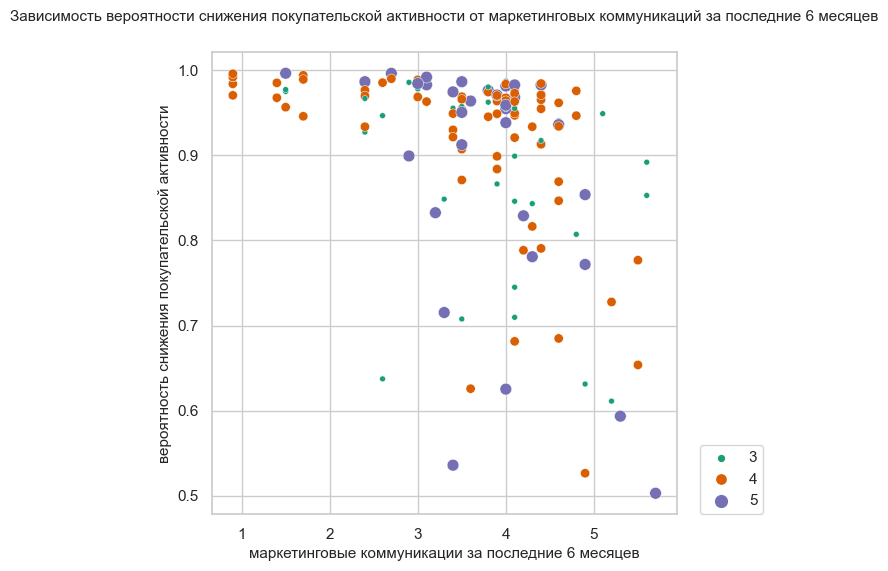

In [204]:
plt.figure(figsize=(6,6))
sns.scatterplot(y='вероятность_класса_1', x='маркет_актив_6_мес', data=high_promo_buy, \
                hue='маркет_актив_тек_мес', size='маркет_актив_тек_мес', palette='Dark2');
# Заголовок
plt.title(
    'Зависимость вероятности снижения покупательской активности от маркетинговых коммуникаций за последние 6 месяцев',
    y=1.05, fontsize=11);
# подписи осей
plt.xlabel('маркетинговые коммуникации за последние 6 месяцев', fontsize=11);
plt.ylabel('вероятность снижения покупательской активности', fontsize=11);
# задание местоположения легенды
plt.legend(loc=(1.05,0));

* При небольшом числе маркетинговых коммуникаций за последние 6 месяцев (1, 2) наблюдаем высокую вероятность снижения покупательской активности.
* Для количества маркетинговых коммуникаций в текущем месяце не наблюдается такой ярко выраженной зависимости.

#### Исследование  влияния количества просмотренных категорий и страниц за визит на вероятность снижения покупательской активности

Построим скаттерплот в 3 измерениях.На осях: ординат - вероятность снижения покупательской активности, абсцисс - количество страниц за визит. Третье измерение возможно отложить с помощью параметра hue - цветовой окраски. В качестве 3 измерения выберем количество просмотров категорий за визит.

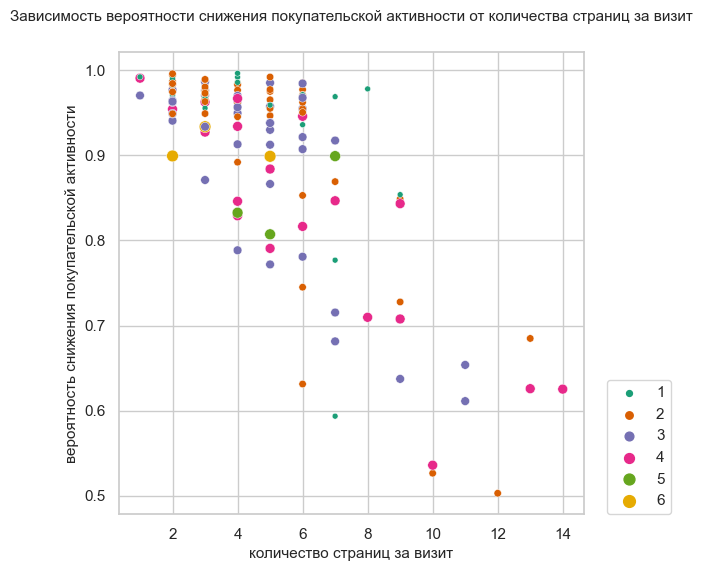

In [205]:
plt.figure(figsize=(6,6))
sns.scatterplot(y='вероятность_класса_1', x='страниц_за_визит', data=high_promo_buy, \
                hue='средний_просмотр_категорий_за_визит', size='средний_просмотр_категорий_за_визит', palette='Dark2');
# Заголовок
plt.title('Зависимость вероятности снижения покупательской активности от количества страниц за визит', \
          y=1.05, fontsize=11);
# подписи осей
plt.xlabel('количество страниц за визит', fontsize=11);
plt.ylabel('вероятность снижения покупательской активности', fontsize=11);
# задание местоположения легенды
plt.legend(loc=(1.05,0));

In [206]:
high_promo_buy.groupby(['средний_просмотр_категорий_за_визит'])['вероятность_класса_1'].agg('mean')

средний_просмотр_категорий_за_визит
1    0.944339
2    0.920679
3    0.902137
4    0.828460
5    0.846223
6    0.910492
Name: вероятность_класса_1, dtype: float64

В среднем, в большинстве случаев, чем меньше просмотренных страниц за визит, тем больше вероятность снижения покупательской активности.  Для количества просмотренных категорий за визит не прослеживается такой зависимости. 

#### Исследование влияния количества минут на сайте на вероятность снижения покупательской активности

In [207]:
#объединяем датафреймы с выручкой и минутами
df_time = df_period.reset_index().merge(market_time, on=['id', 'период'])
df_time.head(3)

id популярная_категория            период  выручка  минут
0  215349     Товары для детей     текущий_месяц   4971.6     10
1  215349     Товары для детей  предыдущий_месяц   5216.0     12
2  215351     Товары для детей     текущий_месяц   6610.4     13

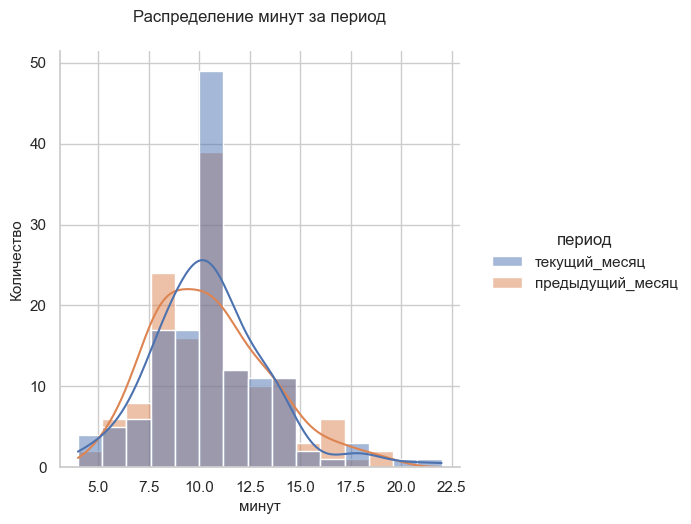

In [208]:
sns.displot(data=df_time, hue='период', kde=True, x='минут');
# Подписи осей
plt.xlabel('минут', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение минут за период', y=1.05);

In [209]:
# группировка по периодам, вычисление среднего, медианного, общего количества минут и указание количества объектов в периоде
df_time.groupby('период')['минут'].agg(['mean','median', 'sum', 'count'])

mean  median   sum  count
период                                          
предыдущий_месяц  10.542857      10  1476    140
текущий_месяц     10.542857      10  1476    140

**Среднее количество минут, проведенных покупателями на сайте, за предыдущий и текущий месяцы одинаково.**

**Распределение количества минут на сайте за текущий и предыдущий месяцы имеет схожие характеристики.**

**Так как признак количества минут на сайте не имеет особых различий по периодам, то построим скаттерплот для текущего месяца, чтобы посмотреть, как влияет количество минут на вероятность снижения покупательской активности.**

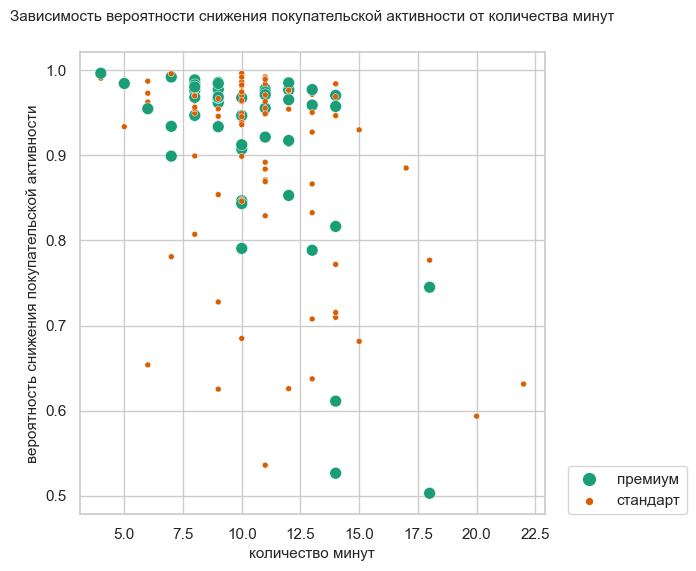

In [210]:
plt.figure(figsize=(6,6))
sns.scatterplot(y='вероятность_класса_1', x='минут_текущий_месяц', data=high_promo_buy, \
                hue='тип_сервиса', size='тип_сервиса', palette='Dark2');
# Заголовок
plt.title('Зависимость вероятности снижения покупательской активности от количества минут', \
          y=1.05, fontsize=11);
# подписи осей
plt.xlabel('количество минут', fontsize=11);
plt.ylabel('вероятность снижения покупательской активности', fontsize=11);
# задание местоположения легенды
plt.legend(loc=(1.05,0));

**Зависимость прослеживается для типа сервиса премиум: в среднем, чем меньше покупатели проводят времени на сайте, тем больше вероятность снижения покупательской активности.**

### Итоговый вывод по анализу сегмента с высокой долей акционных покупок

**Был рассмотрен сегмент: с высокой долей акционных покупок и с высокой вероятностью снижения покупательской активности (140 покупателей).**    
* В данном сегменте 92 покупателя (65.7%) относится к типу сервиса стандарт, 48 покупателей (34.3%) к премиум. При этом 102 покупателя (72.9%) согласны на рассылку от интернет-магазина и 38 покупателей (27.1%) - не согласны. Для рассматриваемоего сегмента наиболее популярны категории - Товары для детей (46 покупателей, 32.9%), Косметика и аксессуары (28 покупателей, 20%), Домашний текстиль (25 покупателей, 17.9%), наименее популярны категории - Мелкая бытовая техника и электроника (7 покупателей, 5%), Техника для красоты и здоровья (14 покупателей, 10%), Кухонная посуда (20 покупателей, 14.3%).      
* Были проанализированы факторы, которые влияют на рассматриваемый сегмент более всего. Для данного сегмента было обнаружено, что чем больше количество маркетинговых коммуникаций за последние 6 месяцев, просмотренных страниц за визит, тем меньше вероятность снижения покупательской активности. Для типа сервиса премиум также влияет время проведенное на сайте: в среднем, чем больше время на сайте, тем меньше вероятность снижения покупательской активности.   
* Для данного сегмента была проанализирована выручка за 3 месяца: текущий, предыдущий и препредыдущий. Средняя выручка увеличивается по месяцам, что сопровождается увеличением риска дополнительного рубля выручки. Коэффициент вариации в текущем месяце составил 16.4 против 5.5 в препредыдущем месяце. Анализ выручки в разрезе категорий, типа сервиса и согласия по рассылке выявил:
выручка за предыдущий месяц проседает по категории Техника для красоты и здоровья для типа сервиса стандарт (-4944 руб.) и типа сервиса премиум (-1494 руб.) среди согласных на рассылку покупателей, а также по категории Товары для детей типа сервиса премиум среди несогласных на рассылку покупателей (-2006 руб.). Выручка за текущий месяц проседает по категории Техника для красоты и здоровья для типа сервиса стандарт среди несогласных на рассылку покупателей (-84.5 руб.). Проседание выручки по категории Техника для красоты и здоровья вполне объяснимо, ведь товары данной категории покупаются на длительный срок и в какой-то момент выручка по ним может проседать. Можно попробовать предложить на данную категорию товара какую-нибудь акцию. Однако, если товар длительного срока уже есть в наличии, акция не всегда может действовать. В этом случае могут действовать акции на другие товары менее длительного срока, чтобы в среднем получить запланированную сумму выручки с покупателей за счет товаров других категорий по акциям.  В случае с проседанием выручки по категории Товары для детей, возможно, стоит предложить для данной группы покупателей акции либо накопление баллов по данной категории товаров, чтобы увеличить покупательскую активность.        
* Дополнительные рекомендации для бизнеса. Рассматриваемый сегмент имеет склонность к снижению покупательской активности. Можно продумать такие акции, чтобы в конечном счете большая часть клиентов данного сегмента перетекла в сегмент, не зависящий от акций. Чтобы клиент захотел покупать именно в этом магазине также другие нужные ему товары. Чтобы ему было это удобно и выгодно. Есть популярные категории товаров, пользующиеся повышенным спросом. Можно устраивать акции, что при покупке товаров из определенного списка либо при покупке на определенную сумму дарится на выбор какой-нибудь популярный товар. Также использовать категории любимых товаров с начислением баллов за покупки по этим категориям. На накопленные баллы можно приобрести какой-нибудь товар либо уменьшить сумму следующей покупки.
* Желательно, чтобы сегмент с высокой долей акционных покупок имел 100% подписку на рассылку специальных предложений и акций. Так мы можем простимулировать уровень продаж по акциям. Можно для данного сегмента устроить акцию: при подписке на рассылки дарится товар из любимой категории клиента на ограниченную лимитом сумму.